<a href="https://colab.research.google.com/github/isabelgilchristmiller/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

:<a href="https://colab.research.google.com/github/isabelgilchristmiller/QCES/blob/main/Project4_storms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Storms
In this project, we will use Dedalus to solve the 2-layer quasi-geostrophic equations to model the development of atmospheric storm systems.

The two-layer quasi-geostrophic (QG) equations describe the motion of two vertically-stacked shallow layers of fluid in the limit where the Rossby number, $Ro=U/fL$ is small, where $U$ is a characteristic velocity scale, $L$ is a characteristic horizontal lengthscale, and $f$ is the Coriolis parameter. Here, we will use `1` to refer to quantitites in the upper layer and `2` to refer to quantities in the lower layer.

The fluid in the upper layer is lighter than the fluid in the lower layer (such that $\rho_1<\rho_2$). When the interface separating the upper and lower layers isn't flat, the varying thicknesses of the upper and lower layers implies that there are horizontal gradients in the hydrostatic pressure. When the Rossby number is small, $Ro\ll 1$, the flow will tend to be close to geostrophic balance a velocity difference between the upper and lower layer that balances the horizontal pressure gradients.

Student tasks are in [Section 1.5](#section1pt5), [Section 2.3](#section2pt3), and [Section 3.1](#section3pt1).

## 1. Two-layer quasi-geostrophic equations in a periodic box

In this section we will solve a non-dimensional version of the two-layer QG equations in Cartesian coordinates. Let $+x$ denote the eastwards direction and $+y$ denote the northwards direction. We start with a flow in geostrophic balance where the velocity is constant in each layer. Let $U \hat{\mathbf{x}}$ denote the velocity in the top layer and $-U \hat{\mathbf{x}}$ denote the velocity in the bottom layer. Geostrophic balance then implies that the interface has a constant, non-zero slope. We will invoke the so-called "beta-plane" approximation and make the Coriolis parameter a linear function of $y$.

In this section we solve for the departures to the background state described above. We let $q_1$ and $q_2$ denote the perturbation QG potential vorticity and $\psi_1$ and $\psi_2$ denote the perturbation streamfunction. Although the background state is not periodic, we apply periodic boundary conditions in $x$ and $y$ to the perturbation quantities. This has the effect of maintaining the north/south potential vorticity gradient associated with the background state.

### 1.1 Governing equations

The script below solves the following equations:

$$ \partial_t(q_1) + U \partial_x(q_1) + \frac{2U}{R_{d1}^2}\partial_x(\psi_1)-\nu \nabla^2 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) - U \partial_x(q_2) - \frac{2U}{R_{d2}^2}\partial_x(\psi_2)-\nu \nabla^2 q_2 = - J(\psi_2, q_2), $$

where $R_{d1,2}=\sqrt{g'H_{1,2}}/f_0$ is the internal deformation radius in each layer, $g'=(\rho_2-\rho_1)/\rho_0$ is the reduced gravity, $\rho_0$ is a reference density, $J(a,b)=\partial_x(a)\partial_y(b) - \partial_y(a)\partial_x(b)$ is the Jacobian operator and $\nu$ is a viscosity which is added to keep the model stable.

In addition to the equations above, two other equations relate the perturbation potential vorticity and streamfunctions:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2}, $$
$$q_2=\nabla^2\psi_2 + \frac{\psi_1-\psi_2}{R_{d2}^2}. $$

### 1.2 Tau method

The equations above are invariant to a constant added to $\psi_1-\psi_2$. Therefore, there are infinitely many solutions to the above equations and the coefficient matrix associated with the discretized equations will be singular. To avoid this, we can add an extra equation to the system to set this constant offset. Here, we do this by including the following equation:

$$ \int\int \psi_1 dxdy = 0 $$

which in effect ensures that the spatial mean of $\psi_1$ is zero. The problem now is that we have five equations for four unknowns. One fix is to include another unknown in our system. We will include a constant called $\tau_{\psi1}$ and we will add it to the equation relating the upper layer QG potential voricity and streamfunction which then becomes:

$$q_1=\nabla^2\psi_1 - \frac{\psi_1-\psi_2}{R_{d1}^2} + \tau_{\psi1}. $$

Since adding a constant to the potential vorticity and streamfunction doesn't have any impact on the dynamics of the system, adding $\tau_{\psi1}$ here won't cause any problems and we now have a fully constained set of equations.


### 1.3 Dedalus script

The script below solves the 2-layer QG equations given above with non-dimensional parameters. Note that the velocity gets faster as the simulation progresses. If you find that the code blows up (returns NaNs and a white screen), try reducing the timestep.

In [23]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


In [24]:
# # Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 64 # Number of gridpoints in x
Ny = 64 # Number of gridpoints in y
Lx = 100 # Domain size in x
Ly = 100 # Domain size in y
Rd1 = 3 # Deformation radius in layer 1
Rd2 = 3 # Deformation radius in layer 2
U = 1 # Background velocity in layer 1

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu = 0.2

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/U/100 # This is just an estimate based on the background velocity
stop_sim_time = 70

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Set the initial conditions
q1.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
q2.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U*dx(q1) + (2*U/Rd1**2.0)*dx(psi1) - nu*lap(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) - U*dx(q2) - (2*U/Rd2**2.0)*dx(psi2) - nu*lap(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")

problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK443)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];
t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 2.2e+01/s


2025-12-01 20:52:29,258 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 2.2e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.5e+01/s


2025-12-01 20:52:29,373 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s


2025-12-01 20:52:29,508 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.1e+01/s


2025-12-01 20:52:29,601 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 3.1e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s


2025-12-01 20:52:29,694 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.4e+01/s


2025-12-01 20:52:29,798 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


2025-12-01 20:52:29,890 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-12-01 20:52:29,994 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-12-01 20:52:30,082 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:__main__:Starting main loop


2025-12-01 20:52:30,090 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e-03, dt=7.812500e-03


2025-12-01 20:52:30,198 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e-03, dt=7.812500e-03


INFO:__main__:Iteration=11, Time=8.593750e-02, dt=7.812500e-03


2025-12-01 20:52:30,433 __main__ 0/1 INFO :: Iteration=11, Time=8.593750e-02, dt=7.812500e-03


INFO:__main__:Iteration=21, Time=1.640625e-01, dt=7.812500e-03


2025-12-01 20:52:30,674 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e-01, dt=7.812500e-03


INFO:__main__:Iteration=31, Time=2.421875e-01, dt=7.812500e-03


2025-12-01 20:52:30,909 __main__ 0/1 INFO :: Iteration=31, Time=2.421875e-01, dt=7.812500e-03


INFO:__main__:Iteration=41, Time=3.203125e-01, dt=7.812500e-03


2025-12-01 20:52:31,162 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e-01, dt=7.812500e-03


INFO:__main__:Iteration=51, Time=3.984375e-01, dt=7.812500e-03


2025-12-01 20:52:31,456 __main__ 0/1 INFO :: Iteration=51, Time=3.984375e-01, dt=7.812500e-03


INFO:__main__:Iteration=61, Time=4.765625e-01, dt=7.812500e-03


2025-12-01 20:52:31,869 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e-01, dt=7.812500e-03


INFO:__main__:Iteration=71, Time=5.546875e-01, dt=7.812500e-03


2025-12-01 20:52:32,286 __main__ 0/1 INFO :: Iteration=71, Time=5.546875e-01, dt=7.812500e-03


INFO:__main__:Iteration=81, Time=6.328125e-01, dt=7.812500e-03


2025-12-01 20:52:32,559 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e-01, dt=7.812500e-03


INFO:__main__:Iteration=91, Time=7.109375e-01, dt=7.812500e-03


2025-12-01 20:52:32,823 __main__ 0/1 INFO :: Iteration=91, Time=7.109375e-01, dt=7.812500e-03


INFO:__main__:Iteration=101, Time=7.890625e-01, dt=7.812500e-03


2025-12-01 20:52:33,090 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e-01, dt=7.812500e-03


INFO:__main__:Iteration=111, Time=8.671875e-01, dt=7.812500e-03


2025-12-01 20:52:33,374 __main__ 0/1 INFO :: Iteration=111, Time=8.671875e-01, dt=7.812500e-03


INFO:__main__:Iteration=121, Time=9.453125e-01, dt=7.812500e-03


2025-12-01 20:52:33,638 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e-01, dt=7.812500e-03


INFO:__main__:Iteration=131, Time=1.023438e+00, dt=7.812500e-03


2025-12-01 20:52:33,893 __main__ 0/1 INFO :: Iteration=131, Time=1.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=141, Time=1.101562e+00, dt=7.812500e-03


2025-12-01 20:52:34,157 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=151, Time=1.179688e+00, dt=7.812500e-03


2025-12-01 20:52:34,442 __main__ 0/1 INFO :: Iteration=151, Time=1.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=161, Time=1.257812e+00, dt=7.812500e-03


2025-12-01 20:52:34,714 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=171, Time=1.335938e+00, dt=7.812500e-03


2025-12-01 20:52:34,969 __main__ 0/1 INFO :: Iteration=171, Time=1.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=181, Time=1.414062e+00, dt=7.812500e-03


2025-12-01 20:52:35,264 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=191, Time=1.492188e+00, dt=7.812500e-03


2025-12-01 20:52:35,532 __main__ 0/1 INFO :: Iteration=191, Time=1.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=201, Time=1.570312e+00, dt=7.812500e-03


2025-12-01 20:52:35,792 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=211, Time=1.648438e+00, dt=7.812500e-03


2025-12-01 20:52:36,042 __main__ 0/1 INFO :: Iteration=211, Time=1.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=221, Time=1.726562e+00, dt=7.812500e-03


2025-12-01 20:52:36,295 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=231, Time=1.804688e+00, dt=7.812500e-03


2025-12-01 20:52:36,538 __main__ 0/1 INFO :: Iteration=231, Time=1.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=241, Time=1.882812e+00, dt=7.812500e-03


2025-12-01 20:52:36,784 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=251, Time=1.960938e+00, dt=7.812500e-03


2025-12-01 20:52:37,020 __main__ 0/1 INFO :: Iteration=251, Time=1.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=261, Time=2.039062e+00, dt=7.812500e-03


2025-12-01 20:52:37,304 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=271, Time=2.117188e+00, dt=7.812500e-03


2025-12-01 20:52:37,590 __main__ 0/1 INFO :: Iteration=271, Time=2.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=281, Time=2.195312e+00, dt=7.812500e-03


2025-12-01 20:52:37,848 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=291, Time=2.273438e+00, dt=7.812500e-03


2025-12-01 20:52:38,104 __main__ 0/1 INFO :: Iteration=291, Time=2.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=301, Time=2.351562e+00, dt=7.812500e-03


2025-12-01 20:52:38,402 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=311, Time=2.429688e+00, dt=7.812500e-03


2025-12-01 20:52:38,668 __main__ 0/1 INFO :: Iteration=311, Time=2.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=321, Time=2.507812e+00, dt=7.812500e-03


2025-12-01 20:52:38,934 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=331, Time=2.585938e+00, dt=7.812500e-03


2025-12-01 20:52:39,201 __main__ 0/1 INFO :: Iteration=331, Time=2.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=341, Time=2.664062e+00, dt=7.812500e-03


2025-12-01 20:52:39,504 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=351, Time=2.742188e+00, dt=7.812500e-03


2025-12-01 20:52:39,942 __main__ 0/1 INFO :: Iteration=351, Time=2.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=361, Time=2.820312e+00, dt=7.812500e-03


2025-12-01 20:52:40,338 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=371, Time=2.898438e+00, dt=7.812500e-03


2025-12-01 20:52:40,768 __main__ 0/1 INFO :: Iteration=371, Time=2.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=381, Time=2.976562e+00, dt=7.812500e-03


2025-12-01 20:52:41,165 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=391, Time=3.054688e+00, dt=7.812500e-03


2025-12-01 20:52:41,592 __main__ 0/1 INFO :: Iteration=391, Time=3.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=401, Time=3.132812e+00, dt=7.812500e-03


2025-12-01 20:52:42,664 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=411, Time=3.210938e+00, dt=7.812500e-03


2025-12-01 20:52:43,445 __main__ 0/1 INFO :: Iteration=411, Time=3.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=421, Time=3.289062e+00, dt=7.812500e-03


2025-12-01 20:52:44,371 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=431, Time=3.367188e+00, dt=7.812500e-03


2025-12-01 20:52:45,102 __main__ 0/1 INFO :: Iteration=431, Time=3.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=441, Time=3.445312e+00, dt=7.812500e-03


2025-12-01 20:52:45,906 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=451, Time=3.523438e+00, dt=7.812500e-03


2025-12-01 20:52:46,516 __main__ 0/1 INFO :: Iteration=451, Time=3.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=461, Time=3.601562e+00, dt=7.812500e-03


2025-12-01 20:52:47,049 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=471, Time=3.679688e+00, dt=7.812500e-03


2025-12-01 20:52:47,532 __main__ 0/1 INFO :: Iteration=471, Time=3.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=481, Time=3.757812e+00, dt=7.812500e-03


2025-12-01 20:52:48,114 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=491, Time=3.835938e+00, dt=7.812500e-03


2025-12-01 20:52:48,576 __main__ 0/1 INFO :: Iteration=491, Time=3.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=501, Time=3.914062e+00, dt=7.812500e-03


2025-12-01 20:52:49,217 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=511, Time=3.992188e+00, dt=7.812500e-03


2025-12-01 20:52:49,891 __main__ 0/1 INFO :: Iteration=511, Time=3.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=521, Time=4.070312e+00, dt=7.812500e-03


2025-12-01 20:52:50,542 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=531, Time=4.148438e+00, dt=7.812500e-03


2025-12-01 20:52:51,193 __main__ 0/1 INFO :: Iteration=531, Time=4.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=541, Time=4.226562e+00, dt=7.812500e-03


2025-12-01 20:52:51,723 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=551, Time=4.304688e+00, dt=7.812500e-03


2025-12-01 20:52:52,275 __main__ 0/1 INFO :: Iteration=551, Time=4.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=561, Time=4.382812e+00, dt=7.812500e-03


2025-12-01 20:52:53,137 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=571, Time=4.460938e+00, dt=7.812500e-03


2025-12-01 20:52:54,078 __main__ 0/1 INFO :: Iteration=571, Time=4.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=581, Time=4.539062e+00, dt=7.812500e-03


2025-12-01 20:52:55,209 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=591, Time=4.617188e+00, dt=7.812500e-03


2025-12-01 20:52:55,899 __main__ 0/1 INFO :: Iteration=591, Time=4.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=601, Time=4.695312e+00, dt=7.812500e-03


2025-12-01 20:52:56,628 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=611, Time=4.773438e+00, dt=7.812500e-03


2025-12-01 20:52:57,110 __main__ 0/1 INFO :: Iteration=611, Time=4.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=621, Time=4.851562e+00, dt=7.812500e-03


2025-12-01 20:52:57,641 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=631, Time=4.929688e+00, dt=7.812500e-03


2025-12-01 20:52:58,139 __main__ 0/1 INFO :: Iteration=631, Time=4.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=641, Time=5.007812e+00, dt=7.812500e-03


2025-12-01 20:52:58,592 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+00, dt=7.812500e-03


INFO:__main__:Iteration=651, Time=5.085938e+00, dt=7.812500e-03


2025-12-01 20:52:59,072 __main__ 0/1 INFO :: Iteration=651, Time=5.085938e+00, dt=7.812500e-03


INFO:__main__:Iteration=661, Time=5.164062e+00, dt=7.812500e-03


2025-12-01 20:52:59,527 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+00, dt=7.812500e-03


INFO:__main__:Iteration=671, Time=5.242188e+00, dt=7.812500e-03


2025-12-01 20:53:00,110 __main__ 0/1 INFO :: Iteration=671, Time=5.242188e+00, dt=7.812500e-03


INFO:__main__:Iteration=681, Time=5.320312e+00, dt=7.812500e-03


2025-12-01 20:53:00,630 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+00, dt=7.812500e-03


INFO:__main__:Iteration=691, Time=5.398438e+00, dt=7.812500e-03


2025-12-01 20:53:01,112 __main__ 0/1 INFO :: Iteration=691, Time=5.398438e+00, dt=7.812500e-03


INFO:__main__:Iteration=701, Time=5.476562e+00, dt=7.812500e-03


2025-12-01 20:53:01,556 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+00, dt=7.812500e-03


INFO:__main__:Iteration=711, Time=5.554688e+00, dt=7.812500e-03


2025-12-01 20:53:02,198 __main__ 0/1 INFO :: Iteration=711, Time=5.554688e+00, dt=7.812500e-03


INFO:__main__:Iteration=721, Time=5.632812e+00, dt=7.812500e-03


2025-12-01 20:53:02,725 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+00, dt=7.812500e-03


INFO:__main__:Iteration=731, Time=5.710938e+00, dt=7.812500e-03


2025-12-01 20:53:03,316 __main__ 0/1 INFO :: Iteration=731, Time=5.710938e+00, dt=7.812500e-03


INFO:__main__:Iteration=741, Time=5.789062e+00, dt=7.812500e-03


2025-12-01 20:53:03,766 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+00, dt=7.812500e-03


INFO:__main__:Iteration=751, Time=5.867188e+00, dt=7.812500e-03


2025-12-01 20:53:04,233 __main__ 0/1 INFO :: Iteration=751, Time=5.867188e+00, dt=7.812500e-03


INFO:__main__:Iteration=761, Time=5.945312e+00, dt=7.812500e-03


2025-12-01 20:53:04,721 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+00, dt=7.812500e-03


INFO:__main__:Iteration=771, Time=6.023438e+00, dt=7.812500e-03


2025-12-01 20:53:05,158 __main__ 0/1 INFO :: Iteration=771, Time=6.023438e+00, dt=7.812500e-03


INFO:__main__:Iteration=781, Time=6.101562e+00, dt=7.812500e-03


2025-12-01 20:53:05,642 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+00, dt=7.812500e-03


INFO:__main__:Iteration=791, Time=6.179688e+00, dt=7.812500e-03


2025-12-01 20:53:06,097 __main__ 0/1 INFO :: Iteration=791, Time=6.179688e+00, dt=7.812500e-03


INFO:__main__:Iteration=801, Time=6.257812e+00, dt=7.812500e-03


2025-12-01 20:53:06,647 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+00, dt=7.812500e-03


INFO:__main__:Iteration=811, Time=6.335938e+00, dt=7.812500e-03


2025-12-01 20:53:07,485 __main__ 0/1 INFO :: Iteration=811, Time=6.335938e+00, dt=7.812500e-03


INFO:__main__:Iteration=821, Time=6.414062e+00, dt=7.812500e-03


2025-12-01 20:53:08,203 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+00, dt=7.812500e-03


INFO:__main__:Iteration=831, Time=6.492188e+00, dt=7.812500e-03


2025-12-01 20:53:09,263 __main__ 0/1 INFO :: Iteration=831, Time=6.492188e+00, dt=7.812500e-03


INFO:__main__:Iteration=841, Time=6.570312e+00, dt=7.812500e-03


2025-12-01 20:53:10,190 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+00, dt=7.812500e-03


INFO:__main__:Iteration=851, Time=6.648438e+00, dt=7.812500e-03


2025-12-01 20:53:10,786 __main__ 0/1 INFO :: Iteration=851, Time=6.648438e+00, dt=7.812500e-03


INFO:__main__:Iteration=861, Time=6.726562e+00, dt=7.812500e-03


2025-12-01 20:53:11,249 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+00, dt=7.812500e-03


INFO:__main__:Iteration=871, Time=6.804688e+00, dt=7.812500e-03


2025-12-01 20:53:11,718 __main__ 0/1 INFO :: Iteration=871, Time=6.804688e+00, dt=7.812500e-03


INFO:__main__:Iteration=881, Time=6.882812e+00, dt=7.812500e-03


2025-12-01 20:53:12,316 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+00, dt=7.812500e-03


INFO:__main__:Iteration=891, Time=6.960938e+00, dt=7.812500e-03


2025-12-01 20:53:12,813 __main__ 0/1 INFO :: Iteration=891, Time=6.960938e+00, dt=7.812500e-03


INFO:__main__:Iteration=901, Time=7.039062e+00, dt=7.812500e-03


2025-12-01 20:53:13,251 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+00, dt=7.812500e-03


INFO:__main__:Iteration=911, Time=7.117188e+00, dt=7.812500e-03


2025-12-01 20:53:13,636 __main__ 0/1 INFO :: Iteration=911, Time=7.117188e+00, dt=7.812500e-03


INFO:__main__:Iteration=921, Time=7.195312e+00, dt=7.812500e-03


2025-12-01 20:53:14,064 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+00, dt=7.812500e-03


INFO:__main__:Iteration=931, Time=7.273438e+00, dt=7.812500e-03


2025-12-01 20:53:14,456 __main__ 0/1 INFO :: Iteration=931, Time=7.273438e+00, dt=7.812500e-03


INFO:__main__:Iteration=941, Time=7.351562e+00, dt=7.812500e-03


2025-12-01 20:53:14,872 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+00, dt=7.812500e-03


INFO:__main__:Iteration=951, Time=7.429688e+00, dt=7.812500e-03


2025-12-01 20:53:15,323 __main__ 0/1 INFO :: Iteration=951, Time=7.429688e+00, dt=7.812500e-03


INFO:__main__:Iteration=961, Time=7.507812e+00, dt=7.812500e-03


2025-12-01 20:53:15,714 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+00, dt=7.812500e-03


INFO:__main__:Iteration=971, Time=7.585938e+00, dt=7.812500e-03


2025-12-01 20:53:16,141 __main__ 0/1 INFO :: Iteration=971, Time=7.585938e+00, dt=7.812500e-03


INFO:__main__:Iteration=981, Time=7.664062e+00, dt=7.812500e-03


2025-12-01 20:53:16,622 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+00, dt=7.812500e-03


INFO:__main__:Iteration=991, Time=7.742188e+00, dt=7.812500e-03


2025-12-01 20:53:17,058 __main__ 0/1 INFO :: Iteration=991, Time=7.742188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


2025-12-01 20:53:17,502 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


2025-12-01 20:53:17,967 __main__ 0/1 INFO :: Iteration=1011, Time=7.898438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


2025-12-01 20:53:18,419 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


2025-12-01 20:53:18,810 __main__ 0/1 INFO :: Iteration=1031, Time=8.054688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


2025-12-01 20:53:19,453 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


2025-12-01 20:53:19,703 __main__ 0/1 INFO :: Iteration=1051, Time=8.210938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


2025-12-01 20:53:19,951 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


2025-12-01 20:53:20,603 __main__ 0/1 INFO :: Iteration=1071, Time=8.367188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


2025-12-01 20:53:21,003 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


2025-12-01 20:53:21,722 __main__ 0/1 INFO :: Iteration=1091, Time=8.523438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


2025-12-01 20:53:22,771 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


2025-12-01 20:53:23,733 __main__ 0/1 INFO :: Iteration=1111, Time=8.679688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


2025-12-01 20:53:24,104 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


2025-12-01 20:53:24,456 __main__ 0/1 INFO :: Iteration=1131, Time=8.835938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


2025-12-01 20:53:24,793 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


2025-12-01 20:53:25,162 __main__ 0/1 INFO :: Iteration=1151, Time=8.992188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


2025-12-01 20:53:25,516 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


2025-12-01 20:53:25,813 __main__ 0/1 INFO :: Iteration=1171, Time=9.148438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


2025-12-01 20:53:26,101 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


2025-12-01 20:53:26,425 __main__ 0/1 INFO :: Iteration=1191, Time=9.304688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


2025-12-01 20:53:26,823 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+00, dt=7.812500e-03


INFO:__main__:Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


2025-12-01 20:53:27,601 __main__ 0/1 INFO :: Iteration=1211, Time=9.460938e+00, dt=7.812500e-03


INFO:__main__:Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


2025-12-01 20:53:28,269 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+00, dt=7.812500e-03


INFO:__main__:Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


2025-12-01 20:53:28,795 __main__ 0/1 INFO :: Iteration=1231, Time=9.617188e+00, dt=7.812500e-03


INFO:__main__:Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


2025-12-01 20:53:29,230 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+00, dt=7.812500e-03


INFO:__main__:Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


2025-12-01 20:53:29,634 __main__ 0/1 INFO :: Iteration=1251, Time=9.773438e+00, dt=7.812500e-03


INFO:__main__:Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


2025-12-01 20:53:30,087 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+00, dt=7.812500e-03


INFO:__main__:Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


2025-12-01 20:53:30,384 __main__ 0/1 INFO :: Iteration=1271, Time=9.929688e+00, dt=7.812500e-03


INFO:__main__:Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


2025-12-01 20:53:30,773 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


2025-12-01 20:53:31,040 __main__ 0/1 INFO :: Iteration=1291, Time=1.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


2025-12-01 20:53:31,306 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


2025-12-01 20:53:31,611 __main__ 0/1 INFO :: Iteration=1311, Time=1.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


2025-12-01 20:53:31,902 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


2025-12-01 20:53:32,215 __main__ 0/1 INFO :: Iteration=1331, Time=1.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


2025-12-01 20:53:32,496 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


2025-12-01 20:53:32,815 __main__ 0/1 INFO :: Iteration=1351, Time=1.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


2025-12-01 20:53:33,258 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


2025-12-01 20:53:33,625 __main__ 0/1 INFO :: Iteration=1371, Time=1.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


2025-12-01 20:53:34,199 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


2025-12-01 20:53:35,020 __main__ 0/1 INFO :: Iteration=1391, Time=1.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


2025-12-01 20:53:36,311 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


2025-12-01 20:53:37,261 __main__ 0/1 INFO :: Iteration=1411, Time=1.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


2025-12-01 20:53:38,244 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


2025-12-01 20:53:38,959 __main__ 0/1 INFO :: Iteration=1431, Time=1.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


2025-12-01 20:53:39,819 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


2025-12-01 20:53:40,623 __main__ 0/1 INFO :: Iteration=1451, Time=1.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


2025-12-01 20:53:41,342 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


2025-12-01 20:53:42,197 __main__ 0/1 INFO :: Iteration=1471, Time=1.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


2025-12-01 20:53:43,128 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


2025-12-01 20:53:43,997 __main__ 0/1 INFO :: Iteration=1491, Time=1.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


2025-12-01 20:53:44,555 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


2025-12-01 20:53:45,399 __main__ 0/1 INFO :: Iteration=1511, Time=1.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


2025-12-01 20:53:46,266 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


2025-12-01 20:53:47,155 __main__ 0/1 INFO :: Iteration=1531, Time=1.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


2025-12-01 20:53:48,124 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


2025-12-01 20:53:49,249 __main__ 0/1 INFO :: Iteration=1551, Time=1.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


2025-12-01 20:53:50,367 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


2025-12-01 20:53:51,108 __main__ 0/1 INFO :: Iteration=1571, Time=1.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


2025-12-01 20:53:51,713 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


2025-12-01 20:53:52,168 __main__ 0/1 INFO :: Iteration=1591, Time=1.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


2025-12-01 20:53:52,858 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


2025-12-01 20:53:53,647 __main__ 0/1 INFO :: Iteration=1611, Time=1.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


2025-12-01 20:53:54,205 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


2025-12-01 20:53:54,879 __main__ 0/1 INFO :: Iteration=1631, Time=1.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


2025-12-01 20:53:55,550 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


2025-12-01 20:53:56,433 __main__ 0/1 INFO :: Iteration=1651, Time=1.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


2025-12-01 20:53:57,288 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


2025-12-01 20:53:58,076 __main__ 0/1 INFO :: Iteration=1671, Time=1.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


2025-12-01 20:53:58,653 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


2025-12-01 20:53:59,149 __main__ 0/1 INFO :: Iteration=1691, Time=1.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


2025-12-01 20:53:59,751 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


2025-12-01 20:54:00,490 __main__ 0/1 INFO :: Iteration=1711, Time=1.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


2025-12-01 20:54:01,170 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


2025-12-01 20:54:02,005 __main__ 0/1 INFO :: Iteration=1731, Time=1.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


2025-12-01 20:54:02,856 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


2025-12-01 20:54:03,416 __main__ 0/1 INFO :: Iteration=1751, Time=1.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


2025-12-01 20:54:03,970 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


2025-12-01 20:54:04,441 __main__ 0/1 INFO :: Iteration=1771, Time=1.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


2025-12-01 20:54:04,882 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


2025-12-01 20:54:05,308 __main__ 0/1 INFO :: Iteration=1791, Time=1.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


2025-12-01 20:54:05,757 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


2025-12-01 20:54:06,217 __main__ 0/1 INFO :: Iteration=1811, Time=1.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


2025-12-01 20:54:06,669 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


2025-12-01 20:54:07,111 __main__ 0/1 INFO :: Iteration=1831, Time=1.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


2025-12-01 20:54:07,569 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


2025-12-01 20:54:08,020 __main__ 0/1 INFO :: Iteration=1851, Time=1.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


2025-12-01 20:54:08,428 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


2025-12-01 20:54:08,851 __main__ 0/1 INFO :: Iteration=1871, Time=1.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


2025-12-01 20:54:09,273 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


2025-12-01 20:54:09,762 __main__ 0/1 INFO :: Iteration=1891, Time=1.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


2025-12-01 20:54:10,199 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


2025-12-01 20:54:10,587 __main__ 0/1 INFO :: Iteration=1911, Time=1.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


2025-12-01 20:54:10,996 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


2025-12-01 20:54:11,412 __main__ 0/1 INFO :: Iteration=1931, Time=1.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


2025-12-01 20:54:11,890 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


2025-12-01 20:54:12,333 __main__ 0/1 INFO :: Iteration=1951, Time=1.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


2025-12-01 20:54:12,802 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


2025-12-01 20:54:13,294 __main__ 0/1 INFO :: Iteration=1971, Time=1.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


2025-12-01 20:54:13,844 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


2025-12-01 20:54:14,543 __main__ 0/1 INFO :: Iteration=1991, Time=1.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


2025-12-01 20:54:15,141 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


2025-12-01 20:54:16,101 __main__ 0/1 INFO :: Iteration=2011, Time=1.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


2025-12-01 20:54:16,791 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


2025-12-01 20:54:17,437 __main__ 0/1 INFO :: Iteration=2031, Time=1.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


2025-12-01 20:54:17,926 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


2025-12-01 20:54:18,377 __main__ 0/1 INFO :: Iteration=2051, Time=1.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


2025-12-01 20:54:18,767 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


2025-12-01 20:54:19,156 __main__ 0/1 INFO :: Iteration=2071, Time=1.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


2025-12-01 20:54:19,622 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


2025-12-01 20:54:20,053 __main__ 0/1 INFO :: Iteration=2091, Time=1.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


2025-12-01 20:54:20,407 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


2025-12-01 20:54:20,827 __main__ 0/1 INFO :: Iteration=2111, Time=1.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


2025-12-01 20:54:21,319 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


2025-12-01 20:54:21,665 __main__ 0/1 INFO :: Iteration=2131, Time=1.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


2025-12-01 20:54:22,012 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


2025-12-01 20:54:22,388 __main__ 0/1 INFO :: Iteration=2151, Time=1.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


2025-12-01 20:54:22,708 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


2025-12-01 20:54:22,991 __main__ 0/1 INFO :: Iteration=2171, Time=1.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


2025-12-01 20:54:23,246 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


2025-12-01 20:54:23,504 __main__ 0/1 INFO :: Iteration=2191, Time=1.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


2025-12-01 20:54:24,056 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


2025-12-01 20:54:24,537 __main__ 0/1 INFO :: Iteration=2211, Time=1.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


2025-12-01 20:54:25,050 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


2025-12-01 20:54:25,498 __main__ 0/1 INFO :: Iteration=2231, Time=1.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


2025-12-01 20:54:25,889 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


2025-12-01 20:54:26,299 __main__ 0/1 INFO :: Iteration=2251, Time=1.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


2025-12-01 20:54:26,714 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


2025-12-01 20:54:27,178 __main__ 0/1 INFO :: Iteration=2271, Time=1.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


2025-12-01 20:54:27,703 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


2025-12-01 20:54:28,294 __main__ 0/1 INFO :: Iteration=2291, Time=1.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


2025-12-01 20:54:29,239 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


2025-12-01 20:54:29,944 __main__ 0/1 INFO :: Iteration=2311, Time=1.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


2025-12-01 20:54:30,677 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


2025-12-01 20:54:31,225 __main__ 0/1 INFO :: Iteration=2331, Time=1.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


2025-12-01 20:54:31,615 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


2025-12-01 20:54:32,011 __main__ 0/1 INFO :: Iteration=2351, Time=1.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


2025-12-01 20:54:32,460 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


2025-12-01 20:54:33,294 __main__ 0/1 INFO :: Iteration=2371, Time=1.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


2025-12-01 20:54:33,769 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


2025-12-01 20:54:34,158 __main__ 0/1 INFO :: Iteration=2391, Time=1.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


2025-12-01 20:54:34,586 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


2025-12-01 20:54:34,982 __main__ 0/1 INFO :: Iteration=2411, Time=1.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


2025-12-01 20:54:35,358 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


2025-12-01 20:54:35,776 __main__ 0/1 INFO :: Iteration=2431, Time=1.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


2025-12-01 20:54:36,166 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


2025-12-01 20:54:36,598 __main__ 0/1 INFO :: Iteration=2451, Time=1.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


2025-12-01 20:54:37,023 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


2025-12-01 20:54:37,477 __main__ 0/1 INFO :: Iteration=2471, Time=1.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


2025-12-01 20:54:37,948 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


2025-12-01 20:54:38,383 __main__ 0/1 INFO :: Iteration=2491, Time=1.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


2025-12-01 20:54:38,844 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


2025-12-01 20:54:39,382 __main__ 0/1 INFO :: Iteration=2511, Time=1.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


2025-12-01 20:54:39,785 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


2025-12-01 20:54:40,218 __main__ 0/1 INFO :: Iteration=2531, Time=1.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


2025-12-01 20:54:40,656 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


2025-12-01 20:54:41,276 __main__ 0/1 INFO :: Iteration=2551, Time=1.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


2025-12-01 20:54:41,954 __main__ 0/1 INFO :: Iteration=2561, Time=2.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


2025-12-01 20:54:42,442 __main__ 0/1 INFO :: Iteration=2571, Time=2.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


2025-12-01 20:54:42,803 __main__ 0/1 INFO :: Iteration=2581, Time=2.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


2025-12-01 20:54:43,172 __main__ 0/1 INFO :: Iteration=2591, Time=2.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


2025-12-01 20:54:43,562 __main__ 0/1 INFO :: Iteration=2601, Time=2.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


2025-12-01 20:54:43,958 __main__ 0/1 INFO :: Iteration=2611, Time=2.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


2025-12-01 20:54:44,313 __main__ 0/1 INFO :: Iteration=2621, Time=2.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


2025-12-01 20:54:44,588 __main__ 0/1 INFO :: Iteration=2631, Time=2.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


2025-12-01 20:54:44,852 __main__ 0/1 INFO :: Iteration=2641, Time=2.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


2025-12-01 20:54:45,108 __main__ 0/1 INFO :: Iteration=2651, Time=2.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


2025-12-01 20:54:45,378 __main__ 0/1 INFO :: Iteration=2661, Time=2.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


2025-12-01 20:54:45,617 __main__ 0/1 INFO :: Iteration=2671, Time=2.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


2025-12-01 20:54:45,858 __main__ 0/1 INFO :: Iteration=2681, Time=2.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


2025-12-01 20:54:46,113 __main__ 0/1 INFO :: Iteration=2691, Time=2.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


2025-12-01 20:54:46,402 __main__ 0/1 INFO :: Iteration=2701, Time=2.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


2025-12-01 20:54:46,663 __main__ 0/1 INFO :: Iteration=2711, Time=2.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


2025-12-01 20:54:46,928 __main__ 0/1 INFO :: Iteration=2721, Time=2.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


2025-12-01 20:54:47,204 __main__ 0/1 INFO :: Iteration=2731, Time=2.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


2025-12-01 20:54:47,501 __main__ 0/1 INFO :: Iteration=2741, Time=2.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


2025-12-01 20:54:47,775 __main__ 0/1 INFO :: Iteration=2751, Time=2.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


2025-12-01 20:54:48,052 __main__ 0/1 INFO :: Iteration=2761, Time=2.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


2025-12-01 20:54:48,343 __main__ 0/1 INFO :: Iteration=2771, Time=2.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


2025-12-01 20:54:48,610 __main__ 0/1 INFO :: Iteration=2781, Time=2.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


2025-12-01 20:54:48,890 __main__ 0/1 INFO :: Iteration=2791, Time=2.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


2025-12-01 20:54:49,163 __main__ 0/1 INFO :: Iteration=2801, Time=2.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


2025-12-01 20:54:49,463 __main__ 0/1 INFO :: Iteration=2811, Time=2.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


2025-12-01 20:54:49,733 __main__ 0/1 INFO :: Iteration=2821, Time=2.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


2025-12-01 20:54:50,023 __main__ 0/1 INFO :: Iteration=2831, Time=2.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


2025-12-01 20:54:50,695 __main__ 0/1 INFO :: Iteration=2841, Time=2.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


2025-12-01 20:54:51,067 __main__ 0/1 INFO :: Iteration=2851, Time=2.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


2025-12-01 20:54:51,361 __main__ 0/1 INFO :: Iteration=2861, Time=2.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


2025-12-01 20:54:51,621 __main__ 0/1 INFO :: Iteration=2871, Time=2.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


2025-12-01 20:54:51,864 __main__ 0/1 INFO :: Iteration=2881, Time=2.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


2025-12-01 20:54:52,125 __main__ 0/1 INFO :: Iteration=2891, Time=2.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


2025-12-01 20:54:52,375 __main__ 0/1 INFO :: Iteration=2901, Time=2.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


2025-12-01 20:54:52,632 __main__ 0/1 INFO :: Iteration=2911, Time=2.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


2025-12-01 20:54:52,879 __main__ 0/1 INFO :: Iteration=2921, Time=2.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


2025-12-01 20:54:53,127 __main__ 0/1 INFO :: Iteration=2931, Time=2.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


2025-12-01 20:54:53,403 __main__ 0/1 INFO :: Iteration=2941, Time=2.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


2025-12-01 20:54:53,713 __main__ 0/1 INFO :: Iteration=2951, Time=2.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


2025-12-01 20:54:54,296 __main__ 0/1 INFO :: Iteration=2961, Time=2.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


2025-12-01 20:54:54,809 __main__ 0/1 INFO :: Iteration=2971, Time=2.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


2025-12-01 20:54:55,245 __main__ 0/1 INFO :: Iteration=2981, Time=2.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


2025-12-01 20:54:56,019 __main__ 0/1 INFO :: Iteration=2991, Time=2.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


2025-12-01 20:54:56,481 __main__ 0/1 INFO :: Iteration=3001, Time=2.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


2025-12-01 20:54:57,162 __main__ 0/1 INFO :: Iteration=3011, Time=2.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


2025-12-01 20:54:57,482 __main__ 0/1 INFO :: Iteration=3021, Time=2.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


2025-12-01 20:54:57,760 __main__ 0/1 INFO :: Iteration=3031, Time=2.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


2025-12-01 20:54:58,065 __main__ 0/1 INFO :: Iteration=3041, Time=2.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


2025-12-01 20:54:58,399 __main__ 0/1 INFO :: Iteration=3051, Time=2.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


2025-12-01 20:54:58,932 __main__ 0/1 INFO :: Iteration=3061, Time=2.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


2025-12-01 20:54:59,396 __main__ 0/1 INFO :: Iteration=3071, Time=2.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


2025-12-01 20:54:59,818 __main__ 0/1 INFO :: Iteration=3081, Time=2.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


2025-12-01 20:55:00,277 __main__ 0/1 INFO :: Iteration=3091, Time=2.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


2025-12-01 20:55:00,716 __main__ 0/1 INFO :: Iteration=3101, Time=2.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


2025-12-01 20:55:01,149 __main__ 0/1 INFO :: Iteration=3111, Time=2.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


2025-12-01 20:55:01,561 __main__ 0/1 INFO :: Iteration=3121, Time=2.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


2025-12-01 20:55:01,942 __main__ 0/1 INFO :: Iteration=3131, Time=2.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


2025-12-01 20:55:02,350 __main__ 0/1 INFO :: Iteration=3141, Time=2.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


2025-12-01 20:55:02,802 __main__ 0/1 INFO :: Iteration=3151, Time=2.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


2025-12-01 20:55:03,200 __main__ 0/1 INFO :: Iteration=3161, Time=2.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


2025-12-01 20:55:03,598 __main__ 0/1 INFO :: Iteration=3171, Time=2.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


2025-12-01 20:55:04,035 __main__ 0/1 INFO :: Iteration=3181, Time=2.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


2025-12-01 20:55:04,555 __main__ 0/1 INFO :: Iteration=3191, Time=2.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


2025-12-01 20:55:05,105 __main__ 0/1 INFO :: Iteration=3201, Time=2.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


2025-12-01 20:55:05,625 __main__ 0/1 INFO :: Iteration=3211, Time=2.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


2025-12-01 20:55:05,961 __main__ 0/1 INFO :: Iteration=3221, Time=2.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


2025-12-01 20:55:06,424 __main__ 0/1 INFO :: Iteration=3231, Time=2.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


2025-12-01 20:55:06,906 __main__ 0/1 INFO :: Iteration=3241, Time=2.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


2025-12-01 20:55:07,584 __main__ 0/1 INFO :: Iteration=3251, Time=2.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


2025-12-01 20:55:09,346 __main__ 0/1 INFO :: Iteration=3261, Time=2.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


2025-12-01 20:55:10,815 __main__ 0/1 INFO :: Iteration=3271, Time=2.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


2025-12-01 20:55:11,854 __main__ 0/1 INFO :: Iteration=3281, Time=2.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


2025-12-01 20:55:12,717 __main__ 0/1 INFO :: Iteration=3291, Time=2.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


2025-12-01 20:55:14,014 __main__ 0/1 INFO :: Iteration=3301, Time=2.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


2025-12-01 20:55:14,603 __main__ 0/1 INFO :: Iteration=3311, Time=2.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


2025-12-01 20:55:15,357 __main__ 0/1 INFO :: Iteration=3321, Time=2.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


2025-12-01 20:55:16,186 __main__ 0/1 INFO :: Iteration=3331, Time=2.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


2025-12-01 20:55:16,853 __main__ 0/1 INFO :: Iteration=3341, Time=2.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


2025-12-01 20:55:17,422 __main__ 0/1 INFO :: Iteration=3351, Time=2.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


2025-12-01 20:55:17,897 __main__ 0/1 INFO :: Iteration=3361, Time=2.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


2025-12-01 20:55:18,668 __main__ 0/1 INFO :: Iteration=3371, Time=2.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


2025-12-01 20:55:19,277 __main__ 0/1 INFO :: Iteration=3381, Time=2.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


2025-12-01 20:55:19,879 __main__ 0/1 INFO :: Iteration=3391, Time=2.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


2025-12-01 20:55:20,674 __main__ 0/1 INFO :: Iteration=3401, Time=2.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


2025-12-01 20:55:21,495 __main__ 0/1 INFO :: Iteration=3411, Time=2.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


2025-12-01 20:55:22,961 __main__ 0/1 INFO :: Iteration=3421, Time=2.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


2025-12-01 20:55:24,255 __main__ 0/1 INFO :: Iteration=3431, Time=2.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


2025-12-01 20:55:25,147 __main__ 0/1 INFO :: Iteration=3441, Time=2.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


2025-12-01 20:55:25,832 __main__ 0/1 INFO :: Iteration=3451, Time=2.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


2025-12-01 20:55:26,568 __main__ 0/1 INFO :: Iteration=3461, Time=2.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


2025-12-01 20:55:27,533 __main__ 0/1 INFO :: Iteration=3471, Time=2.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


2025-12-01 20:55:28,370 __main__ 0/1 INFO :: Iteration=3481, Time=2.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


2025-12-01 20:55:29,152 __main__ 0/1 INFO :: Iteration=3491, Time=2.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


2025-12-01 20:55:29,771 __main__ 0/1 INFO :: Iteration=3501, Time=2.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


2025-12-01 20:55:30,404 __main__ 0/1 INFO :: Iteration=3511, Time=2.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


2025-12-01 20:55:30,959 __main__ 0/1 INFO :: Iteration=3521, Time=2.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


2025-12-01 20:55:31,594 __main__ 0/1 INFO :: Iteration=3531, Time=2.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


2025-12-01 20:55:32,241 __main__ 0/1 INFO :: Iteration=3541, Time=2.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


2025-12-01 20:55:32,837 __main__ 0/1 INFO :: Iteration=3551, Time=2.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


2025-12-01 20:55:33,513 __main__ 0/1 INFO :: Iteration=3561, Time=2.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


2025-12-01 20:55:34,153 __main__ 0/1 INFO :: Iteration=3571, Time=2.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


2025-12-01 20:55:35,071 __main__ 0/1 INFO :: Iteration=3581, Time=2.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


2025-12-01 20:55:36,766 __main__ 0/1 INFO :: Iteration=3591, Time=2.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


2025-12-01 20:55:37,369 __main__ 0/1 INFO :: Iteration=3601, Time=2.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


2025-12-01 20:55:38,060 __main__ 0/1 INFO :: Iteration=3611, Time=2.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


2025-12-01 20:55:38,526 __main__ 0/1 INFO :: Iteration=3621, Time=2.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


2025-12-01 20:55:38,818 __main__ 0/1 INFO :: Iteration=3631, Time=2.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


2025-12-01 20:55:39,421 __main__ 0/1 INFO :: Iteration=3641, Time=2.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


2025-12-01 20:55:39,966 __main__ 0/1 INFO :: Iteration=3651, Time=2.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


2025-12-01 20:55:40,667 __main__ 0/1 INFO :: Iteration=3661, Time=2.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


2025-12-01 20:55:41,257 __main__ 0/1 INFO :: Iteration=3671, Time=2.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


2025-12-01 20:55:41,765 __main__ 0/1 INFO :: Iteration=3681, Time=2.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


2025-12-01 20:55:42,229 __main__ 0/1 INFO :: Iteration=3691, Time=2.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


2025-12-01 20:55:42,793 __main__ 0/1 INFO :: Iteration=3701, Time=2.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


2025-12-01 20:55:43,248 __main__ 0/1 INFO :: Iteration=3711, Time=2.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


2025-12-01 20:55:43,778 __main__ 0/1 INFO :: Iteration=3721, Time=2.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


2025-12-01 20:55:44,250 __main__ 0/1 INFO :: Iteration=3731, Time=2.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


2025-12-01 20:55:44,749 __main__ 0/1 INFO :: Iteration=3741, Time=2.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


2025-12-01 20:55:45,234 __main__ 0/1 INFO :: Iteration=3751, Time=2.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


2025-12-01 20:55:45,937 __main__ 0/1 INFO :: Iteration=3761, Time=2.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


2025-12-01 20:55:46,786 __main__ 0/1 INFO :: Iteration=3771, Time=2.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


2025-12-01 20:55:47,657 __main__ 0/1 INFO :: Iteration=3781, Time=2.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


2025-12-01 20:55:48,433 __main__ 0/1 INFO :: Iteration=3791, Time=2.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


2025-12-01 20:55:49,340 __main__ 0/1 INFO :: Iteration=3801, Time=2.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


2025-12-01 20:55:50,339 __main__ 0/1 INFO :: Iteration=3811, Time=2.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


2025-12-01 20:55:51,155 __main__ 0/1 INFO :: Iteration=3821, Time=2.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


2025-12-01 20:55:51,897 __main__ 0/1 INFO :: Iteration=3831, Time=2.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


2025-12-01 20:55:52,405 __main__ 0/1 INFO :: Iteration=3841, Time=3.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


2025-12-01 20:55:52,876 __main__ 0/1 INFO :: Iteration=3851, Time=3.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


2025-12-01 20:55:53,380 __main__ 0/1 INFO :: Iteration=3861, Time=3.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


2025-12-01 20:55:53,845 __main__ 0/1 INFO :: Iteration=3871, Time=3.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


2025-12-01 20:55:54,334 __main__ 0/1 INFO :: Iteration=3881, Time=3.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


2025-12-01 20:55:54,815 __main__ 0/1 INFO :: Iteration=3891, Time=3.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


2025-12-01 20:55:55,326 __main__ 0/1 INFO :: Iteration=3901, Time=3.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


2025-12-01 20:55:55,752 __main__ 0/1 INFO :: Iteration=3911, Time=3.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


2025-12-01 20:55:56,230 __main__ 0/1 INFO :: Iteration=3921, Time=3.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


2025-12-01 20:55:56,674 __main__ 0/1 INFO :: Iteration=3931, Time=3.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


2025-12-01 20:55:57,150 __main__ 0/1 INFO :: Iteration=3941, Time=3.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


2025-12-01 20:55:57,597 __main__ 0/1 INFO :: Iteration=3951, Time=3.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


2025-12-01 20:55:58,056 __main__ 0/1 INFO :: Iteration=3961, Time=3.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


2025-12-01 20:55:58,542 __main__ 0/1 INFO :: Iteration=3971, Time=3.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


2025-12-01 20:55:59,002 __main__ 0/1 INFO :: Iteration=3981, Time=3.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


2025-12-01 20:55:59,479 __main__ 0/1 INFO :: Iteration=3991, Time=3.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


2025-12-01 20:56:00,072 __main__ 0/1 INFO :: Iteration=4001, Time=3.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


2025-12-01 20:56:00,606 __main__ 0/1 INFO :: Iteration=4011, Time=3.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


2025-12-01 20:56:01,112 __main__ 0/1 INFO :: Iteration=4021, Time=3.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


2025-12-01 20:56:01,602 __main__ 0/1 INFO :: Iteration=4031, Time=3.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


2025-12-01 20:56:02,256 __main__ 0/1 INFO :: Iteration=4041, Time=3.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


2025-12-01 20:56:03,028 __main__ 0/1 INFO :: Iteration=4051, Time=3.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


2025-12-01 20:56:03,952 __main__ 0/1 INFO :: Iteration=4061, Time=3.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


2025-12-01 20:56:04,688 __main__ 0/1 INFO :: Iteration=4071, Time=3.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


2025-12-01 20:56:05,445 __main__ 0/1 INFO :: Iteration=4081, Time=3.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


2025-12-01 20:56:05,945 __main__ 0/1 INFO :: Iteration=4091, Time=3.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


2025-12-01 20:56:06,416 __main__ 0/1 INFO :: Iteration=4101, Time=3.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


2025-12-01 20:56:06,736 __main__ 0/1 INFO :: Iteration=4111, Time=3.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


2025-12-01 20:56:07,030 __main__ 0/1 INFO :: Iteration=4121, Time=3.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


2025-12-01 20:56:07,317 __main__ 0/1 INFO :: Iteration=4131, Time=3.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


2025-12-01 20:56:07,590 __main__ 0/1 INFO :: Iteration=4141, Time=3.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


2025-12-01 20:56:07,872 __main__ 0/1 INFO :: Iteration=4151, Time=3.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


2025-12-01 20:56:08,175 __main__ 0/1 INFO :: Iteration=4161, Time=3.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


2025-12-01 20:56:08,446 __main__ 0/1 INFO :: Iteration=4171, Time=3.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


2025-12-01 20:56:08,744 __main__ 0/1 INFO :: Iteration=4181, Time=3.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


2025-12-01 20:56:09,031 __main__ 0/1 INFO :: Iteration=4191, Time=3.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


2025-12-01 20:56:09,313 __main__ 0/1 INFO :: Iteration=4201, Time=3.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


2025-12-01 20:56:09,586 __main__ 0/1 INFO :: Iteration=4211, Time=3.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


2025-12-01 20:56:09,870 __main__ 0/1 INFO :: Iteration=4221, Time=3.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


2025-12-01 20:56:10,157 __main__ 0/1 INFO :: Iteration=4231, Time=3.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


2025-12-01 20:56:10,444 __main__ 0/1 INFO :: Iteration=4241, Time=3.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


2025-12-01 20:56:10,715 __main__ 0/1 INFO :: Iteration=4251, Time=3.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


2025-12-01 20:56:10,997 __main__ 0/1 INFO :: Iteration=4261, Time=3.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


2025-12-01 20:56:11,292 __main__ 0/1 INFO :: Iteration=4271, Time=3.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


2025-12-01 20:56:11,563 __main__ 0/1 INFO :: Iteration=4281, Time=3.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


2025-12-01 20:56:11,851 __main__ 0/1 INFO :: Iteration=4291, Time=3.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


2025-12-01 20:56:12,155 __main__ 0/1 INFO :: Iteration=4301, Time=3.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


2025-12-01 20:56:12,422 __main__ 0/1 INFO :: Iteration=4311, Time=3.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


2025-12-01 20:56:12,703 __main__ 0/1 INFO :: Iteration=4321, Time=3.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


2025-12-01 20:56:12,977 __main__ 0/1 INFO :: Iteration=4331, Time=3.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


2025-12-01 20:56:13,273 __main__ 0/1 INFO :: Iteration=4341, Time=3.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


2025-12-01 20:56:13,541 __main__ 0/1 INFO :: Iteration=4351, Time=3.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


2025-12-01 20:56:13,821 __main__ 0/1 INFO :: Iteration=4361, Time=3.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


2025-12-01 20:56:14,131 __main__ 0/1 INFO :: Iteration=4371, Time=3.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


2025-12-01 20:56:14,442 __main__ 0/1 INFO :: Iteration=4381, Time=3.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


2025-12-01 20:56:14,733 __main__ 0/1 INFO :: Iteration=4391, Time=3.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


2025-12-01 20:56:15,006 __main__ 0/1 INFO :: Iteration=4401, Time=3.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


2025-12-01 20:56:15,304 __main__ 0/1 INFO :: Iteration=4411, Time=3.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


2025-12-01 20:56:15,711 __main__ 0/1 INFO :: Iteration=4421, Time=3.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


2025-12-01 20:56:16,136 __main__ 0/1 INFO :: Iteration=4431, Time=3.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


2025-12-01 20:56:16,594 __main__ 0/1 INFO :: Iteration=4441, Time=3.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


2025-12-01 20:56:17,003 __main__ 0/1 INFO :: Iteration=4451, Time=3.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


2025-12-01 20:56:17,446 __main__ 0/1 INFO :: Iteration=4461, Time=3.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


2025-12-01 20:56:17,885 __main__ 0/1 INFO :: Iteration=4471, Time=3.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


2025-12-01 20:56:18,293 __main__ 0/1 INFO :: Iteration=4481, Time=3.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


2025-12-01 20:56:18,593 __main__ 0/1 INFO :: Iteration=4491, Time=3.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


2025-12-01 20:56:18,872 __main__ 0/1 INFO :: Iteration=4501, Time=3.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


2025-12-01 20:56:19,152 __main__ 0/1 INFO :: Iteration=4511, Time=3.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


2025-12-01 20:56:19,438 __main__ 0/1 INFO :: Iteration=4521, Time=3.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


2025-12-01 20:56:19,733 __main__ 0/1 INFO :: Iteration=4531, Time=3.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


2025-12-01 20:56:20,011 __main__ 0/1 INFO :: Iteration=4541, Time=3.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


2025-12-01 20:56:20,285 __main__ 0/1 INFO :: Iteration=4551, Time=3.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


2025-12-01 20:56:20,567 __main__ 0/1 INFO :: Iteration=4561, Time=3.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


2025-12-01 20:56:20,840 __main__ 0/1 INFO :: Iteration=4571, Time=3.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


2025-12-01 20:56:21,128 __main__ 0/1 INFO :: Iteration=4581, Time=3.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


2025-12-01 20:56:21,403 __main__ 0/1 INFO :: Iteration=4591, Time=3.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


2025-12-01 20:56:21,693 __main__ 0/1 INFO :: Iteration=4601, Time=3.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


2025-12-01 20:56:21,969 __main__ 0/1 INFO :: Iteration=4611, Time=3.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


2025-12-01 20:56:22,239 __main__ 0/1 INFO :: Iteration=4621, Time=3.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


2025-12-01 20:56:22,513 __main__ 0/1 INFO :: Iteration=4631, Time=3.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


2025-12-01 20:56:22,809 __main__ 0/1 INFO :: Iteration=4641, Time=3.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


2025-12-01 20:56:23,074 __main__ 0/1 INFO :: Iteration=4651, Time=3.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


2025-12-01 20:56:23,351 __main__ 0/1 INFO :: Iteration=4661, Time=3.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


2025-12-01 20:56:23,620 __main__ 0/1 INFO :: Iteration=4671, Time=3.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


2025-12-01 20:56:23,904 __main__ 0/1 INFO :: Iteration=4681, Time=3.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


2025-12-01 20:56:24,175 __main__ 0/1 INFO :: Iteration=4691, Time=3.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


2025-12-01 20:56:24,458 __main__ 0/1 INFO :: Iteration=4701, Time=3.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


2025-12-01 20:56:24,747 __main__ 0/1 INFO :: Iteration=4711, Time=3.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


2025-12-01 20:56:25,028 __main__ 0/1 INFO :: Iteration=4721, Time=3.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


2025-12-01 20:56:25,311 __main__ 0/1 INFO :: Iteration=4731, Time=3.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


2025-12-01 20:56:25,587 __main__ 0/1 INFO :: Iteration=4741, Time=3.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


2025-12-01 20:56:25,874 __main__ 0/1 INFO :: Iteration=4751, Time=3.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


2025-12-01 20:56:26,145 __main__ 0/1 INFO :: Iteration=4761, Time=3.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


2025-12-01 20:56:26,455 __main__ 0/1 INFO :: Iteration=4771, Time=3.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


2025-12-01 20:56:26,739 __main__ 0/1 INFO :: Iteration=4781, Time=3.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


2025-12-01 20:56:27,034 __main__ 0/1 INFO :: Iteration=4791, Time=3.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


2025-12-01 20:56:27,311 __main__ 0/1 INFO :: Iteration=4801, Time=3.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


2025-12-01 20:56:27,591 __main__ 0/1 INFO :: Iteration=4811, Time=3.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


2025-12-01 20:56:27,895 __main__ 0/1 INFO :: Iteration=4821, Time=3.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


2025-12-01 20:56:28,164 __main__ 0/1 INFO :: Iteration=4831, Time=3.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


2025-12-01 20:56:28,563 __main__ 0/1 INFO :: Iteration=4841, Time=3.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


2025-12-01 20:56:29,022 __main__ 0/1 INFO :: Iteration=4851, Time=3.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


2025-12-01 20:56:29,464 __main__ 0/1 INFO :: Iteration=4861, Time=3.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


2025-12-01 20:56:29,889 __main__ 0/1 INFO :: Iteration=4871, Time=3.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


2025-12-01 20:56:30,579 __main__ 0/1 INFO :: Iteration=4881, Time=3.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


2025-12-01 20:56:31,063 __main__ 0/1 INFO :: Iteration=4891, Time=3.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


2025-12-01 20:56:31,778 __main__ 0/1 INFO :: Iteration=4901, Time=3.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


2025-12-01 20:56:32,334 __main__ 0/1 INFO :: Iteration=4911, Time=3.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


2025-12-01 20:56:32,803 __main__ 0/1 INFO :: Iteration=4921, Time=3.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


2025-12-01 20:56:33,283 __main__ 0/1 INFO :: Iteration=4931, Time=3.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


2025-12-01 20:56:33,733 __main__ 0/1 INFO :: Iteration=4941, Time=3.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


2025-12-01 20:56:34,188 __main__ 0/1 INFO :: Iteration=4951, Time=3.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


2025-12-01 20:56:34,658 __main__ 0/1 INFO :: Iteration=4961, Time=3.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


2025-12-01 20:56:35,094 __main__ 0/1 INFO :: Iteration=4971, Time=3.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


2025-12-01 20:56:35,584 __main__ 0/1 INFO :: Iteration=4981, Time=3.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


2025-12-01 20:56:36,070 __main__ 0/1 INFO :: Iteration=4991, Time=3.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


2025-12-01 20:56:36,558 __main__ 0/1 INFO :: Iteration=5001, Time=3.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


2025-12-01 20:56:37,049 __main__ 0/1 INFO :: Iteration=5011, Time=3.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


2025-12-01 20:56:37,552 __main__ 0/1 INFO :: Iteration=5021, Time=3.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


2025-12-01 20:56:37,940 __main__ 0/1 INFO :: Iteration=5031, Time=3.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


2025-12-01 20:56:38,312 __main__ 0/1 INFO :: Iteration=5041, Time=3.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


2025-12-01 20:56:38,862 __main__ 0/1 INFO :: Iteration=5051, Time=3.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


2025-12-01 20:56:39,347 __main__ 0/1 INFO :: Iteration=5061, Time=3.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


2025-12-01 20:56:39,839 __main__ 0/1 INFO :: Iteration=5071, Time=3.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


2025-12-01 20:56:40,290 __main__ 0/1 INFO :: Iteration=5081, Time=3.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


2025-12-01 20:56:40,736 __main__ 0/1 INFO :: Iteration=5091, Time=3.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


2025-12-01 20:56:41,187 __main__ 0/1 INFO :: Iteration=5101, Time=3.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


2025-12-01 20:56:41,685 __main__ 0/1 INFO :: Iteration=5111, Time=3.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


2025-12-01 20:56:42,317 __main__ 0/1 INFO :: Iteration=5121, Time=4.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


2025-12-01 20:56:43,190 __main__ 0/1 INFO :: Iteration=5131, Time=4.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


2025-12-01 20:56:44,042 __main__ 0/1 INFO :: Iteration=5141, Time=4.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


2025-12-01 20:56:44,729 __main__ 0/1 INFO :: Iteration=5151, Time=4.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


2025-12-01 20:56:45,359 __main__ 0/1 INFO :: Iteration=5161, Time=4.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


2025-12-01 20:56:45,823 __main__ 0/1 INFO :: Iteration=5171, Time=4.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


2025-12-01 20:56:46,256 __main__ 0/1 INFO :: Iteration=5181, Time=4.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


2025-12-01 20:56:46,664 __main__ 0/1 INFO :: Iteration=5191, Time=4.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


2025-12-01 20:56:47,077 __main__ 0/1 INFO :: Iteration=5201, Time=4.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


2025-12-01 20:56:47,490 __main__ 0/1 INFO :: Iteration=5211, Time=4.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


2025-12-01 20:56:47,874 __main__ 0/1 INFO :: Iteration=5221, Time=4.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


2025-12-01 20:56:48,275 __main__ 0/1 INFO :: Iteration=5231, Time=4.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


2025-12-01 20:56:48,687 __main__ 0/1 INFO :: Iteration=5241, Time=4.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


2025-12-01 20:56:49,064 __main__ 0/1 INFO :: Iteration=5251, Time=4.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


2025-12-01 20:56:49,473 __main__ 0/1 INFO :: Iteration=5261, Time=4.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


2025-12-01 20:56:49,859 __main__ 0/1 INFO :: Iteration=5271, Time=4.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


2025-12-01 20:56:50,251 __main__ 0/1 INFO :: Iteration=5281, Time=4.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


2025-12-01 20:56:50,629 __main__ 0/1 INFO :: Iteration=5291, Time=4.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


2025-12-01 20:56:51,015 __main__ 0/1 INFO :: Iteration=5301, Time=4.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


2025-12-01 20:56:51,401 __main__ 0/1 INFO :: Iteration=5311, Time=4.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


2025-12-01 20:56:51,899 __main__ 0/1 INFO :: Iteration=5321, Time=4.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


2025-12-01 20:56:52,290 __main__ 0/1 INFO :: Iteration=5331, Time=4.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


2025-12-01 20:56:52,730 __main__ 0/1 INFO :: Iteration=5341, Time=4.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


2025-12-01 20:56:53,114 __main__ 0/1 INFO :: Iteration=5351, Time=4.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


2025-12-01 20:56:53,490 __main__ 0/1 INFO :: Iteration=5361, Time=4.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


2025-12-01 20:56:53,897 __main__ 0/1 INFO :: Iteration=5371, Time=4.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


2025-12-01 20:56:54,310 __main__ 0/1 INFO :: Iteration=5381, Time=4.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


2025-12-01 20:56:54,726 __main__ 0/1 INFO :: Iteration=5391, Time=4.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


2025-12-01 20:56:55,107 __main__ 0/1 INFO :: Iteration=5401, Time=4.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


2025-12-01 20:56:55,518 __main__ 0/1 INFO :: Iteration=5411, Time=4.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


2025-12-01 20:56:56,192 __main__ 0/1 INFO :: Iteration=5421, Time=4.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


2025-12-01 20:56:56,619 __main__ 0/1 INFO :: Iteration=5431, Time=4.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


2025-12-01 20:56:57,004 __main__ 0/1 INFO :: Iteration=5441, Time=4.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


2025-12-01 20:56:57,361 __main__ 0/1 INFO :: Iteration=5451, Time=4.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


2025-12-01 20:56:57,719 __main__ 0/1 INFO :: Iteration=5461, Time=4.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


2025-12-01 20:56:58,126 __main__ 0/1 INFO :: Iteration=5471, Time=4.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


2025-12-01 20:56:58,514 __main__ 0/1 INFO :: Iteration=5481, Time=4.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


2025-12-01 20:56:58,800 __main__ 0/1 INFO :: Iteration=5491, Time=4.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


2025-12-01 20:56:59,071 __main__ 0/1 INFO :: Iteration=5501, Time=4.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


2025-12-01 20:56:59,329 __main__ 0/1 INFO :: Iteration=5511, Time=4.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


2025-12-01 20:56:59,771 __main__ 0/1 INFO :: Iteration=5521, Time=4.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


2025-12-01 20:57:00,113 __main__ 0/1 INFO :: Iteration=5531, Time=4.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


2025-12-01 20:57:00,373 __main__ 0/1 INFO :: Iteration=5541, Time=4.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


2025-12-01 20:57:00,642 __main__ 0/1 INFO :: Iteration=5551, Time=4.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


2025-12-01 20:57:00,886 __main__ 0/1 INFO :: Iteration=5561, Time=4.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


2025-12-01 20:57:01,156 __main__ 0/1 INFO :: Iteration=5571, Time=4.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


2025-12-01 20:57:01,395 __main__ 0/1 INFO :: Iteration=5581, Time=4.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


2025-12-01 20:57:01,634 __main__ 0/1 INFO :: Iteration=5591, Time=4.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


2025-12-01 20:57:01,874 __main__ 0/1 INFO :: Iteration=5601, Time=4.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


2025-12-01 20:57:02,152 __main__ 0/1 INFO :: Iteration=5611, Time=4.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


2025-12-01 20:57:02,398 __main__ 0/1 INFO :: Iteration=5621, Time=4.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


2025-12-01 20:57:02,655 __main__ 0/1 INFO :: Iteration=5631, Time=4.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


2025-12-01 20:57:02,905 __main__ 0/1 INFO :: Iteration=5641, Time=4.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


2025-12-01 20:57:03,192 __main__ 0/1 INFO :: Iteration=5651, Time=4.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


2025-12-01 20:57:03,442 __main__ 0/1 INFO :: Iteration=5661, Time=4.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


2025-12-01 20:57:03,686 __main__ 0/1 INFO :: Iteration=5671, Time=4.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


2025-12-01 20:57:03,930 __main__ 0/1 INFO :: Iteration=5681, Time=4.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


2025-12-01 20:57:04,188 __main__ 0/1 INFO :: Iteration=5691, Time=4.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


2025-12-01 20:57:04,441 __main__ 0/1 INFO :: Iteration=5701, Time=4.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


2025-12-01 20:57:04,689 __main__ 0/1 INFO :: Iteration=5711, Time=4.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


2025-12-01 20:57:04,935 __main__ 0/1 INFO :: Iteration=5721, Time=4.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


2025-12-01 20:57:05,193 __main__ 0/1 INFO :: Iteration=5731, Time=4.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


2025-12-01 20:57:05,452 __main__ 0/1 INFO :: Iteration=5741, Time=4.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


2025-12-01 20:57:05,692 __main__ 0/1 INFO :: Iteration=5751, Time=4.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


2025-12-01 20:57:05,925 __main__ 0/1 INFO :: Iteration=5761, Time=4.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


2025-12-01 20:57:06,164 __main__ 0/1 INFO :: Iteration=5771, Time=4.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


2025-12-01 20:57:06,417 __main__ 0/1 INFO :: Iteration=5781, Time=4.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


2025-12-01 20:57:06,648 __main__ 0/1 INFO :: Iteration=5791, Time=4.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


2025-12-01 20:57:06,887 __main__ 0/1 INFO :: Iteration=5801, Time=4.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


2025-12-01 20:57:07,131 __main__ 0/1 INFO :: Iteration=5811, Time=4.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


2025-12-01 20:57:07,398 __main__ 0/1 INFO :: Iteration=5821, Time=4.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


2025-12-01 20:57:07,633 __main__ 0/1 INFO :: Iteration=5831, Time=4.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


2025-12-01 20:57:07,869 __main__ 0/1 INFO :: Iteration=5841, Time=4.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


2025-12-01 20:57:08,105 __main__ 0/1 INFO :: Iteration=5851, Time=4.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


2025-12-01 20:57:08,375 __main__ 0/1 INFO :: Iteration=5861, Time=4.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


2025-12-01 20:57:08,650 __main__ 0/1 INFO :: Iteration=5871, Time=4.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


2025-12-01 20:57:09,078 __main__ 0/1 INFO :: Iteration=5881, Time=4.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


2025-12-01 20:57:09,514 __main__ 0/1 INFO :: Iteration=5891, Time=4.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


2025-12-01 20:57:09,940 __main__ 0/1 INFO :: Iteration=5901, Time=4.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


2025-12-01 20:57:10,340 __main__ 0/1 INFO :: Iteration=5911, Time=4.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


2025-12-01 20:57:10,764 __main__ 0/1 INFO :: Iteration=5921, Time=4.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


2025-12-01 20:57:11,193 __main__ 0/1 INFO :: Iteration=5931, Time=4.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


2025-12-01 20:57:11,644 __main__ 0/1 INFO :: Iteration=5941, Time=4.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


2025-12-01 20:57:11,944 __main__ 0/1 INFO :: Iteration=5951, Time=4.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


2025-12-01 20:57:12,232 __main__ 0/1 INFO :: Iteration=5961, Time=4.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


2025-12-01 20:57:12,518 __main__ 0/1 INFO :: Iteration=5971, Time=4.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


2025-12-01 20:57:12,811 __main__ 0/1 INFO :: Iteration=5981, Time=4.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


2025-12-01 20:57:13,094 __main__ 0/1 INFO :: Iteration=5991, Time=4.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


2025-12-01 20:57:13,387 __main__ 0/1 INFO :: Iteration=6001, Time=4.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


2025-12-01 20:57:13,684 __main__ 0/1 INFO :: Iteration=6011, Time=4.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


2025-12-01 20:57:13,978 __main__ 0/1 INFO :: Iteration=6021, Time=4.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


2025-12-01 20:57:14,278 __main__ 0/1 INFO :: Iteration=6031, Time=4.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


2025-12-01 20:57:14,561 __main__ 0/1 INFO :: Iteration=6041, Time=4.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


2025-12-01 20:57:14,851 __main__ 0/1 INFO :: Iteration=6051, Time=4.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


2025-12-01 20:57:15,144 __main__ 0/1 INFO :: Iteration=6061, Time=4.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


2025-12-01 20:57:15,450 __main__ 0/1 INFO :: Iteration=6071, Time=4.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


2025-12-01 20:57:15,735 __main__ 0/1 INFO :: Iteration=6081, Time=4.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


2025-12-01 20:57:16,037 __main__ 0/1 INFO :: Iteration=6091, Time=4.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


2025-12-01 20:57:16,327 __main__ 0/1 INFO :: Iteration=6101, Time=4.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


2025-12-01 20:57:16,614 __main__ 0/1 INFO :: Iteration=6111, Time=4.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


2025-12-01 20:57:16,911 __main__ 0/1 INFO :: Iteration=6121, Time=4.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


2025-12-01 20:57:17,205 __main__ 0/1 INFO :: Iteration=6131, Time=4.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


2025-12-01 20:57:17,489 __main__ 0/1 INFO :: Iteration=6141, Time=4.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


2025-12-01 20:57:17,761 __main__ 0/1 INFO :: Iteration=6151, Time=4.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


2025-12-01 20:57:18,056 __main__ 0/1 INFO :: Iteration=6161, Time=4.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


2025-12-01 20:57:18,334 __main__ 0/1 INFO :: Iteration=6171, Time=4.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


2025-12-01 20:57:18,623 __main__ 0/1 INFO :: Iteration=6181, Time=4.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


2025-12-01 20:57:18,930 __main__ 0/1 INFO :: Iteration=6191, Time=4.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


2025-12-01 20:57:19,219 __main__ 0/1 INFO :: Iteration=6201, Time=4.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


2025-12-01 20:57:19,515 __main__ 0/1 INFO :: Iteration=6211, Time=4.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


2025-12-01 20:57:19,802 __main__ 0/1 INFO :: Iteration=6221, Time=4.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


2025-12-01 20:57:20,105 __main__ 0/1 INFO :: Iteration=6231, Time=4.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


2025-12-01 20:57:20,397 __main__ 0/1 INFO :: Iteration=6241, Time=4.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


2025-12-01 20:57:20,678 __main__ 0/1 INFO :: Iteration=6251, Time=4.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


2025-12-01 20:57:20,971 __main__ 0/1 INFO :: Iteration=6261, Time=4.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


2025-12-01 20:57:21,283 __main__ 0/1 INFO :: Iteration=6271, Time=4.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


2025-12-01 20:57:21,572 __main__ 0/1 INFO :: Iteration=6281, Time=4.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


2025-12-01 20:57:21,971 __main__ 0/1 INFO :: Iteration=6291, Time=4.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


2025-12-01 20:57:22,400 __main__ 0/1 INFO :: Iteration=6301, Time=4.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


2025-12-01 20:57:22,804 __main__ 0/1 INFO :: Iteration=6311, Time=4.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


2025-12-01 20:57:23,231 __main__ 0/1 INFO :: Iteration=6321, Time=4.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


2025-12-01 20:57:23,617 __main__ 0/1 INFO :: Iteration=6331, Time=4.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


2025-12-01 20:57:24,048 __main__ 0/1 INFO :: Iteration=6341, Time=4.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


2025-12-01 20:57:24,513 __main__ 0/1 INFO :: Iteration=6351, Time=4.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


2025-12-01 20:57:24,878 __main__ 0/1 INFO :: Iteration=6361, Time=4.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


2025-12-01 20:57:25,173 __main__ 0/1 INFO :: Iteration=6371, Time=4.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


2025-12-01 20:57:25,483 __main__ 0/1 INFO :: Iteration=6381, Time=4.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


2025-12-01 20:57:25,758 __main__ 0/1 INFO :: Iteration=6391, Time=4.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


2025-12-01 20:57:26,031 __main__ 0/1 INFO :: Iteration=6401, Time=5.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


2025-12-01 20:57:26,319 __main__ 0/1 INFO :: Iteration=6411, Time=5.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


2025-12-01 20:57:26,630 __main__ 0/1 INFO :: Iteration=6421, Time=5.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


2025-12-01 20:57:26,912 __main__ 0/1 INFO :: Iteration=6431, Time=5.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


2025-12-01 20:57:27,189 __main__ 0/1 INFO :: Iteration=6441, Time=5.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


2025-12-01 20:57:27,498 __main__ 0/1 INFO :: Iteration=6451, Time=5.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


2025-12-01 20:57:27,778 __main__ 0/1 INFO :: Iteration=6461, Time=5.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


2025-12-01 20:57:28,055 __main__ 0/1 INFO :: Iteration=6471, Time=5.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


2025-12-01 20:57:28,330 __main__ 0/1 INFO :: Iteration=6481, Time=5.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


2025-12-01 20:57:28,612 __main__ 0/1 INFO :: Iteration=6491, Time=5.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


2025-12-01 20:57:29,203 __main__ 0/1 INFO :: Iteration=6501, Time=5.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


2025-12-01 20:57:29,496 __main__ 0/1 INFO :: Iteration=6511, Time=5.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


2025-12-01 20:57:29,791 __main__ 0/1 INFO :: Iteration=6521, Time=5.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


2025-12-01 20:57:30,061 __main__ 0/1 INFO :: Iteration=6531, Time=5.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


2025-12-01 20:57:30,343 __main__ 0/1 INFO :: Iteration=6541, Time=5.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


2025-12-01 20:57:30,638 __main__ 0/1 INFO :: Iteration=6551, Time=5.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


2025-12-01 20:57:30,916 __main__ 0/1 INFO :: Iteration=6561, Time=5.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


2025-12-01 20:57:31,191 __main__ 0/1 INFO :: Iteration=6571, Time=5.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


2025-12-01 20:57:31,475 __main__ 0/1 INFO :: Iteration=6581, Time=5.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


2025-12-01 20:57:31,772 __main__ 0/1 INFO :: Iteration=6591, Time=5.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


2025-12-01 20:57:32,058 __main__ 0/1 INFO :: Iteration=6601, Time=5.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


2025-12-01 20:57:32,340 __main__ 0/1 INFO :: Iteration=6611, Time=5.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


2025-12-01 20:57:32,623 __main__ 0/1 INFO :: Iteration=6621, Time=5.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


2025-12-01 20:57:32,917 __main__ 0/1 INFO :: Iteration=6631, Time=5.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


2025-12-01 20:57:33,226 __main__ 0/1 INFO :: Iteration=6641, Time=5.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


2025-12-01 20:57:33,509 __main__ 0/1 INFO :: Iteration=6651, Time=5.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


2025-12-01 20:57:33,799 __main__ 0/1 INFO :: Iteration=6661, Time=5.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


2025-12-01 20:57:34,083 __main__ 0/1 INFO :: Iteration=6671, Time=5.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


2025-12-01 20:57:34,369 __main__ 0/1 INFO :: Iteration=6681, Time=5.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


2025-12-01 20:57:34,647 __main__ 0/1 INFO :: Iteration=6691, Time=5.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


2025-12-01 20:57:35,042 __main__ 0/1 INFO :: Iteration=6701, Time=5.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


2025-12-01 20:57:35,459 __main__ 0/1 INFO :: Iteration=6711, Time=5.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


2025-12-01 20:57:35,875 __main__ 0/1 INFO :: Iteration=6721, Time=5.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


2025-12-01 20:57:36,283 __main__ 0/1 INFO :: Iteration=6731, Time=5.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


2025-12-01 20:57:36,677 __main__ 0/1 INFO :: Iteration=6741, Time=5.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


2025-12-01 20:57:37,124 __main__ 0/1 INFO :: Iteration=6751, Time=5.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


2025-12-01 20:57:37,596 __main__ 0/1 INFO :: Iteration=6761, Time=5.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


2025-12-01 20:57:37,936 __main__ 0/1 INFO :: Iteration=6771, Time=5.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


2025-12-01 20:57:38,225 __main__ 0/1 INFO :: Iteration=6781, Time=5.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


2025-12-01 20:57:38,512 __main__ 0/1 INFO :: Iteration=6791, Time=5.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


2025-12-01 20:57:38,787 __main__ 0/1 INFO :: Iteration=6801, Time=5.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


2025-12-01 20:57:39,072 __main__ 0/1 INFO :: Iteration=6811, Time=5.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


2025-12-01 20:57:39,376 __main__ 0/1 INFO :: Iteration=6821, Time=5.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


2025-12-01 20:57:39,658 __main__ 0/1 INFO :: Iteration=6831, Time=5.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


2025-12-01 20:57:39,938 __main__ 0/1 INFO :: Iteration=6841, Time=5.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


2025-12-01 20:57:40,235 __main__ 0/1 INFO :: Iteration=6851, Time=5.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


2025-12-01 20:57:40,515 __main__ 0/1 INFO :: Iteration=6861, Time=5.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


2025-12-01 20:57:40,794 __main__ 0/1 INFO :: Iteration=6871, Time=5.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


2025-12-01 20:57:41,069 __main__ 0/1 INFO :: Iteration=6881, Time=5.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


2025-12-01 20:57:41,383 __main__ 0/1 INFO :: Iteration=6891, Time=5.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


2025-12-01 20:57:41,669 __main__ 0/1 INFO :: Iteration=6901, Time=5.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


2025-12-01 20:57:41,963 __main__ 0/1 INFO :: Iteration=6911, Time=5.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


2025-12-01 20:57:42,237 __main__ 0/1 INFO :: Iteration=6921, Time=5.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


2025-12-01 20:57:42,539 __main__ 0/1 INFO :: Iteration=6931, Time=5.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


2025-12-01 20:57:42,820 __main__ 0/1 INFO :: Iteration=6941, Time=5.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


2025-12-01 20:57:43,090 __main__ 0/1 INFO :: Iteration=6951, Time=5.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


2025-12-01 20:57:43,397 __main__ 0/1 INFO :: Iteration=6961, Time=5.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


2025-12-01 20:57:43,681 __main__ 0/1 INFO :: Iteration=6971, Time=5.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


2025-12-01 20:57:43,973 __main__ 0/1 INFO :: Iteration=6981, Time=5.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


2025-12-01 20:57:44,254 __main__ 0/1 INFO :: Iteration=6991, Time=5.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


2025-12-01 20:57:44,553 __main__ 0/1 INFO :: Iteration=7001, Time=5.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


2025-12-01 20:57:44,834 __main__ 0/1 INFO :: Iteration=7011, Time=5.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


2025-12-01 20:57:45,113 __main__ 0/1 INFO :: Iteration=7021, Time=5.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


2025-12-01 20:57:45,400 __main__ 0/1 INFO :: Iteration=7031, Time=5.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


2025-12-01 20:57:45,702 __main__ 0/1 INFO :: Iteration=7041, Time=5.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


2025-12-01 20:57:45,988 __main__ 0/1 INFO :: Iteration=7051, Time=5.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


2025-12-01 20:57:46,274 __main__ 0/1 INFO :: Iteration=7061, Time=5.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


2025-12-01 20:57:46,578 __main__ 0/1 INFO :: Iteration=7071, Time=5.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


2025-12-01 20:57:46,859 __main__ 0/1 INFO :: Iteration=7081, Time=5.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


2025-12-01 20:57:47,146 __main__ 0/1 INFO :: Iteration=7091, Time=5.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


2025-12-01 20:57:47,436 __main__ 0/1 INFO :: Iteration=7101, Time=5.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


2025-12-01 20:57:47,761 __main__ 0/1 INFO :: Iteration=7111, Time=5.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


2025-12-01 20:57:48,210 __main__ 0/1 INFO :: Iteration=7121, Time=5.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


2025-12-01 20:57:48,665 __main__ 0/1 INFO :: Iteration=7131, Time=5.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


2025-12-01 20:57:49,092 __main__ 0/1 INFO :: Iteration=7141, Time=5.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


2025-12-01 20:57:49,509 __main__ 0/1 INFO :: Iteration=7151, Time=5.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


2025-12-01 20:57:49,982 __main__ 0/1 INFO :: Iteration=7161, Time=5.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


2025-12-01 20:57:50,423 __main__ 0/1 INFO :: Iteration=7171, Time=5.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


2025-12-01 20:57:50,818 __main__ 0/1 INFO :: Iteration=7181, Time=5.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


2025-12-01 20:57:51,097 __main__ 0/1 INFO :: Iteration=7191, Time=5.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


2025-12-01 20:57:51,378 __main__ 0/1 INFO :: Iteration=7201, Time=5.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


2025-12-01 20:57:51,655 __main__ 0/1 INFO :: Iteration=7211, Time=5.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


2025-12-01 20:57:51,951 __main__ 0/1 INFO :: Iteration=7221, Time=5.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


2025-12-01 20:57:52,223 __main__ 0/1 INFO :: Iteration=7231, Time=5.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


2025-12-01 20:57:52,511 __main__ 0/1 INFO :: Iteration=7241, Time=5.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


2025-12-01 20:57:52,792 __main__ 0/1 INFO :: Iteration=7251, Time=5.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


2025-12-01 20:57:53,097 __main__ 0/1 INFO :: Iteration=7261, Time=5.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


2025-12-01 20:57:53,392 __main__ 0/1 INFO :: Iteration=7271, Time=5.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


2025-12-01 20:57:53,674 __main__ 0/1 INFO :: Iteration=7281, Time=5.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


2025-12-01 20:57:53,975 __main__ 0/1 INFO :: Iteration=7291, Time=5.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


2025-12-01 20:57:54,280 __main__ 0/1 INFO :: Iteration=7301, Time=5.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


2025-12-01 20:57:54,574 __main__ 0/1 INFO :: Iteration=7311, Time=5.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


2025-12-01 20:57:54,859 __main__ 0/1 INFO :: Iteration=7321, Time=5.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


2025-12-01 20:57:55,161 __main__ 0/1 INFO :: Iteration=7331, Time=5.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


2025-12-01 20:57:55,450 __main__ 0/1 INFO :: Iteration=7341, Time=5.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


2025-12-01 20:57:55,736 __main__ 0/1 INFO :: Iteration=7351, Time=5.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


2025-12-01 20:57:56,027 __main__ 0/1 INFO :: Iteration=7361, Time=5.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


2025-12-01 20:57:56,314 __main__ 0/1 INFO :: Iteration=7371, Time=5.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


2025-12-01 20:57:56,604 __main__ 0/1 INFO :: Iteration=7381, Time=5.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


2025-12-01 20:57:56,892 __main__ 0/1 INFO :: Iteration=7391, Time=5.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


2025-12-01 20:57:57,188 __main__ 0/1 INFO :: Iteration=7401, Time=5.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


2025-12-01 20:57:57,470 __main__ 0/1 INFO :: Iteration=7411, Time=5.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


2025-12-01 20:57:57,752 __main__ 0/1 INFO :: Iteration=7421, Time=5.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


2025-12-01 20:57:58,034 __main__ 0/1 INFO :: Iteration=7431, Time=5.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


2025-12-01 20:57:58,330 __main__ 0/1 INFO :: Iteration=7441, Time=5.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


2025-12-01 20:57:58,609 __main__ 0/1 INFO :: Iteration=7451, Time=5.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


2025-12-01 20:57:58,899 __main__ 0/1 INFO :: Iteration=7461, Time=5.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


2025-12-01 20:57:59,195 __main__ 0/1 INFO :: Iteration=7471, Time=5.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


2025-12-01 20:57:59,480 __main__ 0/1 INFO :: Iteration=7481, Time=5.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


2025-12-01 20:57:59,778 __main__ 0/1 INFO :: Iteration=7491, Time=5.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


2025-12-01 20:58:00,058 __main__ 0/1 INFO :: Iteration=7501, Time=5.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


2025-12-01 20:58:00,370 __main__ 0/1 INFO :: Iteration=7511, Time=5.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


2025-12-01 20:58:00,656 __main__ 0/1 INFO :: Iteration=7521, Time=5.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


2025-12-01 20:58:01,105 __main__ 0/1 INFO :: Iteration=7531, Time=5.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


2025-12-01 20:58:01,569 __main__ 0/1 INFO :: Iteration=7541, Time=5.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


2025-12-01 20:58:02,014 __main__ 0/1 INFO :: Iteration=7551, Time=5.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


2025-12-01 20:58:02,437 __main__ 0/1 INFO :: Iteration=7561, Time=5.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


2025-12-01 20:58:02,875 __main__ 0/1 INFO :: Iteration=7571, Time=5.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


2025-12-01 20:58:03,329 __main__ 0/1 INFO :: Iteration=7581, Time=5.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


2025-12-01 20:58:03,815 __main__ 0/1 INFO :: Iteration=7591, Time=5.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


2025-12-01 20:58:04,086 __main__ 0/1 INFO :: Iteration=7601, Time=5.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


2025-12-01 20:58:04,374 __main__ 0/1 INFO :: Iteration=7611, Time=5.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


2025-12-01 20:58:04,675 __main__ 0/1 INFO :: Iteration=7621, Time=5.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


2025-12-01 20:58:04,960 __main__ 0/1 INFO :: Iteration=7631, Time=5.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


2025-12-01 20:58:05,241 __main__ 0/1 INFO :: Iteration=7641, Time=5.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


2025-12-01 20:58:05,525 __main__ 0/1 INFO :: Iteration=7651, Time=5.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


2025-12-01 20:58:05,833 __main__ 0/1 INFO :: Iteration=7661, Time=5.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


2025-12-01 20:58:06,114 __main__ 0/1 INFO :: Iteration=7671, Time=5.992969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


2025-12-01 20:58:06,397 __main__ 0/1 INFO :: Iteration=7681, Time=6.000781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


2025-12-01 20:58:06,698 __main__ 0/1 INFO :: Iteration=7691, Time=6.008594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


2025-12-01 20:58:06,990 __main__ 0/1 INFO :: Iteration=7701, Time=6.016406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


2025-12-01 20:58:07,288 __main__ 0/1 INFO :: Iteration=7711, Time=6.024219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


2025-12-01 20:58:07,583 __main__ 0/1 INFO :: Iteration=7721, Time=6.032031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


2025-12-01 20:58:07,892 __main__ 0/1 INFO :: Iteration=7731, Time=6.039844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


2025-12-01 20:58:08,180 __main__ 0/1 INFO :: Iteration=7741, Time=6.047656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


2025-12-01 20:58:08,463 __main__ 0/1 INFO :: Iteration=7751, Time=6.055469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


2025-12-01 20:58:08,767 __main__ 0/1 INFO :: Iteration=7761, Time=6.063281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


2025-12-01 20:58:09,060 __main__ 0/1 INFO :: Iteration=7771, Time=6.071094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


2025-12-01 20:58:09,356 __main__ 0/1 INFO :: Iteration=7781, Time=6.078906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


2025-12-01 20:58:09,644 __main__ 0/1 INFO :: Iteration=7791, Time=6.086719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


2025-12-01 20:58:09,956 __main__ 0/1 INFO :: Iteration=7801, Time=6.094531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


2025-12-01 20:58:10,235 __main__ 0/1 INFO :: Iteration=7811, Time=6.102344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


2025-12-01 20:58:10,514 __main__ 0/1 INFO :: Iteration=7821, Time=6.110156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


2025-12-01 20:58:10,815 __main__ 0/1 INFO :: Iteration=7831, Time=6.117969e+01, dt=7.812500e-03


INFO:__main__:Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


2025-12-01 20:58:11,099 __main__ 0/1 INFO :: Iteration=7841, Time=6.125781e+01, dt=7.812500e-03


INFO:__main__:Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


2025-12-01 20:58:11,385 __main__ 0/1 INFO :: Iteration=7851, Time=6.133594e+01, dt=7.812500e-03


INFO:__main__:Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


2025-12-01 20:58:11,672 __main__ 0/1 INFO :: Iteration=7861, Time=6.141406e+01, dt=7.812500e-03


INFO:__main__:Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


2025-12-01 20:58:11,982 __main__ 0/1 INFO :: Iteration=7871, Time=6.149219e+01, dt=7.812500e-03


INFO:__main__:Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


2025-12-01 20:58:12,268 __main__ 0/1 INFO :: Iteration=7881, Time=6.157031e+01, dt=7.812500e-03


INFO:__main__:Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


2025-12-01 20:58:12,548 __main__ 0/1 INFO :: Iteration=7891, Time=6.164844e+01, dt=7.812500e-03


INFO:__main__:Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


2025-12-01 20:58:12,822 __main__ 0/1 INFO :: Iteration=7901, Time=6.172656e+01, dt=7.812500e-03


INFO:__main__:Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


2025-12-01 20:58:13,110 __main__ 0/1 INFO :: Iteration=7911, Time=6.180469e+01, dt=7.812500e-03


INFO:__main__:Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


2025-12-01 20:58:13,395 __main__ 0/1 INFO :: Iteration=7921, Time=6.188281e+01, dt=7.812500e-03


INFO:__main__:Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


2025-12-01 20:58:13,682 __main__ 0/1 INFO :: Iteration=7931, Time=6.196094e+01, dt=7.812500e-03


INFO:__main__:Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


2025-12-01 20:58:14,100 __main__ 0/1 INFO :: Iteration=7941, Time=6.203906e+01, dt=7.812500e-03


INFO:__main__:Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


2025-12-01 20:58:14,554 __main__ 0/1 INFO :: Iteration=7951, Time=6.211719e+01, dt=7.812500e-03


INFO:__main__:Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


2025-12-01 20:58:14,987 __main__ 0/1 INFO :: Iteration=7961, Time=6.219531e+01, dt=7.812500e-03


INFO:__main__:Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


2025-12-01 20:58:15,395 __main__ 0/1 INFO :: Iteration=7971, Time=6.227344e+01, dt=7.812500e-03


INFO:__main__:Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


2025-12-01 20:58:15,807 __main__ 0/1 INFO :: Iteration=7981, Time=6.235156e+01, dt=7.812500e-03


INFO:__main__:Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


2025-12-01 20:58:16,274 __main__ 0/1 INFO :: Iteration=7991, Time=6.242969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


2025-12-01 20:58:16,730 __main__ 0/1 INFO :: Iteration=8001, Time=6.250781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


2025-12-01 20:58:17,074 __main__ 0/1 INFO :: Iteration=8011, Time=6.258594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


2025-12-01 20:58:17,385 __main__ 0/1 INFO :: Iteration=8021, Time=6.266406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


2025-12-01 20:58:17,666 __main__ 0/1 INFO :: Iteration=8031, Time=6.274219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


2025-12-01 20:58:17,952 __main__ 0/1 INFO :: Iteration=8041, Time=6.282031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


2025-12-01 20:58:18,245 __main__ 0/1 INFO :: Iteration=8051, Time=6.289844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


2025-12-01 20:58:18,545 __main__ 0/1 INFO :: Iteration=8061, Time=6.297656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


2025-12-01 20:58:18,818 __main__ 0/1 INFO :: Iteration=8071, Time=6.305469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


2025-12-01 20:58:19,107 __main__ 0/1 INFO :: Iteration=8081, Time=6.313281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


2025-12-01 20:58:19,414 __main__ 0/1 INFO :: Iteration=8091, Time=6.321094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


2025-12-01 20:58:19,702 __main__ 0/1 INFO :: Iteration=8101, Time=6.328906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


2025-12-01 20:58:19,988 __main__ 0/1 INFO :: Iteration=8111, Time=6.336719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


2025-12-01 20:58:20,267 __main__ 0/1 INFO :: Iteration=8121, Time=6.344531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


2025-12-01 20:58:20,573 __main__ 0/1 INFO :: Iteration=8131, Time=6.352344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


2025-12-01 20:58:20,854 __main__ 0/1 INFO :: Iteration=8141, Time=6.360156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


2025-12-01 20:58:21,136 __main__ 0/1 INFO :: Iteration=8151, Time=6.367969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


2025-12-01 20:58:21,408 __main__ 0/1 INFO :: Iteration=8161, Time=6.375781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


2025-12-01 20:58:22,037 __main__ 0/1 INFO :: Iteration=8171, Time=6.383594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


2025-12-01 20:58:22,322 __main__ 0/1 INFO :: Iteration=8181, Time=6.391406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


2025-12-01 20:58:22,627 __main__ 0/1 INFO :: Iteration=8191, Time=6.399219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


2025-12-01 20:58:22,907 __main__ 0/1 INFO :: Iteration=8201, Time=6.407031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


2025-12-01 20:58:23,188 __main__ 0/1 INFO :: Iteration=8211, Time=6.414844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


2025-12-01 20:58:23,466 __main__ 0/1 INFO :: Iteration=8221, Time=6.422656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


2025-12-01 20:58:23,766 __main__ 0/1 INFO :: Iteration=8231, Time=6.430469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


2025-12-01 20:58:24,053 __main__ 0/1 INFO :: Iteration=8241, Time=6.438281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


2025-12-01 20:58:24,347 __main__ 0/1 INFO :: Iteration=8251, Time=6.446094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


2025-12-01 20:58:24,650 __main__ 0/1 INFO :: Iteration=8261, Time=6.453906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


2025-12-01 20:58:24,943 __main__ 0/1 INFO :: Iteration=8271, Time=6.461719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


2025-12-01 20:58:25,230 __main__ 0/1 INFO :: Iteration=8281, Time=6.469531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


2025-12-01 20:58:25,509 __main__ 0/1 INFO :: Iteration=8291, Time=6.477344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


2025-12-01 20:58:25,819 __main__ 0/1 INFO :: Iteration=8301, Time=6.485156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


2025-12-01 20:58:26,119 __main__ 0/1 INFO :: Iteration=8311, Time=6.492969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


2025-12-01 20:58:26,417 __main__ 0/1 INFO :: Iteration=8321, Time=6.500781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


2025-12-01 20:58:26,721 __main__ 0/1 INFO :: Iteration=8331, Time=6.508594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


2025-12-01 20:58:27,139 __main__ 0/1 INFO :: Iteration=8341, Time=6.516406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


2025-12-01 20:58:27,588 __main__ 0/1 INFO :: Iteration=8351, Time=6.524219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


2025-12-01 20:58:28,054 __main__ 0/1 INFO :: Iteration=8361, Time=6.532031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


2025-12-01 20:58:28,457 __main__ 0/1 INFO :: Iteration=8371, Time=6.539844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


2025-12-01 20:58:28,878 __main__ 0/1 INFO :: Iteration=8381, Time=6.547656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


2025-12-01 20:58:29,342 __main__ 0/1 INFO :: Iteration=8391, Time=6.555469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


2025-12-01 20:58:29,801 __main__ 0/1 INFO :: Iteration=8401, Time=6.563281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


2025-12-01 20:58:30,111 __main__ 0/1 INFO :: Iteration=8411, Time=6.571094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


2025-12-01 20:58:30,390 __main__ 0/1 INFO :: Iteration=8421, Time=6.578906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


2025-12-01 20:58:30,672 __main__ 0/1 INFO :: Iteration=8431, Time=6.586719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


2025-12-01 20:58:30,961 __main__ 0/1 INFO :: Iteration=8441, Time=6.594531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


2025-12-01 20:58:31,263 __main__ 0/1 INFO :: Iteration=8451, Time=6.602344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


2025-12-01 20:58:31,543 __main__ 0/1 INFO :: Iteration=8461, Time=6.610156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


2025-12-01 20:58:31,833 __main__ 0/1 INFO :: Iteration=8471, Time=6.617969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


2025-12-01 20:58:32,142 __main__ 0/1 INFO :: Iteration=8481, Time=6.625781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


2025-12-01 20:58:32,419 __main__ 0/1 INFO :: Iteration=8491, Time=6.633594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


2025-12-01 20:58:32,703 __main__ 0/1 INFO :: Iteration=8501, Time=6.641406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


2025-12-01 20:58:32,981 __main__ 0/1 INFO :: Iteration=8511, Time=6.649219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


2025-12-01 20:58:33,307 __main__ 0/1 INFO :: Iteration=8521, Time=6.657031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


2025-12-01 20:58:33,591 __main__ 0/1 INFO :: Iteration=8531, Time=6.664844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


2025-12-01 20:58:33,884 __main__ 0/1 INFO :: Iteration=8541, Time=6.672656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


2025-12-01 20:58:34,172 __main__ 0/1 INFO :: Iteration=8551, Time=6.680469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


2025-12-01 20:58:34,482 __main__ 0/1 INFO :: Iteration=8561, Time=6.688281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


2025-12-01 20:58:34,767 __main__ 0/1 INFO :: Iteration=8571, Time=6.696094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


2025-12-01 20:58:35,051 __main__ 0/1 INFO :: Iteration=8581, Time=6.703906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


2025-12-01 20:58:35,355 __main__ 0/1 INFO :: Iteration=8591, Time=6.711719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


2025-12-01 20:58:35,644 __main__ 0/1 INFO :: Iteration=8601, Time=6.719531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


2025-12-01 20:58:35,930 __main__ 0/1 INFO :: Iteration=8611, Time=6.727344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


2025-12-01 20:58:36,212 __main__ 0/1 INFO :: Iteration=8621, Time=6.735156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


2025-12-01 20:58:36,512 __main__ 0/1 INFO :: Iteration=8631, Time=6.742969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


2025-12-01 20:58:36,799 __main__ 0/1 INFO :: Iteration=8641, Time=6.750781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


2025-12-01 20:58:37,089 __main__ 0/1 INFO :: Iteration=8651, Time=6.758594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


2025-12-01 20:58:37,395 __main__ 0/1 INFO :: Iteration=8661, Time=6.766406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


2025-12-01 20:58:37,681 __main__ 0/1 INFO :: Iteration=8671, Time=6.774219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


2025-12-01 20:58:37,969 __main__ 0/1 INFO :: Iteration=8681, Time=6.782031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


2025-12-01 20:58:38,260 __main__ 0/1 INFO :: Iteration=8691, Time=6.789844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


2025-12-01 20:58:38,566 __main__ 0/1 INFO :: Iteration=8701, Time=6.797656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


2025-12-01 20:58:38,847 __main__ 0/1 INFO :: Iteration=8711, Time=6.805469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


2025-12-01 20:58:39,148 __main__ 0/1 INFO :: Iteration=8721, Time=6.813281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


2025-12-01 20:58:39,431 __main__ 0/1 INFO :: Iteration=8731, Time=6.821094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


2025-12-01 20:58:39,734 __main__ 0/1 INFO :: Iteration=8741, Time=6.828906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


2025-12-01 20:58:40,137 __main__ 0/1 INFO :: Iteration=8751, Time=6.836719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


2025-12-01 20:58:40,570 __main__ 0/1 INFO :: Iteration=8761, Time=6.844531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


2025-12-01 20:58:41,000 __main__ 0/1 INFO :: Iteration=8771, Time=6.852344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


2025-12-01 20:58:41,431 __main__ 0/1 INFO :: Iteration=8781, Time=6.860156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


2025-12-01 20:58:41,862 __main__ 0/1 INFO :: Iteration=8791, Time=6.867969e+01, dt=7.812500e-03


INFO:__main__:Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


2025-12-01 20:58:42,309 __main__ 0/1 INFO :: Iteration=8801, Time=6.875781e+01, dt=7.812500e-03


INFO:__main__:Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


2025-12-01 20:58:42,782 __main__ 0/1 INFO :: Iteration=8811, Time=6.883594e+01, dt=7.812500e-03


INFO:__main__:Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


2025-12-01 20:58:43,120 __main__ 0/1 INFO :: Iteration=8821, Time=6.891406e+01, dt=7.812500e-03


INFO:__main__:Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


2025-12-01 20:58:43,411 __main__ 0/1 INFO :: Iteration=8831, Time=6.899219e+01, dt=7.812500e-03


INFO:__main__:Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


2025-12-01 20:58:43,707 __main__ 0/1 INFO :: Iteration=8841, Time=6.907031e+01, dt=7.812500e-03


INFO:__main__:Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


2025-12-01 20:58:44,017 __main__ 0/1 INFO :: Iteration=8851, Time=6.914844e+01, dt=7.812500e-03


INFO:__main__:Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


2025-12-01 20:58:44,320 __main__ 0/1 INFO :: Iteration=8861, Time=6.922656e+01, dt=7.812500e-03


INFO:__main__:Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


2025-12-01 20:58:44,610 __main__ 0/1 INFO :: Iteration=8871, Time=6.930469e+01, dt=7.812500e-03


INFO:__main__:Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


2025-12-01 20:58:44,921 __main__ 0/1 INFO :: Iteration=8881, Time=6.938281e+01, dt=7.812500e-03


INFO:__main__:Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


2025-12-01 20:58:45,213 __main__ 0/1 INFO :: Iteration=8891, Time=6.946094e+01, dt=7.812500e-03


INFO:__main__:Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


2025-12-01 20:58:45,491 __main__ 0/1 INFO :: Iteration=8901, Time=6.953906e+01, dt=7.812500e-03


INFO:__main__:Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


2025-12-01 20:58:45,781 __main__ 0/1 INFO :: Iteration=8911, Time=6.961719e+01, dt=7.812500e-03


INFO:__main__:Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


2025-12-01 20:58:46,090 __main__ 0/1 INFO :: Iteration=8921, Time=6.969531e+01, dt=7.812500e-03


INFO:__main__:Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


2025-12-01 20:58:46,379 __main__ 0/1 INFO :: Iteration=8931, Time=6.977344e+01, dt=7.812500e-03


INFO:__main__:Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


2025-12-01 20:58:46,664 __main__ 0/1 INFO :: Iteration=8941, Time=6.985156e+01, dt=7.812500e-03


INFO:__main__:Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


2025-12-01 20:58:46,968 __main__ 0/1 INFO :: Iteration=8951, Time=6.992969e+01, dt=7.812500e-03


INFO:solvers:Simulation stop time reached.


2025-12-01 20:58:47,231 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 8960


2025-12-01 20:58:47,233 solvers 0/1 INFO :: Final iteration: 8960


INFO:solvers:Final sim time: 70.0


2025-12-01 20:58:47,237 solvers 0/1 INFO :: Final sim time: 70.0


INFO:solvers:Setup time (init - iter 0): 0.9531 sec


2025-12-01 20:58:47,240 solvers 0/1 INFO :: Setup time (init - iter 0): 0.9531 sec


INFO:solvers:Warmup time (iter 0-10): 0.319 sec


2025-12-01 20:58:47,243 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.319 sec


INFO:solvers:Run time (iter 10-end): 376.8 sec


2025-12-01 20:58:47,245 solvers 0/1 INFO :: Run time (iter 10-end): 376.8 sec


INFO:solvers:CPU time (iter 10-end): 0.1047 cpu-hr


2025-12-01 20:58:47,247 solvers 0/1 INFO :: CPU time (iter 10-end): 0.1047 cpu-hr


INFO:solvers:Speed: 1.508e+06 mode-stages/cpu-sec


2025-12-01 20:58:47,250 solvers 0/1 INFO :: Speed: 1.508e+06 mode-stages/cpu-sec


### 1.4 Visualization
The script below will make a movie showing the evolution of $\psi_2-\psi_1$, which is proportional to the displacement of the interior interface.

In [35]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    streamfunction = plt.pcolor(X, Y, (psi2_save[n,:,:].T-psi1_save[n,:,:].T))
    # Specify the axis limits and labels
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('psi2-psi1, time = {0:.2f}'.format(t_save[n]))
    return (streamfunction,)

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

HTML(anim.to_html5_video())

TypeError: 'tuple' object is not callable

### 1.5 Student investigation
<a id='section1pt5'></a>
In lectures, we found growing solutions of the form

$$ \psi_{1,2}=Re\left[\hat{\psi}_{1,2}e^{ikx+\sigma t}\right], $$

where

$$ \sigma = Uk \left(\frac{2/R_d^2-k^2}{2/R_d^2+k^2}\right)^{1/2}, $$

is the exponential growth rate, $R_d=\sqrt{g'H}/f_0$ is the deformation radius in each layer, and $k$ is the wavenumber in the $x$ direction where $\lambda=2\pi/k$ is the wavelength.

In the box below, compare the result of the simulation with what you would expect based on the growth rate given above. Comment on the possible reasons for any differences. Discuss the behaviour of the flow in the simulation at later times and comment on the relevance to storms in the atmosphere.

**Using the equation for the growth rate that is given, above with $U=1$ and $R_d=3$ from the simualtion code and $\lambda=25$ estimated from the simulation visual (at around $\sim 58$ seconds), we get $\sigma=0.1876$ (4dp). This means we have a characteristic time of $\frac{1}{\sigma} = 5.33$ (2dp). This mostly aligns with what we see from the simulation as the instability first becomes clear at around 5-6 seconds.**

**Some possible reasons for differences between what I'd expect and what the simulation gives are as follows:**
- **The timestepping of the model is likely to cause variations in accuracy.**
- **The reliance on human interpretation to estimate $\lambda$ visually from the simulation, which is likely to have error.**
- **The differing between the methods of how linearities were treated may cause inaccuracies.**

**In order to better understand the growth, I plotted the absolute value of $\psi_1$ at a specific point. Below is the graph...**

In [38]:
max_val = np.zeros(len(psi1_save))
for i in range(len(max_val)):
  max_val[i] = psi1_save[i,int(Ny//2),int(3*Nx//4)]

plt.plot(np.log(np.abs(max_val)))
plt.xlim(0,900)
plt.ylim(-15,5)
plt.xlabel('Time (s)')
plt.ylabel('Magnitude of stream function')
plt.title('\n Plot showing the magnitude of the stream function over time, as a point (x,y)=(25,50)\n')

/tmp/ipython-input-3688398067.py:5: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.abs(max_val)))


TypeError: 'tuple' object is not callable

**By investigating the value of $\psi_1$ at a chosen point (I chose a point in the middle of the y axis and 1/4 way along the x axis from the left hand side), we can understand the growth pattern. By plotting the logarithm of this and seeing a straight line we know that the growth is exponential, which is what we'd expect.**

**At later times, more specifically from around 58 seconds, we see that the instability that became clear from 5 seconds now starts to become even more unstable and appears to be chaotic.**

## 2. Jet stream and the dimensional QG equations

The configuration in the previous section illustrates baroclinic instability, but the setup is quite idealized. In particular, we assumed that the Coriolis parameter and the initial velocity were constant. In the atmosphere there is are strong winds at the top of the troposphere in a band called the jet stream. The jet stream is several hundred kilometers wide with wind speeds that can exceed 100 miles per hour (roughly 50 m/s). A variable Coriolis parameter is important for constraining the jet dynamics. If we use $f=f_0+\beta y$, then the equations for $q_1$ and $q_2$ become:

$$ \partial_t(q_1) + U_1 \partial_x(q_1) + \partial_x(\psi_1)\left(\beta + \frac{U_1-U_2}{R_{d1}^2}\right)+\nu_4 \nabla^4 q_1 = - J(\psi_1, q_1), $$

$$ \partial_t(q_2) + U_2 \partial_x(q_2) + \partial_x(\psi_2)\left(\beta + \frac{U_2-U_1}{R_{d2}^2}\right)+\nu_4 \nabla^4 q_2 = - J(\psi_2, q_2). $$

Here, we have also switched from a viscous term to a 'hyperviscous' term, where $-\nabla^2 q_{1,2}$ has been replaced by $\nabla^4 q_{1,2}$ where $\nabla^4=(\nabla^2)^2=(\partial^2_x+\partial^2_y)^2$. Using a hyperviscosity is useful because it acts to preferentially damp small scale motions (with large horizontal wavenumbers), while having less influence on the larger scale motions (with small horizontal wavenumbers). It is useful in this case since we would like the jet not to be strongly influenced by viscosity.

We can simulate baroclinic instability on the jet stream by localizing the north/south gradient in the QG potential voriticty in the center of our computational domain. However, since our boundary conditions are periodic, we need the potential vorticity that we solve for to be equal at the northern and southern boundaries. We can accomplish this with the following trick. For our initial condition, let the total potential vorticity in layer 1 be:

$$ q_1 = Q_1 tanh\left(\frac{y-Ly/2}{w}\right) $$

where $Ly$ is the domain size, $Q_1$ is a constant dimensional amplitude and $w$ is the jet width. Clearly $q_1$ isn't periodic in the y-direction. Instead, we can impose a uniform background potential vorticity gradient (as we did in Section 1 above) and solve for the departure from this background gradient. We can then set the amplitude of the background gradient to make the <em>departure</em> from the background gradient periodic. Specifically, the departure from the background potential vorticity gradient will be:

$$ q_1 = Q_1 (tanh\left(\frac{y-Ly/2}{w}\right) - \frac{y-Ly/2}{Ly/2}) $$

which is periodic in $y$ (check for yourself if you aren't sure), and the background potential voricity gradient will be $2Q_1/Ly$ which then ensures that the total PV is the tanh function defined above.

### 2.1 Dedalus script

The script below sets up and solves the 2-layer QG equations in dimensional units (kilometers for x, y and seconds for time). The size of the box is 30,000 km in the x-direction and 10,000 km in the y-direction. This roughly corresponds to the Northern Hemisphere, although it is important to note that the analogy is only approximate since we are still solvin the equations in a Cartesian geometry and not a sphere.

Run the script below and comment on the results and the behavior of the jet stream in the text box below the script. You can also try changing some of the parameters at the top of the script to see how the result change.

Note that the script will likely take a few minutes to run.  Coordinate with the other members of your group so that you can each run a different case.

In [ ]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

### 2.2 Visualization

The script below will visualize the results and create a movie showing the upper layer wind speed (the magnitude of the velocity vector (u1, v1)).

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-27 16:14:19,583 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpwbw2ke46/temp.m4v


2025-11-27 16:14:19,587 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpwbw2ke46/temp.m4v


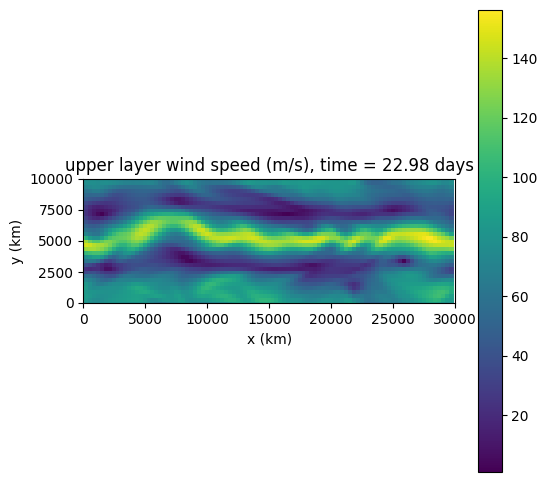

In [ ]:
# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Describe the results in the box below. To what extent are the results qualitatively different from what you saw using the previous script? Comment on the interaction between the jet and the storms. Which features in the simulation do you think occur in the atmosphere? Do you see any features in the simulation that you think are unrealistic? If so, explain why you think those features are unrealistic.

ADD COMMENTS HERE (1-2 PARAGRAPHS). NO NEED FOR PLOTS, BUT YOU CAN INCLUDE THEM IF YOU WANT.

**we have the scenario from part 1 but with a jet added into the initial conditions**

--> plot for various value of beta, u1, and jet width

what we might expect to see...
- bigger beta means the jet overpowers the pre-existing thing
- bigger u1 ?
- wider jet ?

--> we start off with a jet then that turns into eddies but then the jet reforms itself at the end (antidiffusion) --> but try with beta=0 and see that the jet probably doesn't reform

--> $f=f_0+\beta y$

In [ ]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

def simulation_changing_beta(beta_val):
    # Set the non-dimensional parameters
    Nx = 96 # Number of gridpoints in x
    Ny = 32 # Number of gridpoints in y
    Lx = 30e3 # Domain size in x in km
    Ly = 10e3 # Domain size in y in km
    Rd1 = 500 # Deformation radius in layer 1 in km
    Rd2 = 500 # Deformation radius in layer 2 in km
    U1 = 10/1000 # Background velocity in layer 1 in km/s
    U2 = 0 # Background velocity in layer 2 in km/s
    #beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
    jet_width = 200

    #Set the hypervisocisty based on the grid spacing
    delx = Lx/Nx
    nu4 = 1e-6*delx**4

    # Set the timestep based on the CFL criterion
    timestep = 0.5*Lx/Nx/max(U1,U2)/20
    stop_sim_time = 2e6
    timestepper = dedalus.RK443

    # Bases
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
    ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

    # Define the coordinates
    x, y = dist.local_grids(xbasis, ybasis)

    # Define the fields
    # Here psi is the streamfunction and q is the QG potential vorticity
    # "1" corresponds to the upper layer and "2" corresponds to the lower layer
    psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
    psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
    q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
    q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
    u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
    v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
    tau_psi1 = dist.Field(name='tau_psi1')

    # Create functions to use for the initial conditions and forcing
    # Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
    q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
    q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
    q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
    q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

    # Set the initial conditions
    q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
    q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
    # Now, add some random noise
    q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
    q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
    q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
    q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
    q1['g'] += q1p['g']
    q2['g'] += q2p['g']

    # Define the operators that will be used to write the equations
    dx = lambda A: dedalus.Differentiate(A, coords['x'])
    dy = lambda A: dedalus.Differentiate(A, coords['y'])
    lap = lambda A: dedalus.Laplacian(A)
    J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
    integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
    del4 = lambda A: lap(lap(A))

    # Define problem
    problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
    # Define Laplacian and Jacobian operators (to make equations easier to read)

    # Define problem
    problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

    # First, add the two equations for the evolution of the QG potential vorticity
    problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta_val+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1)")
    problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta_val+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2)")
    problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
    problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

    problem.add_equation("u1 = -dy(psi1)")
    problem.add_equation("v1 = dx(psi1)")

    problem.add_equation("integ(psi1) = 0")

    # Now, set the solver
    solver = problem.build_solver(timestepper)
    solver.stop_sim_time = stop_sim_time

    psi1.change_scales(1)
    psi2.change_scales(1)
    q1.change_scales(1)
    q2.change_scales(1)
    psi1_save = [np.copy(psi1['g'])];
    psi2_save = [np.copy(psi2['g'])];
    q1_save = [np.copy(q1['g'])];
    q2_save = [np.copy(q2['g'])];

    # Save the upper layer velocity for later plotting and analysis
    u1.change_scales(1)
    u1_save = [np.copy(u1['g'])]
    v1.change_scales(1)
    v1_save = [np.copy(v1['g'])]

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 20 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                psi1.change_scales(1)
                psi2.change_scales(1)
                psi1_save.append(np.copy(psi1['g']))
                psi2_save.append(np.copy(psi2['g']))
                q1.change_scales(1)
                q2.change_scales(1)
                q1_save.append(np.copy(q1['g']))
                q2_save.append(np.copy(q2['g']))

                u1.change_scales(1)
                u1_save.append(np.copy(u1['g']))
                v1.change_scales(1)
                v1_save.append(np.copy(v1['g']))

                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    psi1_save = np.array(psi1_save)
    psi2_save = np.array(psi2_save)
    q1_save = np.array(q1_save)
    q2_save = np.array(q2_save)
    u1_save = np.array(u1_save)
    v1_save = np.array(v1_save)

    return psi1_save, t_save, x, y


In [ ]:
# Define different H_min values to test
beta_values = [0, 1e-8, 2e-8, 4e-8]
all_results_beta = []

for beta_val in beta_values:
    h_save_data, t_save_data, x_data, y_data = simulation_changing_beta(beta_val)
    all_results_beta.append((h_save_data, t_save_data, x_data, y_data))

INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 14:40:01,668 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.8e+01/s


2025-11-28 14:40:01,819 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 2s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s


2025-11-28 14:40:02,028 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2025-11-28 14:40:02,248 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2025-11-28 14:40:02,434 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


2025-11-28 14:40:02,616 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2025-11-28 14:40:02,822 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2025-11-28 14:40:03,015 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2025-11-28 14:40:03,199 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2025-11-28 14:40:03,398 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


2025-11-28 14:40:03,507 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 14:40:03,516 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 14:40:03,729 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 14:40:04,571 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 14:40:05,147 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 14:40:05,706 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 14:40:06,257 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 14:40:06,855 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 14:40:07,411 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 14:40:07,983 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 14:40:08,537 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 14:40:09,106 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 14:40:09,648 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 14:40:10,211 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 14:40:10,756 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 14:40:11,301 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 14:40:11,869 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 14:40:12,433 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 14:40:12,989 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 14:40:13,579 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 14:40:14,134 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 14:40:14,774 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 14:40:15,684 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 14:40:16,609 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 14:40:17,431 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 14:40:18,018 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 14:40:18,559 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 14:40:19,116 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 14:40:19,645 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 14:40:20,229 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 14:40:20,761 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 14:40:21,314 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 14:40:21,871 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 14:40:22,445 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 14:40:22,995 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 14:40:23,583 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 14:40:24,140 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 14:40:24,697 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 14:40:25,299 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 14:40:25,849 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 14:40:26,711 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 14:40:27,698 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 14:40:28,754 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 14:40:29,759 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 14:40:30,671 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 14:40:31,341 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 14:40:31,900 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 14:40:32,452 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 14:40:33,008 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 14:40:33,545 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 14:40:34,099 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 14:40:34,662 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 14:40:35,307 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 14:40:35,873 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 14:40:36,499 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 14:40:37,060 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 14:40:37,611 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 14:40:38,150 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 14:40:38,677 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 14:40:39,253 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 14:40:39,782 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 14:40:40,355 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 14:40:40,877 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 14:40:41,720 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 14:40:42,644 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 14:40:43,540 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 14:40:44,149 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 14:40:44,705 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 14:40:45,235 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 14:40:45,810 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


/usr/local/lib/python3.12/dist-packages/dedalus/core/arithmetic.py:866: RuntimeWarning: overflow encountered in multiply
  np.multiply(arg0_exp_data, arg1_exp_data, out=out.data)
/usr/local/lib/python3.12/dist-packages/dedalus/core/arithmetic.py:251: RuntimeWarning: invalid value encountered in add
  np.add(arg0.data, arg1.data, out=out.data)
INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 14:40:46,398 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 14:40:46,964 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 14:40:47,506 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 14:40:48,072 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 14:40:48,629 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 14:40:49,160 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 14:40:49,702 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 14:40:50,239 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 14:40:50,787 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 14:40:51,309 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 14:40:51,869 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 14:40:52,417 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 14:40:52,965 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 14:40:53,514 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 14:40:54,352 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 14:40:55,186 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 14:40:56,082 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 14:40:56,677 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 14:40:57,229 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 14:40:57,756 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 14:40:58,304 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 14:40:58,828 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 14:40:59,365 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 14:40:59,885 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 14:41:00,437 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 14:41:00,958 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 14:41:01,523 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 14:41:02,094 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 14:41:02,656 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 14:41:03,187 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 14:41:03,721 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 14:41:04,264 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 14:41:04,815 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 14:41:05,390 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 14:41:05,943 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 14:41:06,663 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 14:41:07,519 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 14:41:08,374 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 14:41:09,180 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 14:41:09,745 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 14:41:10,305 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 14:41:10,903 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 14:41:11,464 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 14:41:12,047 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 14:41:12,595 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 14:41:13,175 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 14:41:13,720 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 14:41:14,298 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 14:41:14,819 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 14:41:15,362 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 14:41:15,922 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 14:41:16,491 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 14:41:17,074 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 14:41:17,624 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 14:41:18,206 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 14:41:18,771 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 14:41:19,539 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 14:41:20,409 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 14:41:21,258 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 14:41:22,004 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 14:41:22,532 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 14:41:22,535 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 14:41:22,539 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.93 sec


2025-11-28 14:41:22,542 solvers 0/1 INFO :: Setup time (init - iter 0): 1.93 sec


INFO:solvers:Warmup time (iter 0-10): 0.6214 sec


2025-11-28 14:41:22,547 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.6214 sec


INFO:solvers:Run time (iter 10-end): 78.4 sec


2025-11-28 14:41:22,550 solvers 0/1 INFO :: Run time (iter 10-end): 78.4 sec


INFO:solvers:CPU time (iter 10-end): 0.02178 cpu-hr


2025-11-28 14:41:22,553 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02178 cpu-hr


INFO:solvers:Speed: 2.299e+06 mode-stages/cpu-sec


2025-11-28 14:41:22,556 solvers 0/1 INFO :: Speed: 2.299e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.3e+01/s


2025-11-28 14:41:22,694 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.3e+01/s


2025-11-28 14:41:22,816 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.3e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2025-11-28 14:41:22,961 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 14:41:23,088 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 14:41:23,225 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 14:41:23,380 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 14:41:23,509 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 14:41:23,632 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 14:41:23,775 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 14:41:23,902 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 14:41:23,984 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 14:41:23,994 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 14:41:24,131 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 14:41:24,672 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 14:41:25,209 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 14:41:25,763 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 14:41:26,322 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 14:41:26,889 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 14:41:27,450 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 14:41:28,023 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 14:41:28,659 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 14:41:29,211 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 14:41:29,775 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 14:41:30,329 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 14:41:30,867 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 14:41:31,408 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 14:41:32,148 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 14:41:33,013 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 14:41:33,816 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 14:41:34,547 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 14:41:35,098 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 14:41:35,616 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 14:41:36,183 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 14:41:36,742 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 14:41:37,258 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 14:41:37,774 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 14:41:38,306 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 14:41:38,815 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 14:41:39,348 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 14:41:39,861 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 14:41:40,405 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 14:41:40,956 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 14:41:41,526 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 14:41:42,051 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 14:41:42,600 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 14:41:43,142 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 14:41:43,662 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 14:41:44,201 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 14:41:45,003 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 14:41:45,811 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 14:41:46,684 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 14:41:47,303 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 14:41:47,837 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 14:41:48,343 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 14:41:48,886 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 14:41:49,408 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 14:41:49,966 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 14:41:50,506 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 14:41:51,017 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 14:41:51,557 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 14:41:52,097 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 14:41:52,643 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 14:41:53,195 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 14:41:53,737 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 14:41:54,309 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 14:41:54,856 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 14:41:55,374 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 14:41:55,935 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 14:41:56,453 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 14:41:57,000 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 14:41:57,845 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 14:41:58,664 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 14:41:59,549 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 14:42:00,115 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 14:42:00,652 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 14:42:01,187 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 14:42:01,699 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 14:42:02,282 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 14:42:02,797 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 14:42:03,333 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 14:42:03,853 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 14:42:04,430 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 14:42:04,962 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 14:42:05,518 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 14:42:06,094 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 14:42:06,665 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 14:42:07,251 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 14:42:07,781 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 14:42:08,332 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 14:42:08,844 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 14:42:09,382 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 14:42:10,121 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 14:42:10,969 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 14:42:11,844 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 14:42:12,627 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 14:42:13,193 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 14:42:13,730 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 14:42:14,258 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 14:42:14,817 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 14:42:15,351 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 14:42:15,915 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 14:42:16,463 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 14:42:16,995 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 14:42:17,524 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 14:42:18,055 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 14:42:18,589 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 14:42:19,147 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 14:42:19,673 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 14:42:20,233 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 14:42:20,771 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 14:42:21,291 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 14:42:21,830 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 14:42:22,421 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 14:42:23,280 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 14:42:24,108 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 14:42:24,952 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 14:42:25,515 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 14:42:26,073 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 14:42:26,630 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 14:42:27,191 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 14:42:27,751 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 14:42:28,304 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 14:42:28,851 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 14:42:29,399 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 14:42:29,946 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 14:42:30,539 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 14:42:31,075 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 14:42:31,629 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 14:42:32,181 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 14:42:32,748 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 14:42:33,287 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 14:42:33,827 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 14:42:34,418 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 14:42:34,986 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 14:42:35,853 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 14:42:36,724 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 14:42:37,636 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 14:42:38,211 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 14:42:38,787 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 14:42:39,371 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 14:42:39,891 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 14:42:39,893 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 14:42:39,896 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.389 sec


2025-11-28 14:42:39,899 solvers 0/1 INFO :: Setup time (init - iter 0): 1.389 sec


INFO:solvers:Warmup time (iter 0-10): 0.3977 sec


2025-11-28 14:42:39,901 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3977 sec


INFO:solvers:Run time (iter 10-end): 75.5 sec


2025-11-28 14:42:39,905 solvers 0/1 INFO :: Run time (iter 10-end): 75.5 sec


INFO:solvers:CPU time (iter 10-end): 0.02097 cpu-hr


2025-11-28 14:42:39,910 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02097 cpu-hr


INFO:solvers:Speed: 2.387e+06 mode-stages/cpu-sec


2025-11-28 14:42:39,913 solvers 0/1 INFO :: Speed: 2.387e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 14:42:40,058 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 14:42:40,164 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 14:42:40,299 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 14:42:40,434 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 14:42:40,564 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 14:42:40,692 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 14:42:40,836 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 14:42:40,978 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 14:42:41,111 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 14:42:41,239 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 14:42:41,324 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:__main__:Starting main loop


2025-11-28 14:42:41,334 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 14:42:41,475 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 14:42:42,021 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 14:42:42,586 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 14:42:43,133 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 14:42:43,677 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 14:42:44,248 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 14:42:44,800 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 14:42:45,367 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 14:42:45,898 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 14:42:46,461 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 14:42:46,996 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 14:42:47,534 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 14:42:48,417 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 14:42:49,244 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 14:42:50,115 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 14:42:50,718 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 14:42:51,253 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 14:42:51,780 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 14:42:52,348 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 14:42:52,906 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 14:42:53,455 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 14:42:53,981 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 14:42:54,519 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 14:42:55,035 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 14:42:55,555 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 14:42:56,074 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 14:42:56,610 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 14:42:57,142 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 14:42:57,716 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 14:42:58,265 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 14:42:58,800 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 14:42:59,319 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 14:42:59,849 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 14:43:00,469 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 14:43:01,342 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 14:43:02,158 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 14:43:03,034 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 14:43:03,626 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 14:43:04,163 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 14:43:04,681 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 14:43:05,280 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 14:43:05,851 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 14:43:06,407 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 14:43:06,957 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 14:43:07,496 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 14:43:08,034 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 14:43:08,570 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 14:43:09,146 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 14:43:09,674 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 14:43:10,229 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 14:43:10,753 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 14:43:11,340 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 14:43:11,872 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 14:43:12,438 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 14:43:13,013 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 14:43:13,876 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 14:43:14,697 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 14:43:15,575 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 14:43:16,129 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 14:43:16,656 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 14:43:17,185 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 14:43:17,718 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 14:43:18,242 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 14:43:18,768 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 14:43:19,295 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 14:43:19,838 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 14:43:20,377 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 14:43:20,931 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 14:43:21,459 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 14:43:22,043 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 14:43:22,593 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 14:43:23,153 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 14:43:23,707 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 14:43:24,291 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 14:43:24,830 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 14:43:25,384 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 14:43:26,118 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 14:43:26,981 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 14:43:27,844 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 14:43:28,596 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 14:43:29,157 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 14:43:29,679 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 14:43:30,235 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 14:43:30,754 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 14:43:31,306 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 14:43:31,831 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 14:43:32,366 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 14:43:32,922 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 14:43:33,461 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 14:43:34,000 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 14:43:34,566 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 14:43:35,122 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 14:43:35,729 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 14:43:36,305 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 14:43:36,869 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 14:43:37,522 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 14:43:38,085 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 14:43:38,858 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 14:43:39,740 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 14:43:40,595 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 14:43:41,303 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 14:43:41,862 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 14:43:42,398 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 14:43:42,971 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 14:43:43,501 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 14:43:44,071 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 14:43:44,599 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 14:43:45,155 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 14:43:45,668 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 14:43:46,214 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 14:43:46,746 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 14:43:47,353 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 14:43:47,916 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 14:43:48,459 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 14:43:49,020 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 14:43:49,542 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 14:43:50,098 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 14:43:50,628 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 14:43:51,270 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 14:43:52,128 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 14:43:52,998 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 14:43:53,796 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 14:43:54,384 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 14:43:54,922 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 14:43:55,470 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 14:43:56,008 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 14:43:56,560 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 14:43:57,093 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 14:43:57,679 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 14:43:57,683 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 14:43:57,686 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.362 sec


2025-11-28 14:43:57,689 solvers 0/1 INFO :: Setup time (init - iter 0): 1.362 sec


INFO:solvers:Warmup time (iter 0-10): 0.3882 sec


2025-11-28 14:43:57,692 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3882 sec


INFO:solvers:Run time (iter 10-end): 75.96 sec


2025-11-28 14:43:57,695 solvers 0/1 INFO :: Run time (iter 10-end): 75.96 sec


INFO:solvers:CPU time (iter 10-end): 0.0211 cpu-hr


2025-11-28 14:43:57,699 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0211 cpu-hr


INFO:solvers:Speed: 2.373e+06 mode-stages/cpu-sec


2025-11-28 14:43:57,703 solvers 0/1 INFO :: Speed: 2.373e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 14:43:57,852 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 1.1e+01/s


2025-11-28 14:43:58,260 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 4s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


2025-11-28 14:43:58,423 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 1s, Remaining: 2s, Rate: 1.7e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 2.1e+01/s


2025-11-28 14:43:58,555 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


2025-11-28 14:43:58,686 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 2.3e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2025-11-28 14:43:58,817 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


2025-11-28 14:43:58,953 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 2.7e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


2025-11-28 14:43:59,087 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


2025-11-28 14:43:59,231 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.9e+01/s


2025-11-28 14:43:59,368 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 2s, Remaining: 0s, Rate: 2.9e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.9e+01/s


2025-11-28 14:43:59,467 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 2.9e+01/s


INFO:__main__:Starting main loop


2025-11-28 14:43:59,475 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 14:43:59,614 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 14:44:00,160 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 14:44:00,686 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 14:44:01,217 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 14:44:01,745 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 14:44:02,281 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 14:44:02,822 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 14:44:03,346 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 14:44:04,064 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 14:44:04,889 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 14:44:05,727 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 14:44:06,484 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 14:44:07,017 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 14:44:07,551 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 14:44:08,087 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 14:44:08,595 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 14:44:09,125 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 14:44:09,637 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 14:44:10,179 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 14:44:10,699 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 14:44:11,247 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 14:44:11,795 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 14:44:12,356 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 14:44:12,893 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 14:44:13,460 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 14:44:13,997 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 14:44:14,545 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 14:44:15,072 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 14:44:15,604 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 14:44:16,171 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 14:44:16,972 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 14:44:17,809 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 14:44:18,742 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 14:44:19,377 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 14:44:19,934 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 14:44:20,497 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 14:44:21,033 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 14:44:21,577 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 14:44:22,150 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 14:44:22,694 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 14:44:23,244 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 14:44:23,804 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 14:44:24,348 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 14:44:24,875 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 14:44:25,455 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 14:44:26,055 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 14:44:26,586 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 14:44:27,147 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 14:44:27,660 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 14:44:28,216 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 14:44:28,751 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 14:44:29,468 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 14:44:30,313 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 14:44:31,141 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 14:44:31,879 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 14:44:32,434 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 14:44:32,968 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 14:44:33,542 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 14:44:34,109 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 14:44:34,642 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 14:44:35,253 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 14:44:35,794 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 14:44:36,391 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 14:44:36,934 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 14:44:37,527 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 14:44:38,076 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 14:44:38,612 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 14:44:39,135 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 14:44:39,661 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 14:44:40,197 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 14:44:40,772 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 14:44:41,297 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 14:44:41,968 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 14:44:42,862 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 14:44:43,698 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 14:44:44,472 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 14:44:45,019 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 14:44:45,579 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 14:44:46,154 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 14:44:46,706 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 14:44:47,251 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 14:44:47,792 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 14:44:48,324 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 14:44:48,893 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 14:44:49,466 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 14:44:50,049 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 14:44:50,583 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 14:44:51,112 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 14:44:51,610 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 14:44:52,195 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 14:44:52,722 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 14:44:53,267 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 14:44:53,782 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 14:44:54,332 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 14:44:55,199 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 14:44:56,019 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 14:44:56,921 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 14:44:57,540 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 14:44:58,094 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 14:44:58,632 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 14:44:59,168 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 14:44:59,702 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 14:45:00,230 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 14:45:00,776 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 14:45:01,358 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 14:45:01,895 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 14:45:02,441 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 14:45:02,981 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 14:45:03,513 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 14:45:04,055 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 14:45:04,592 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 14:45:05,135 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 14:45:05,677 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 14:45:06,228 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 14:45:06,775 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 14:45:07,500 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 14:45:08,376 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 14:45:09,243 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 14:45:10,034 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 14:45:10,555 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 14:45:11,100 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 14:45:11,621 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 14:45:12,171 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 14:45:12,678 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 14:45:13,227 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 14:45:13,752 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 14:45:14,302 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 14:45:14,811 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 14:45:15,318 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 14:45:15,322 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 14:45:15,324 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.718 sec


2025-11-28 14:45:15,327 solvers 0/1 INFO :: Setup time (init - iter 0): 1.718 sec


INFO:solvers:Warmup time (iter 0-10): 0.3962 sec


2025-11-28 14:45:15,330 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.3962 sec


INFO:solvers:Run time (iter 10-end): 75.45 sec


2025-11-28 14:45:15,333 solvers 0/1 INFO :: Run time (iter 10-end): 75.45 sec


INFO:solvers:CPU time (iter 10-end): 0.02096 cpu-hr


2025-11-28 14:45:15,336 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02096 cpu-hr


INFO:solvers:Speed: 2.389e+06 mode-stages/cpu-sec


2025-11-28 14:45:15,342 solvers 0/1 INFO :: Speed: 2.389e+06 mode-stages/cpu-sec


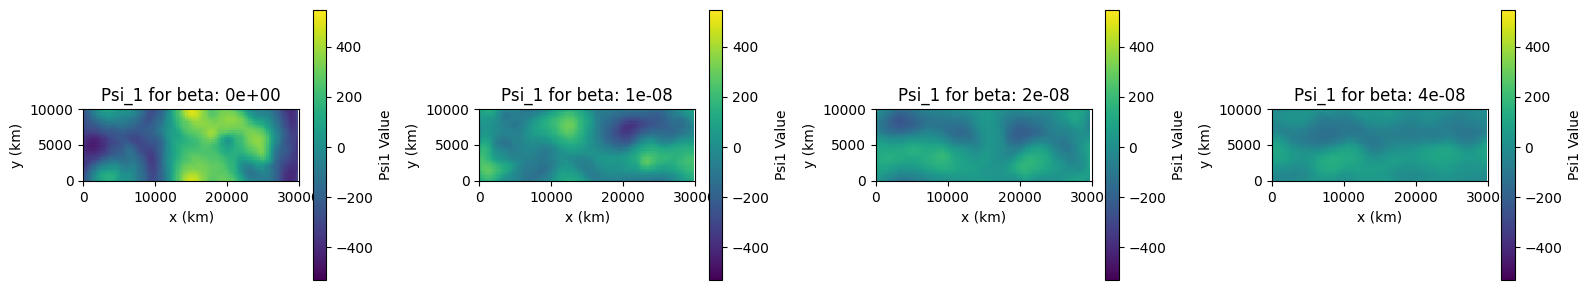

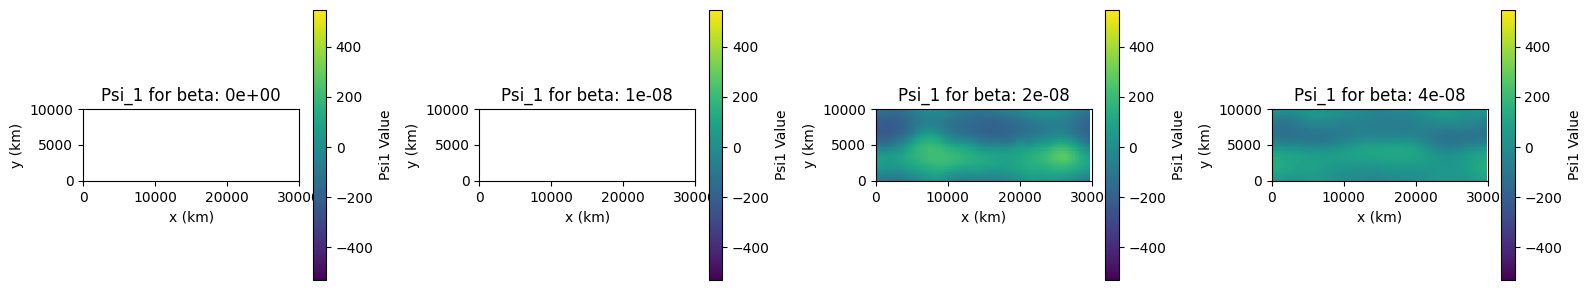

In [ ]:
# Define simulation constants (assuming they are consistent across runs)
Nx = 96
Ny = 32
Lx = 30e3
Ly = 10e3

from dedalus.extras import plot_tools
import numpy as np # Ensure numpy is imported for nanmin/nanmax

# Calculate global min and max for consistent color scaling across all plots
all_h_values_flat = []
for h_save_data, _, _, _ in all_results_beta: # Corrected unpacking here
    all_h_values_flat.append(h_save_data)

# Use np.nanmin and np.nanmax to handle potential NaN values in the data
global_min = np.nanmin([np.nanmin(h) for h in all_h_values_flat])
global_max = np.nanmax([np.nanmax(h) for h in all_h_values_flat])

# First set of plots (middle time step)
fig, axes = plt.subplots(1, len(beta_values), figsize=(4 * len(beta_values), 3), squeeze=False)
axes = axes.flatten()

for i, (beta_val, (h_save_data, t_save_data, x_local, y_local)) in enumerate(zip(beta_values, all_results_beta)):
    ax = axes[i]

    # Ensure t_save_data is a NumPy array for numerical operations
    t_save_data_np = np.array(t_save_data)

    index = int(len(t_save_data_np)/2)
    time_to_plot_seconds = t_save_data_np[index]

    # Plot the height field at the selected time step
    h_final = h_save_data[index, :, :]

    # Use x_local and y_local from the unpacked tuple
    (X, Y) = plot_tools.quad_mesh(np.squeeze(x_local), np.squeeze(y_local))

    # Plot h_final using pcolormesh with global vmin/vmax
    im = ax.pcolormesh(X, Y, h_final.T, cmap='viridis', vmin=global_min, vmax=global_max)

    # Specify the axis limits and labels
    ax.set_aspect('equal') # Maintain aspect ratio
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_xlim(0, Lx) # Use the defined Lx
    ax.set_ylim(0, Ly) # Use the defined Ly
    fig.colorbar(im, ax=ax, label='Psi1 Value') # Add a colorbar
    ax.set_title(f'Psi_1 for beta: {beta_val:.0e}') # Update title

plt.tight_layout()
plt.show()

# Second set of plots (final time step)
fig, axes = plt.subplots(1, len(beta_values), figsize=(4 * len(beta_values), 3), squeeze=False)
axes = axes.flatten()

for i, (beta_val, (h_save_data, t_save_data, x_local, y_local)) in enumerate(zip(beta_values, all_results_beta)):
    ax = axes[i]

    # Ensure t_save_data is a NumPy array for numerical operations
    t_save_data_np = np.array(t_save_data)

    index = len(t_save_data_np)-1
    time_to_plot_seconds = t_save_data_np[index]

    # Plot the height field at the selected time step
    h_final = h_save_data[index, :, :]

    # Use x_local and y_local from the unpacked tuple
    (X, Y) = plot_tools.quad_mesh(np.squeeze(x_local), np.squeeze(y_local))

    # Plot h_final using pcolormesh with global vmin/vmax
    im = ax.pcolormesh(X, Y, h_final.T, cmap='viridis', vmin=global_min, vmax=global_max)

    # Specify the axis limits and labels
    ax.set_aspect('equal') # Maintain aspect ratio
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')
    ax.set_xlim(0, Lx) # Use the defined Lx
    ax.set_ylim(0, Ly) # Use the defined Ly
    fig.colorbar(im, ax=ax, label='Psi1 Value') # Add a colorbar
    ax.set_title(f'Psi_1 for beta: {beta_val:.0e}') # Update title

plt.tight_layout()
plt.show()


**TALK ABOUT WHAT WE SEE !!!!!!!!!!!!!!!!!!**

# 3. Forced QG flow

In the atmosphere, differential heating between the equator and poles maintains a north/south temperature gradient. This temperature gradient is represented by the north/south gradient in layer heights and potential vorticity in the 2-layer QG model. We can represent differential heating and cooling in the 2-layer QG model by adding terms that 'relax' the potential vorticity back to a prescribed field.

### 3.1 Student investigation
<a id='section3pt1'></a>

In the code box below, copy the code from Part 2 and modify it to include the following terms:

$$ \frac{\partial q_1}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_1 - q_1(t=0)\right) $$

$$ \frac{\partial q_2}{\partial t} + \ldots = \ldots - \frac{1}{\tau}\left(q_2 - q_2(t=0)\right) $$

where $q_i(t=0)$ are the initial conditions (q1_ic and q2_ic in the script) and $\tau$ is a timescale which you should specify. A timescale of $\tau=36$ hours should be a good starting point. In the absence of any other terms, this additional forcing term will cause $q_1$ and $q_2$ to 'relax' exponentially back to the initial conditions with an e-folding timescale equal to $\tau$.

Set up a set of numerical experiments to explore the nonlinear interactions between the storms and the jet. For example, you can chose to systematically vary $\tau$, or q1_ic and q2_ic to represent weaker/stronger differential heating. Qualitatively comment on your findings.

**FIRST WE VARY TAU...**

INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s


2025-11-28 16:26:58,445 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.9e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:26:58,555 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:26:58,692 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:26:58,822 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:26:58,957 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:26:59,093 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:26:59,236 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:26:59,371 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:26:59,523 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:26:59,662 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:26:59,748 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:26:59,762 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:26:59,990 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:27:00,571 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:27:01,128 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:27:01,695 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:27:02,267 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:27:03,132 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:27:04,018 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:27:04,947 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:27:05,643 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:27:06,226 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:27:06,784 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:27:07,374 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:27:07,949 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:27:08,490 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:27:09,056 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:27:09,670 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:27:10,240 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:27:10,770 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:27:11,356 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:27:11,916 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:27:12,509 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:27:13,077 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:27:13,625 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:27:14,225 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:27:14,773 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:27:15,454 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:27:16,360 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:27:17,263 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:27:18,179 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:27:18,744 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:27:19,297 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:27:19,860 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:27:20,451 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:27:20,996 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:27:21,571 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:27:22,151 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:27:22,741 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:27:23,600 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:27:24,179 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:27:24,759 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:27:25,324 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:27:25,883 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:27:26,448 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:27:27,004 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:27:27,540 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:27:28,140 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:27:29,070 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:27:29,932 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:27:30,837 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:27:31,418 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:27:31,947 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:27:32,523 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:27:33,092 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:27:33,678 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:27:34,317 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:27:34,908 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:27:35,524 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:27:36,076 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:27:36,727 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:27:37,326 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:27:37,879 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:27:38,451 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:27:39,016 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:27:39,585 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:27:40,136 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:27:40,720 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:27:41,511 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:27:42,414 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:27:43,331 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:27:44,072 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:27:44,660 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:27:45,243 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:27:45,832 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:27:46,471 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:27:47,111 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:27:47,688 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:27:48,295 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:27:48,874 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:27:49,433 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:27:50,010 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:27:50,610 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:27:51,231 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:27:51,831 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:27:52,436 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:27:53,032 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:27:53,590 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:27:54,460 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:27:55,328 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:27:56,240 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:27:56,932 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:27:57,525 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:27:58,096 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:27:58,679 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:27:59,310 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:27:59,873 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:28:00,453 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:28:01,008 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:28:01,574 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:28:02,128 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:28:02,708 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:28:03,305 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:28:03,886 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:28:04,461 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:28:05,062 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:28:05,652 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:28:06,215 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:28:06,923 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:28:07,868 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:28:08,748 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:28:09,573 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:28:10,164 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:28:10,752 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:28:11,312 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:28:11,861 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:28:12,453 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:28:13,075 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:28:13,658 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:28:14,238 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:28:14,790 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:28:15,381 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:28:15,953 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:28:16,537 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:28:17,115 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:28:17,667 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:28:18,261 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:28:18,827 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:28:19,415 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:28:20,329 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:28:21,866 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:28:21,877 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:28:21,892 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.426 sec


2025-11-28 16:28:21,900 solvers 0/1 INFO :: Setup time (init - iter 0): 1.426 sec


INFO:solvers:Warmup time (iter 0-10): 0.4877 sec


2025-11-28 16:28:21,918 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4877 sec


INFO:solvers:Run time (iter 10-end): 81.62 sec


2025-11-28 16:28:21,939 solvers 0/1 INFO :: Run time (iter 10-end): 81.62 sec


INFO:solvers:CPU time (iter 10-end): 0.02267 cpu-hr


2025-11-28 16:28:21,952 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02267 cpu-hr


INFO:solvers:Speed: 2.208e+06 mode-stages/cpu-sec


2025-11-28 16:28:21,968 solvers 0/1 INFO :: Speed: 2.208e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:28:23,044 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpo3f8hymf/temp.m4v


2025-11-28 16:28:23,047 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpo3f8hymf/temp.m4v


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:28:51,354 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


2025-11-28 16:28:51,457 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:28:51,588 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


2025-11-28 16:28:51,714 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:28:51,881 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:28:52,021 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:28:52,152 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:28:52,284 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:28:52,417 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:28:52,551 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.3e+01/s


2025-11-28 16:28:52,788 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.3e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:28:52,803 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:28:53,047 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:28:53,616 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:28:54,206 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:28:54,782 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:28:55,359 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:28:55,927 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:28:56,522 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:28:57,113 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:28:57,668 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:28:58,431 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:28:59,394 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:29:00,327 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:29:01,051 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:29:01,633 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:29:02,201 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:29:02,796 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:29:03,428 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:29:03,997 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:29:04,588 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:29:05,168 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:29:05,742 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:29:06,302 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:29:06,880 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:29:07,441 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:29:08,034 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:29:08,662 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:29:09,234 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:29:09,807 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:29:10,399 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:29:11,160 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:29:12,044 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:29:12,951 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:29:13,730 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:29:14,376 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:29:14,934 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:29:15,493 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:29:16,102 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:29:16,694 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:29:17,297 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:29:17,873 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:29:18,481 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:29:19,039 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:29:19,628 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:29:20,251 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:29:20,800 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:29:21,373 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:29:21,923 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:29:22,546 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:29:23,117 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:29:23,809 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:29:24,800 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:29:25,731 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:29:26,526 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:29:27,116 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:29:27,697 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:29:28,291 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:29:28,862 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:29:29,436 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:29:30,021 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:29:30,600 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:29:31,153 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:29:31,732 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:29:32,340 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:29:32,934 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:29:33,527 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:29:34,132 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:29:34,756 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:29:35,343 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:29:35,936 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:29:36,698 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:29:37,594 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:29:38,549 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:29:39,286 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:29:39,830 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:29:40,430 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:29:41,006 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:29:41,595 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:29:42,184 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:29:42,762 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:29:43,363 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:29:43,915 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:29:44,556 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:29:45,115 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:29:45,688 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:29:46,255 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:29:46,820 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:29:47,395 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:29:47,952 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:29:48,524 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:29:49,187 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:29:50,103 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:29:50,983 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:29:51,881 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:29:52,461 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:29:53,081 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:29:53,637 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:29:54,226 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:29:54,817 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:29:55,385 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:29:55,965 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:29:56,544 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:29:57,152 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:29:57,735 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:29:58,353 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:29:58,914 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:29:59,506 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:30:00,098 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:30:00,669 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:30:01,295 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:30:01,960 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:30:02,865 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:30:03,783 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:30:04,703 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:30:05,323 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:30:05,907 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:30:06,498 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:30:07,066 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:30:07,642 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:30:08,237 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:30:08,812 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:30:09,376 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:30:09,943 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:30:10,563 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:30:11,127 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:30:11,719 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:30:12,302 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:30:12,899 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:30:13,500 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:30:14,058 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:30:14,061 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:30:14,063 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.532 sec


2025-11-28 16:30:14,066 solvers 0/1 INFO :: Setup time (init - iter 0): 1.532 sec


INFO:solvers:Warmup time (iter 0-10): 0.5031 sec


2025-11-28 16:30:14,069 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.5031 sec


INFO:solvers:Run time (iter 10-end): 80.75 sec


2025-11-28 16:30:14,074 solvers 0/1 INFO :: Run time (iter 10-end): 80.75 sec


INFO:solvers:CPU time (iter 10-end): 0.02243 cpu-hr


2025-11-28 16:30:14,078 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02243 cpu-hr


INFO:solvers:Speed: 2.232e+06 mode-stages/cpu-sec


2025-11-28 16:30:14,080 solvers 0/1 INFO :: Speed: 2.232e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:30:14,215 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8ubjxsjg/temp.m4v


2025-11-28 16:30:14,218 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp8ubjxsjg/temp.m4v


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:30:43,446 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:30:43,555 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:30:43,685 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:30:43,828 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:30:43,968 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:30:44,119 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:30:44,258 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:30:44,392 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:30:44,524 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:30:44,660 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:30:44,746 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:30:44,756 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:30:44,933 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:30:45,533 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:30:46,130 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:30:46,721 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:30:47,339 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:30:48,003 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:30:48,625 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:30:49,253 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:30:49,897 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:30:50,529 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:30:51,141 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:30:51,738 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:30:52,318 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:30:52,917 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:30:53,902 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:30:54,797 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:30:55,788 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:30:56,429 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:30:57,061 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:30:57,653 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:30:58,302 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:30:58,905 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:30:59,491 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:31:00,078 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:31:00,657 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:31:01,258 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:31:01,836 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:31:02,438 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:31:03,048 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:31:03,639 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:31:04,242 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:31:04,838 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:31:05,498 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:31:06,265 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:31:07,212 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:31:08,145 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:31:08,992 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:31:09,588 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:31:10,180 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:31:10,795 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:31:11,418 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:31:12,031 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:31:12,637 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:31:13,242 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:31:13,843 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:31:14,433 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:31:15,054 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:31:15,693 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:31:16,303 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:31:16,897 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:31:17,531 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:31:18,126 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:31:18,726 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:31:19,637 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:31:20,541 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:31:21,583 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:31:22,261 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:31:22,880 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:31:23,523 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:31:24,143 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:31:24,737 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:31:25,379 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:31:25,965 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:31:26,573 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:31:27,186 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:31:27,782 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:31:28,402 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:31:28,994 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:31:29,593 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:31:30,186 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:31:30,804 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:31:31,401 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:31:32,193 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:31:33,115 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:31:34,067 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:31:34,840 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:31:35,424 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:31:36,030 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:31:36,629 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:31:37,217 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:31:37,801 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:31:38,389 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:31:38,992 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:31:39,580 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:31:40,197 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:31:40,785 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:31:41,369 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:31:41,979 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:31:42,573 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:31:43,233 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:31:43,831 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:31:44,462 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:31:45,433 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:31:46,480 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:31:47,462 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:31:48,038 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:31:48,644 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:31:49,225 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:31:49,806 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:31:50,428 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:31:51,060 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:31:51,656 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:31:52,259 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:31:52,863 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:31:53,498 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:31:54,082 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:31:54,684 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:31:55,291 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:31:55,890 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:31:56,581 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:31:57,216 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:31:58,140 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:31:59,046 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:32:00,002 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:32:00,655 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:32:01,236 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:32:01,790 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:32:02,377 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:32:02,959 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:32:03,523 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:32:04,105 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:32:04,679 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:32:05,294 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:32:05,894 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:32:06,506 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:32:07,108 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:32:07,688 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:32:08,295 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:32:08,853 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:32:08,855 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:32:08,857 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.391 sec


2025-11-28 16:32:08,860 solvers 0/1 INFO :: Setup time (init - iter 0): 1.391 sec


INFO:solvers:Warmup time (iter 0-10): 0.4666 sec


2025-11-28 16:32:08,861 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4666 sec


INFO:solvers:Run time (iter 10-end): 83.63 sec


2025-11-28 16:32:08,864 solvers 0/1 INFO :: Run time (iter 10-end): 83.63 sec


INFO:solvers:CPU time (iter 10-end): 0.02323 cpu-hr


2025-11-28 16:32:08,867 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02323 cpu-hr


INFO:solvers:Speed: 2.155e+06 mode-stages/cpu-sec


2025-11-28 16:32:08,868 solvers 0/1 INFO :: Speed: 2.155e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:32:09,026 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_ub4zscy/temp.m4v


2025-11-28 16:32:09,030 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_ub4zscy/temp.m4v


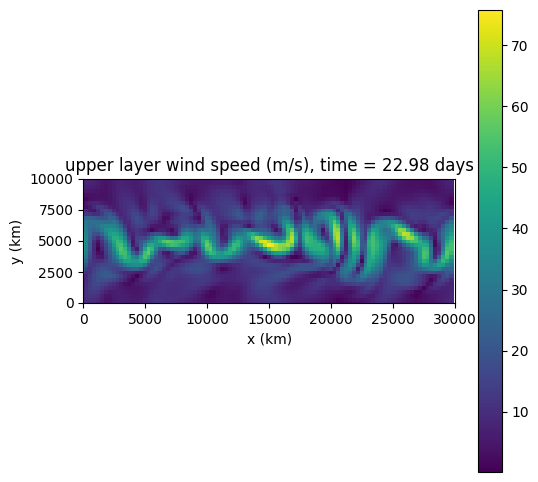

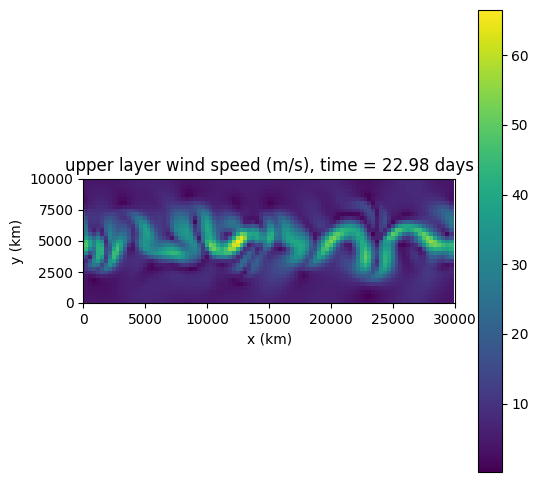

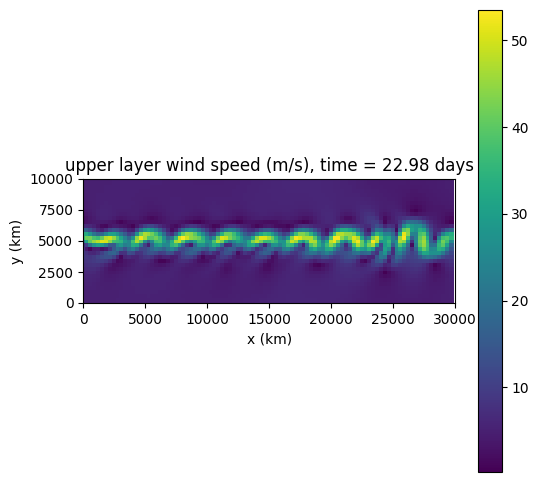

In [ ]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 72 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 18 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**The plots above show the flow for $\tau = 72, 36, 18$.**

**THEN WE VARY q1_ic...**

INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:43:29,511 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:43:29,622 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2025-11-28 16:43:29,777 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:29,910 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:30,056 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:30,193 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:30,330 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,466 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,595 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,750 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,833 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:43:30,843 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:43:31,062 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:43:31,659 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:43:32,281 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:43:32,895 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:43:33,486 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:43:34,098 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:43:34,697 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:43:35,508 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:43:36,453 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:43:37,423 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:43:38,162 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:43:38,740 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:43:39,335 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:43:39,917 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:43:40,520 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:43:41,124 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:43:41,725 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:43:42,321 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:43:42,895 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:43:43,512 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:43:44,121 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:43:44,715 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:43:45,303 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:43:45,874 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:43:46,505 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:43:47,144 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:43:47,748 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:43:48,686 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:43:49,597 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:43:50,570 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:43:51,192 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:43:51,821 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:43:52,427 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:43:53,054 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:43:53,618 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:43:54,211 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:43:54,827 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:43:55,733 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:43:56,361 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:43:56,941 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:43:57,526 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:43:58,146 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:43:58,739 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:43:59,345 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:43:59,944 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:44:00,537 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:44:01,441 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:44:02,353 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:44:03,328 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:44:04,271 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:44:04,847 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:44:05,465 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:44:06,051 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:44:06,657 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:44:07,249 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:44:07,879 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:44:08,491 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:44:09,124 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:44:09,706 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:44:10,286 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:44:10,879 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:44:11,457 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:44:12,066 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:44:12,655 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:44:13,275 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:44:14,097 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:44:15,020 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:44:15,914 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:44:16,626 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:44:17,241 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:44:17,785 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:44:18,364 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:44:18,955 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:44:19,538 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:44:20,161 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:44:20,734 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:44:21,319 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:44:21,920 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:44:22,534 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:44:23,113 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:44:23,718 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:44:24,329 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:44:24,889 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:44:25,512 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:44:26,096 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:44:26,923 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:44:27,834 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:44:28,860 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:44:29,556 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:44:30,146 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:44:30,762 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:44:31,383 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:44:31,975 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:44:32,570 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:44:33,144 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:44:33,699 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:44:34,294 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:44:34,857 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:44:35,450 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:44:36,052 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:44:36,617 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:44:37,236 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:44:37,813 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:44:38,419 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:44:39,029 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:44:39,886 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:44:40,786 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:44:41,736 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:44:42,405 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:44:42,978 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:44:43,556 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:44:44,131 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:44:44,701 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:44:45,283 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:44:45,845 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:44:46,442 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:44:47,050 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:44:47,643 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:44:48,261 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:44:48,868 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:44:49,505 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:44:50,094 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:44:50,687 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:44:51,254 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:44:51,831 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:44:52,722 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:44:53,597 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:44:54,553 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:44:55,190 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:44:55,192 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:44:55,195 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.416 sec


2025-11-28 16:44:55,198 solvers 0/1 INFO :: Setup time (init - iter 0): 1.416 sec


INFO:solvers:Warmup time (iter 0-10): 0.4936 sec


2025-11-28 16:44:55,202 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4936 sec


INFO:solvers:Run time (iter 10-end): 83.85 sec


2025-11-28 16:44:55,205 solvers 0/1 INFO :: Run time (iter 10-end): 83.85 sec


INFO:solvers:CPU time (iter 10-end): 0.02329 cpu-hr


2025-11-28 16:44:55,208 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02329 cpu-hr


INFO:solvers:Speed: 2.15e+06 mode-stages/cpu-sec


2025-11-28 16:44:55,211 solvers 0/1 INFO :: Speed: 2.15e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:44:55,335 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpgbnccbss/temp.m4v


2025-11-28 16:44:55,337 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpgbnccbss/temp.m4v


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:45:24,390 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:24,495 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


2025-11-28 16:45:24,617 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:24,756 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:24,891 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:25,028 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,165 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,302 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,439 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,567 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,671 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:45:25,682 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:45:25,850 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:45:26,465 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:45:27,034 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:45:27,644 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:45:28,268 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:45:28,877 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:45:29,486 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:45:30,070 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:45:30,844 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:45:31,782 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:45:32,741 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:45:33,530 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:45:34,140 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:45:34,741 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:45:35,327 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:45:35,925 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:45:36,502 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:45:37,105 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:45:37,695 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:45:38,285 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:45:38,882 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:45:39,465 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:45:40,069 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:45:40,712 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:45:41,312 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:45:41,899 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:45:42,502 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:45:43,100 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:45:43,970 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:45:44,942 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:45:45,947 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:45:46,588 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:45:47,172 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:45:47,776 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:45:48,381 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:45:48,961 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:45:49,536 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:45:50,116 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:45:50,702 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:45:51,259 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:45:51,884 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:45:52,485 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:45:53,052 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:45:53,633 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:45:54,222 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:45:54,817 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:45:55,390 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:45:56,092 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:45:57,028 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:45:57,915 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:45:58,878 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:45:59,473 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:46:00,057 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:46:00,636 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:46:01,255 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:46:01,835 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:46:02,482 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:46:03,047 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:46:03,602 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:46:04,204 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:46:04,796 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:46:05,406 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:46:05,971 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:46:06,578 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:46:07,206 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:46:07,798 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:46:08,384 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:46:08,943 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:46:09,898 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:46:10,781 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:46:11,739 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:46:12,340 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:46:12,922 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:46:13,515 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:46:14,085 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:46:14,658 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:46:15,215 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:46:15,807 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:46:16,377 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:46:16,945 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:46:17,528 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:46:18,175 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:46:18,774 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:46:19,351 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:46:19,960 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:46:20,534 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:46:21,120 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:46:21,721 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:46:22,646 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:46:23,566 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:46:24,554 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:46:25,164 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:46:25,743 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:46:26,381 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:46:26,955 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:46:27,554 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:46:28,171 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:46:28,739 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:46:29,323 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:46:29,897 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:46:30,556 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:46:31,184 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:46:31,748 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:46:32,359 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:46:32,909 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:46:33,501 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:46:34,076 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:46:34,772 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:46:35,685 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:46:36,645 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:46:37,558 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:46:38,158 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:46:38,748 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:46:39,311 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:46:39,867 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:46:40,428 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:46:41,016 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:46:41,602 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:46:42,217 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:46:42,825 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:46:43,385 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:46:43,988 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:46:44,563 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:46:45,158 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:46:45,706 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:46:46,298 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:46:46,865 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:46:47,460 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:46:48,375 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:46:48,376 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:46:48,377 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.374 sec


2025-11-28 16:46:48,378 solvers 0/1 INFO :: Setup time (init - iter 0): 1.374 sec


INFO:solvers:Warmup time (iter 0-10): 0.4415 sec


2025-11-28 16:46:48,379 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4415 sec


INFO:solvers:Run time (iter 10-end): 82.25 sec


2025-11-28 16:46:48,381 solvers 0/1 INFO :: Run time (iter 10-end): 82.25 sec


INFO:solvers:CPU time (iter 10-end): 0.02285 cpu-hr


2025-11-28 16:46:48,382 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02285 cpu-hr


INFO:solvers:Speed: 2.191e+06 mode-stages/cpu-sec


2025-11-28 16:46:48,383 solvers 0/1 INFO :: Speed: 2.191e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:46:48,545 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9vm_j2sz/temp.m4v


2025-11-28 16:46:48,547 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9vm_j2sz/temp.m4v


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2025-11-28 16:47:18,150 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:47:18,256 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:47:18,405 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:47:18,538 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:47:18,671 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:47:18,809 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:18,950 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,084 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,222 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,376 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,461 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:47:19,472 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:47:19,676 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:47:20,280 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:47:20,880 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:47:21,481 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:47:22,057 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:47:22,665 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:47:23,268 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:47:23,873 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:47:24,471 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:47:25,073 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:47:25,687 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:47:26,474 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:47:27,434 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:47:28,394 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:47:29,234 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:47:29,867 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:47:30,500 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:47:31,137 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:47:31,739 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:47:32,369 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:47:32,959 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:47:33,561 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:47:34,167 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:47:34,748 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:47:35,343 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:47:35,925 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:47:36,544 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:47:37,097 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:47:37,661 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:47:38,257 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:47:38,847 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:47:39,757 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:47:40,701 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:47:41,720 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:47:42,352 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:47:42,986 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:47:43,600 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:47:44,233 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:47:44,851 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:47:45,466 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:47:46,107 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:47:46,739 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:47:47,360 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:47:47,985 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:47:48,605 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:47:49,229 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:47:49,846 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:47:50,458 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:47:51,080 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:47:51,679 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:47:52,628 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:47:53,547 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:47:54,550 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:47:55,208 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:47:55,823 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:47:56,504 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:47:57,134 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:47:57,708 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:47:58,333 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:47:58,929 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:47:59,509 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:48:00,105 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:48:00,703 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:48:01,310 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:48:01,887 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:48:02,492 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:48:03,061 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:48:03,687 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:48:04,295 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:48:05,095 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:48:06,029 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:48:06,971 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:48:07,733 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:48:08,300 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:48:08,859 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:48:09,424 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:48:10,000 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:48:10,570 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:48:11,154 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:48:11,742 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:48:12,355 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:48:12,946 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:48:13,538 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:48:14,138 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:48:14,722 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:48:15,310 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:48:15,883 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:48:16,497 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:48:17,107 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:48:17,828 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:48:18,749 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:48:19,655 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:48:20,497 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:48:21,062 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:48:21,654 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:48:22,235 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:48:22,809 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:48:23,400 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:48:23,984 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:48:24,589 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:48:25,177 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:48:25,785 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:48:26,435 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:48:27,019 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:48:27,631 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:48:28,258 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:48:28,903 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:48:29,483 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:48:30,114 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:48:30,985 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:48:31,972 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:48:32,936 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:48:33,574 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:48:34,166 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:48:34,738 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:48:35,345 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:48:35,932 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:48:36,553 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:48:37,145 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:48:37,734 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:48:38,343 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:48:38,922 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:48:39,540 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:48:40,157 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:48:40,737 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:48:41,330 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:48:41,897 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:48:42,498 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:48:43,045 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:48:43,047 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:48:43,049 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.404 sec


2025-11-28 16:48:43,054 solvers 0/1 INFO :: Setup time (init - iter 0): 1.404 sec


INFO:solvers:Warmup time (iter 0-10): 0.4801 sec


2025-11-28 16:48:43,057 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4801 sec


INFO:solvers:Run time (iter 10-end): 83.09 sec


2025-11-28 16:48:43,061 solvers 0/1 INFO :: Run time (iter 10-end): 83.09 sec


INFO:solvers:CPU time (iter 10-end): 0.02308 cpu-hr


2025-11-28 16:48:43,063 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02308 cpu-hr


INFO:solvers:Speed: 2.169e+06 mode-stages/cpu-sec


2025-11-28 16:48:43,066 solvers 0/1 INFO :: Speed: 2.169e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:48:43,276 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsj1oohnh/temp.m4v


2025-11-28 16:48:43,278 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsj1oohnh/temp.m4v


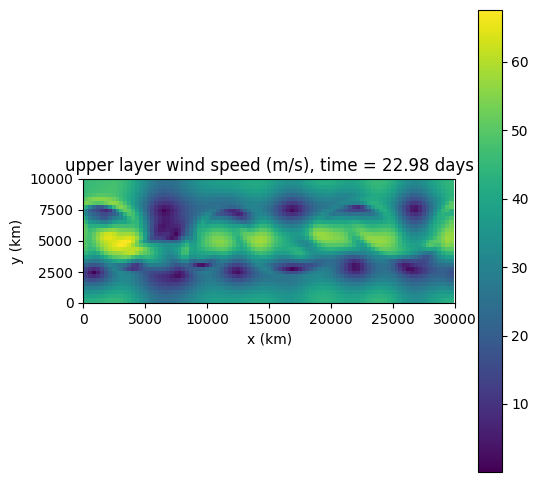

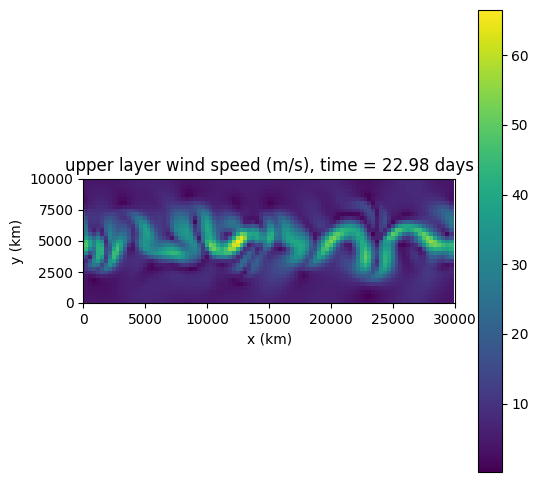

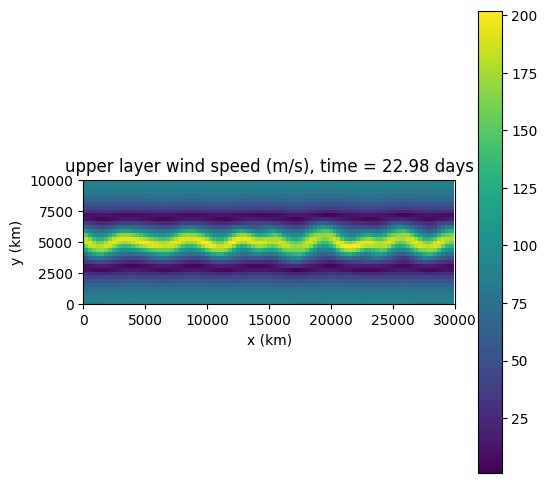

In [ ]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = ((Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2)))/2   # q1_ic DIVIDED BY 2
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = ((Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2)))*2      # q1_ic MULTIPLIED BY 2
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**plots above show a range of q1_ic - specifically baseline/2, baseline, baseline*2**

**THEN WE VARY q2_ic...**

INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:43:29,511 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:43:29,622 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2025-11-28 16:43:29,777 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:29,910 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:30,056 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:30,193 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:43:30,330 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,466 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,595 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,750 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:43:30,833 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:43:30,843 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:43:31,062 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:43:31,659 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:43:32,281 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:43:32,895 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:43:33,486 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:43:34,098 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:43:34,697 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:43:35,508 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:43:36,453 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:43:37,423 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:43:38,162 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:43:38,740 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:43:39,335 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:43:39,917 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:43:40,520 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:43:41,124 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:43:41,725 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:43:42,321 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:43:42,895 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:43:43,512 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:43:44,121 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:43:44,715 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:43:45,303 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:43:45,874 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:43:46,505 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:43:47,144 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:43:47,748 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:43:48,686 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:43:49,597 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:43:50,570 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:43:51,192 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:43:51,821 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:43:52,427 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:43:53,054 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:43:53,618 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:43:54,211 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:43:54,827 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:43:55,733 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:43:56,361 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:43:56,941 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:43:57,526 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:43:58,146 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:43:58,739 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:43:59,345 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:43:59,944 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:44:00,537 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:44:01,441 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:44:02,353 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:44:03,328 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:44:04,271 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:44:04,847 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:44:05,465 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:44:06,051 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:44:06,657 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:44:07,249 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:44:07,879 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:44:08,491 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:44:09,124 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:44:09,706 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:44:10,286 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:44:10,879 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:44:11,457 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:44:12,066 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:44:12,655 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:44:13,275 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:44:14,097 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:44:15,020 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:44:15,914 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:44:16,626 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:44:17,241 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:44:17,785 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:44:18,364 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:44:18,955 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:44:19,538 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:44:20,161 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:44:20,734 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:44:21,319 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:44:21,920 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:44:22,534 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:44:23,113 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:44:23,718 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:44:24,329 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:44:24,889 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:44:25,512 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:44:26,096 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:44:26,923 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:44:27,834 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:44:28,860 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:44:29,556 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:44:30,146 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:44:30,762 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:44:31,383 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:44:31,975 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:44:32,570 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:44:33,144 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:44:33,699 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:44:34,294 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:44:34,857 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:44:35,450 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:44:36,052 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:44:36,617 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:44:37,236 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:44:37,813 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:44:38,419 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:44:39,029 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:44:39,886 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:44:40,786 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:44:41,736 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:44:42,405 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:44:42,978 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:44:43,556 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:44:44,131 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:44:44,701 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:44:45,283 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:44:45,845 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:44:46,442 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:44:47,050 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:44:47,643 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:44:48,261 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:44:48,868 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:44:49,505 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:44:50,094 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:44:50,687 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:44:51,254 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:44:51,831 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:44:52,722 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:44:53,597 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:44:54,553 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:44:55,190 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:44:55,192 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:44:55,195 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.416 sec


2025-11-28 16:44:55,198 solvers 0/1 INFO :: Setup time (init - iter 0): 1.416 sec


INFO:solvers:Warmup time (iter 0-10): 0.4936 sec


2025-11-28 16:44:55,202 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4936 sec


INFO:solvers:Run time (iter 10-end): 83.85 sec


2025-11-28 16:44:55,205 solvers 0/1 INFO :: Run time (iter 10-end): 83.85 sec


INFO:solvers:CPU time (iter 10-end): 0.02329 cpu-hr


2025-11-28 16:44:55,208 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02329 cpu-hr


INFO:solvers:Speed: 2.15e+06 mode-stages/cpu-sec


2025-11-28 16:44:55,211 solvers 0/1 INFO :: Speed: 2.15e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:44:55,335 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpgbnccbss/temp.m4v


2025-11-28 16:44:55,337 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpgbnccbss/temp.m4v


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:45:24,390 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:24,495 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


2025-11-28 16:45:24,617 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:24,756 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:24,891 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2025-11-28 16:45:25,028 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,165 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,302 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,439 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,567 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-28 16:45:25,671 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:45:25,682 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:45:25,850 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:45:26,465 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:45:27,034 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:45:27,644 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:45:28,268 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:45:28,877 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:45:29,486 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:45:30,070 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:45:30,844 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:45:31,782 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:45:32,741 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:45:33,530 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:45:34,140 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:45:34,741 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:45:35,327 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:45:35,925 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:45:36,502 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:45:37,105 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:45:37,695 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:45:38,285 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:45:38,882 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:45:39,465 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:45:40,069 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:45:40,712 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:45:41,312 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:45:41,899 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:45:42,502 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:45:43,100 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:45:43,970 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:45:44,942 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:45:45,947 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:45:46,588 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:45:47,172 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:45:47,776 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:45:48,381 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:45:48,961 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:45:49,536 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:45:50,116 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:45:50,702 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:45:51,259 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:45:51,884 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:45:52,485 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:45:53,052 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:45:53,633 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:45:54,222 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:45:54,817 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:45:55,390 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:45:56,092 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:45:57,028 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:45:57,915 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:45:58,878 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:45:59,473 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:46:00,057 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:46:00,636 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:46:01,255 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:46:01,835 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:46:02,482 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:46:03,047 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:46:03,602 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:46:04,204 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:46:04,796 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:46:05,406 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:46:05,971 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:46:06,578 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:46:07,206 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:46:07,798 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:46:08,384 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:46:08,943 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:46:09,898 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:46:10,781 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:46:11,739 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:46:12,340 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:46:12,922 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:46:13,515 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:46:14,085 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:46:14,658 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:46:15,215 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:46:15,807 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:46:16,377 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:46:16,945 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:46:17,528 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:46:18,175 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:46:18,774 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:46:19,351 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:46:19,960 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:46:20,534 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:46:21,120 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:46:21,721 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:46:22,646 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:46:23,566 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:46:24,554 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:46:25,164 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:46:25,743 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:46:26,381 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:46:26,955 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:46:27,554 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:46:28,171 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:46:28,739 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:46:29,323 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:46:29,897 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:46:30,556 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:46:31,184 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:46:31,748 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:46:32,359 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:46:32,909 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:46:33,501 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:46:34,076 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:46:34,772 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:46:35,685 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:46:36,645 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:46:37,558 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:46:38,158 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:46:38,748 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:46:39,311 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:46:39,867 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:46:40,428 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:46:41,016 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:46:41,602 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:46:42,217 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:46:42,825 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:46:43,385 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:46:43,988 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:46:44,563 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:46:45,158 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:46:45,706 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:46:46,298 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:46:46,865 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:46:47,460 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:46:48,375 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:46:48,376 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:46:48,377 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.374 sec


2025-11-28 16:46:48,378 solvers 0/1 INFO :: Setup time (init - iter 0): 1.374 sec


INFO:solvers:Warmup time (iter 0-10): 0.4415 sec


2025-11-28 16:46:48,379 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4415 sec


INFO:solvers:Run time (iter 10-end): 82.25 sec


2025-11-28 16:46:48,381 solvers 0/1 INFO :: Run time (iter 10-end): 82.25 sec


INFO:solvers:CPU time (iter 10-end): 0.02285 cpu-hr


2025-11-28 16:46:48,382 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02285 cpu-hr


INFO:solvers:Speed: 2.191e+06 mode-stages/cpu-sec


2025-11-28 16:46:48,383 solvers 0/1 INFO :: Speed: 2.191e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:46:48,545 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9vm_j2sz/temp.m4v


2025-11-28 16:46:48,547 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp9vm_j2sz/temp.m4v


INFO:subsystems:Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


2025-11-28 16:47:18,150 subsystems 0/1 INFO :: Building subproblem matrices 1/48 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


2025-11-28 16:47:18,256 subsystems 0/1 INFO :: Building subproblem matrices 5/48 (~10%) Elapsed: 0s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


2025-11-28 16:47:18,405 subsystems 0/1 INFO :: Building subproblem matrices 10/48 (~21%) Elapsed: 0s, Remaining: 1s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:47:18,538 subsystems 0/1 INFO :: Building subproblem matrices 15/48 (~31%) Elapsed: 0s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:47:18,671 subsystems 0/1 INFO :: Building subproblem matrices 20/48 (~42%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


2025-11-28 16:47:18,809 subsystems 0/1 INFO :: Building subproblem matrices 25/48 (~52%) Elapsed: 1s, Remaining: 1s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:18,950 subsystems 0/1 INFO :: Building subproblem matrices 30/48 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,084 subsystems 0/1 INFO :: Building subproblem matrices 35/48 (~73%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,222 subsystems 0/1 INFO :: Building subproblem matrices 40/48 (~83%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,376 subsystems 0/1 INFO :: Building subproblem matrices 45/48 (~94%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:subsystems:Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


2025-11-28 16:47:19,461 subsystems 0/1 INFO :: Building subproblem matrices 48/48 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.6e+01/s


INFO:__main__:Starting main loop


2025-11-28 16:47:19,472 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=7.812500e+02, dt=7.812500e+02


2025-11-28 16:47:19,676 __main__ 0/1 INFO :: Iteration=1, Time=7.812500e+02, dt=7.812500e+02


INFO:__main__:Iteration=21, Time=1.640625e+04, dt=7.812500e+02


2025-11-28 16:47:20,280 __main__ 0/1 INFO :: Iteration=21, Time=1.640625e+04, dt=7.812500e+02


INFO:__main__:Iteration=41, Time=3.203125e+04, dt=7.812500e+02


2025-11-28 16:47:20,880 __main__ 0/1 INFO :: Iteration=41, Time=3.203125e+04, dt=7.812500e+02


INFO:__main__:Iteration=61, Time=4.765625e+04, dt=7.812500e+02


2025-11-28 16:47:21,481 __main__ 0/1 INFO :: Iteration=61, Time=4.765625e+04, dt=7.812500e+02


INFO:__main__:Iteration=81, Time=6.328125e+04, dt=7.812500e+02


2025-11-28 16:47:22,057 __main__ 0/1 INFO :: Iteration=81, Time=6.328125e+04, dt=7.812500e+02


INFO:__main__:Iteration=101, Time=7.890625e+04, dt=7.812500e+02


2025-11-28 16:47:22,665 __main__ 0/1 INFO :: Iteration=101, Time=7.890625e+04, dt=7.812500e+02


INFO:__main__:Iteration=121, Time=9.453125e+04, dt=7.812500e+02


2025-11-28 16:47:23,268 __main__ 0/1 INFO :: Iteration=121, Time=9.453125e+04, dt=7.812500e+02


INFO:__main__:Iteration=141, Time=1.101562e+05, dt=7.812500e+02


2025-11-28 16:47:23,873 __main__ 0/1 INFO :: Iteration=141, Time=1.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=161, Time=1.257812e+05, dt=7.812500e+02


2025-11-28 16:47:24,471 __main__ 0/1 INFO :: Iteration=161, Time=1.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=181, Time=1.414062e+05, dt=7.812500e+02


2025-11-28 16:47:25,073 __main__ 0/1 INFO :: Iteration=181, Time=1.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=201, Time=1.570312e+05, dt=7.812500e+02


2025-11-28 16:47:25,687 __main__ 0/1 INFO :: Iteration=201, Time=1.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=221, Time=1.726562e+05, dt=7.812500e+02


2025-11-28 16:47:26,474 __main__ 0/1 INFO :: Iteration=221, Time=1.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=241, Time=1.882812e+05, dt=7.812500e+02


2025-11-28 16:47:27,434 __main__ 0/1 INFO :: Iteration=241, Time=1.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=261, Time=2.039062e+05, dt=7.812500e+02


2025-11-28 16:47:28,394 __main__ 0/1 INFO :: Iteration=261, Time=2.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=281, Time=2.195312e+05, dt=7.812500e+02


2025-11-28 16:47:29,234 __main__ 0/1 INFO :: Iteration=281, Time=2.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=301, Time=2.351562e+05, dt=7.812500e+02


2025-11-28 16:47:29,867 __main__ 0/1 INFO :: Iteration=301, Time=2.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=321, Time=2.507812e+05, dt=7.812500e+02


2025-11-28 16:47:30,500 __main__ 0/1 INFO :: Iteration=321, Time=2.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=341, Time=2.664062e+05, dt=7.812500e+02


2025-11-28 16:47:31,137 __main__ 0/1 INFO :: Iteration=341, Time=2.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=361, Time=2.820312e+05, dt=7.812500e+02


2025-11-28 16:47:31,739 __main__ 0/1 INFO :: Iteration=361, Time=2.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=381, Time=2.976562e+05, dt=7.812500e+02


2025-11-28 16:47:32,369 __main__ 0/1 INFO :: Iteration=381, Time=2.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=401, Time=3.132812e+05, dt=7.812500e+02


2025-11-28 16:47:32,959 __main__ 0/1 INFO :: Iteration=401, Time=3.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=421, Time=3.289062e+05, dt=7.812500e+02


2025-11-28 16:47:33,561 __main__ 0/1 INFO :: Iteration=421, Time=3.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=441, Time=3.445312e+05, dt=7.812500e+02


2025-11-28 16:47:34,167 __main__ 0/1 INFO :: Iteration=441, Time=3.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=461, Time=3.601562e+05, dt=7.812500e+02


2025-11-28 16:47:34,748 __main__ 0/1 INFO :: Iteration=461, Time=3.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=481, Time=3.757812e+05, dt=7.812500e+02


2025-11-28 16:47:35,343 __main__ 0/1 INFO :: Iteration=481, Time=3.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=501, Time=3.914062e+05, dt=7.812500e+02


2025-11-28 16:47:35,925 __main__ 0/1 INFO :: Iteration=501, Time=3.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=521, Time=4.070312e+05, dt=7.812500e+02


2025-11-28 16:47:36,544 __main__ 0/1 INFO :: Iteration=521, Time=4.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=541, Time=4.226562e+05, dt=7.812500e+02


2025-11-28 16:47:37,097 __main__ 0/1 INFO :: Iteration=541, Time=4.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=561, Time=4.382812e+05, dt=7.812500e+02


2025-11-28 16:47:37,661 __main__ 0/1 INFO :: Iteration=561, Time=4.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=581, Time=4.539062e+05, dt=7.812500e+02


2025-11-28 16:47:38,257 __main__ 0/1 INFO :: Iteration=581, Time=4.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=601, Time=4.695312e+05, dt=7.812500e+02


2025-11-28 16:47:38,847 __main__ 0/1 INFO :: Iteration=601, Time=4.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=621, Time=4.851562e+05, dt=7.812500e+02


2025-11-28 16:47:39,757 __main__ 0/1 INFO :: Iteration=621, Time=4.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=641, Time=5.007812e+05, dt=7.812500e+02


2025-11-28 16:47:40,701 __main__ 0/1 INFO :: Iteration=641, Time=5.007812e+05, dt=7.812500e+02


INFO:__main__:Iteration=661, Time=5.164062e+05, dt=7.812500e+02


2025-11-28 16:47:41,720 __main__ 0/1 INFO :: Iteration=661, Time=5.164062e+05, dt=7.812500e+02


INFO:__main__:Iteration=681, Time=5.320312e+05, dt=7.812500e+02


2025-11-28 16:47:42,352 __main__ 0/1 INFO :: Iteration=681, Time=5.320312e+05, dt=7.812500e+02


INFO:__main__:Iteration=701, Time=5.476562e+05, dt=7.812500e+02


2025-11-28 16:47:42,986 __main__ 0/1 INFO :: Iteration=701, Time=5.476562e+05, dt=7.812500e+02


INFO:__main__:Iteration=721, Time=5.632812e+05, dt=7.812500e+02


2025-11-28 16:47:43,600 __main__ 0/1 INFO :: Iteration=721, Time=5.632812e+05, dt=7.812500e+02


INFO:__main__:Iteration=741, Time=5.789062e+05, dt=7.812500e+02


2025-11-28 16:47:44,233 __main__ 0/1 INFO :: Iteration=741, Time=5.789062e+05, dt=7.812500e+02


INFO:__main__:Iteration=761, Time=5.945312e+05, dt=7.812500e+02


2025-11-28 16:47:44,851 __main__ 0/1 INFO :: Iteration=761, Time=5.945312e+05, dt=7.812500e+02


INFO:__main__:Iteration=781, Time=6.101562e+05, dt=7.812500e+02


2025-11-28 16:47:45,466 __main__ 0/1 INFO :: Iteration=781, Time=6.101562e+05, dt=7.812500e+02


INFO:__main__:Iteration=801, Time=6.257812e+05, dt=7.812500e+02


2025-11-28 16:47:46,107 __main__ 0/1 INFO :: Iteration=801, Time=6.257812e+05, dt=7.812500e+02


INFO:__main__:Iteration=821, Time=6.414062e+05, dt=7.812500e+02


2025-11-28 16:47:46,739 __main__ 0/1 INFO :: Iteration=821, Time=6.414062e+05, dt=7.812500e+02


INFO:__main__:Iteration=841, Time=6.570312e+05, dt=7.812500e+02


2025-11-28 16:47:47,360 __main__ 0/1 INFO :: Iteration=841, Time=6.570312e+05, dt=7.812500e+02


INFO:__main__:Iteration=861, Time=6.726562e+05, dt=7.812500e+02


2025-11-28 16:47:47,985 __main__ 0/1 INFO :: Iteration=861, Time=6.726562e+05, dt=7.812500e+02


INFO:__main__:Iteration=881, Time=6.882812e+05, dt=7.812500e+02


2025-11-28 16:47:48,605 __main__ 0/1 INFO :: Iteration=881, Time=6.882812e+05, dt=7.812500e+02


INFO:__main__:Iteration=901, Time=7.039062e+05, dt=7.812500e+02


2025-11-28 16:47:49,229 __main__ 0/1 INFO :: Iteration=901, Time=7.039062e+05, dt=7.812500e+02


INFO:__main__:Iteration=921, Time=7.195312e+05, dt=7.812500e+02


2025-11-28 16:47:49,846 __main__ 0/1 INFO :: Iteration=921, Time=7.195312e+05, dt=7.812500e+02


INFO:__main__:Iteration=941, Time=7.351562e+05, dt=7.812500e+02


2025-11-28 16:47:50,458 __main__ 0/1 INFO :: Iteration=941, Time=7.351562e+05, dt=7.812500e+02


INFO:__main__:Iteration=961, Time=7.507812e+05, dt=7.812500e+02


2025-11-28 16:47:51,080 __main__ 0/1 INFO :: Iteration=961, Time=7.507812e+05, dt=7.812500e+02


INFO:__main__:Iteration=981, Time=7.664062e+05, dt=7.812500e+02


2025-11-28 16:47:51,679 __main__ 0/1 INFO :: Iteration=981, Time=7.664062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


2025-11-28 16:47:52,628 __main__ 0/1 INFO :: Iteration=1001, Time=7.820312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


2025-11-28 16:47:53,547 __main__ 0/1 INFO :: Iteration=1021, Time=7.976562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


2025-11-28 16:47:54,550 __main__ 0/1 INFO :: Iteration=1041, Time=8.132812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


2025-11-28 16:47:55,208 __main__ 0/1 INFO :: Iteration=1061, Time=8.289062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


2025-11-28 16:47:55,823 __main__ 0/1 INFO :: Iteration=1081, Time=8.445312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


2025-11-28 16:47:56,504 __main__ 0/1 INFO :: Iteration=1101, Time=8.601562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


2025-11-28 16:47:57,134 __main__ 0/1 INFO :: Iteration=1121, Time=8.757812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


2025-11-28 16:47:57,708 __main__ 0/1 INFO :: Iteration=1141, Time=8.914062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


2025-11-28 16:47:58,333 __main__ 0/1 INFO :: Iteration=1161, Time=9.070312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


2025-11-28 16:47:58,929 __main__ 0/1 INFO :: Iteration=1181, Time=9.226562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


2025-11-28 16:47:59,509 __main__ 0/1 INFO :: Iteration=1201, Time=9.382812e+05, dt=7.812500e+02


INFO:__main__:Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


2025-11-28 16:48:00,105 __main__ 0/1 INFO :: Iteration=1221, Time=9.539062e+05, dt=7.812500e+02


INFO:__main__:Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


2025-11-28 16:48:00,703 __main__ 0/1 INFO :: Iteration=1241, Time=9.695312e+05, dt=7.812500e+02


INFO:__main__:Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


2025-11-28 16:48:01,310 __main__ 0/1 INFO :: Iteration=1261, Time=9.851562e+05, dt=7.812500e+02


INFO:__main__:Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


2025-11-28 16:48:01,887 __main__ 0/1 INFO :: Iteration=1281, Time=1.000781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


2025-11-28 16:48:02,492 __main__ 0/1 INFO :: Iteration=1301, Time=1.016406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


2025-11-28 16:48:03,061 __main__ 0/1 INFO :: Iteration=1321, Time=1.032031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


2025-11-28 16:48:03,687 __main__ 0/1 INFO :: Iteration=1341, Time=1.047656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


2025-11-28 16:48:04,295 __main__ 0/1 INFO :: Iteration=1361, Time=1.063281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


2025-11-28 16:48:05,095 __main__ 0/1 INFO :: Iteration=1381, Time=1.078906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


2025-11-28 16:48:06,029 __main__ 0/1 INFO :: Iteration=1401, Time=1.094531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


2025-11-28 16:48:06,971 __main__ 0/1 INFO :: Iteration=1421, Time=1.110156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


2025-11-28 16:48:07,733 __main__ 0/1 INFO :: Iteration=1441, Time=1.125781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


2025-11-28 16:48:08,300 __main__ 0/1 INFO :: Iteration=1461, Time=1.141406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


2025-11-28 16:48:08,859 __main__ 0/1 INFO :: Iteration=1481, Time=1.157031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


2025-11-28 16:48:09,424 __main__ 0/1 INFO :: Iteration=1501, Time=1.172656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


2025-11-28 16:48:10,000 __main__ 0/1 INFO :: Iteration=1521, Time=1.188281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


2025-11-28 16:48:10,570 __main__ 0/1 INFO :: Iteration=1541, Time=1.203906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


2025-11-28 16:48:11,154 __main__ 0/1 INFO :: Iteration=1561, Time=1.219531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


2025-11-28 16:48:11,742 __main__ 0/1 INFO :: Iteration=1581, Time=1.235156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


2025-11-28 16:48:12,355 __main__ 0/1 INFO :: Iteration=1601, Time=1.250781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


2025-11-28 16:48:12,946 __main__ 0/1 INFO :: Iteration=1621, Time=1.266406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


2025-11-28 16:48:13,538 __main__ 0/1 INFO :: Iteration=1641, Time=1.282031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


2025-11-28 16:48:14,138 __main__ 0/1 INFO :: Iteration=1661, Time=1.297656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


2025-11-28 16:48:14,722 __main__ 0/1 INFO :: Iteration=1681, Time=1.313281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


2025-11-28 16:48:15,310 __main__ 0/1 INFO :: Iteration=1701, Time=1.328906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


2025-11-28 16:48:15,883 __main__ 0/1 INFO :: Iteration=1721, Time=1.344531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


2025-11-28 16:48:16,497 __main__ 0/1 INFO :: Iteration=1741, Time=1.360156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


2025-11-28 16:48:17,107 __main__ 0/1 INFO :: Iteration=1761, Time=1.375781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


2025-11-28 16:48:17,828 __main__ 0/1 INFO :: Iteration=1781, Time=1.391406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


2025-11-28 16:48:18,749 __main__ 0/1 INFO :: Iteration=1801, Time=1.407031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


2025-11-28 16:48:19,655 __main__ 0/1 INFO :: Iteration=1821, Time=1.422656e+06, dt=7.812500e+02


INFO:__main__:Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


2025-11-28 16:48:20,497 __main__ 0/1 INFO :: Iteration=1841, Time=1.438281e+06, dt=7.812500e+02


INFO:__main__:Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


2025-11-28 16:48:21,062 __main__ 0/1 INFO :: Iteration=1861, Time=1.453906e+06, dt=7.812500e+02


INFO:__main__:Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


2025-11-28 16:48:21,654 __main__ 0/1 INFO :: Iteration=1881, Time=1.469531e+06, dt=7.812500e+02


INFO:__main__:Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


2025-11-28 16:48:22,235 __main__ 0/1 INFO :: Iteration=1901, Time=1.485156e+06, dt=7.812500e+02


INFO:__main__:Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


2025-11-28 16:48:22,809 __main__ 0/1 INFO :: Iteration=1921, Time=1.500781e+06, dt=7.812500e+02


INFO:__main__:Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


2025-11-28 16:48:23,400 __main__ 0/1 INFO :: Iteration=1941, Time=1.516406e+06, dt=7.812500e+02


INFO:__main__:Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


2025-11-28 16:48:23,984 __main__ 0/1 INFO :: Iteration=1961, Time=1.532031e+06, dt=7.812500e+02


INFO:__main__:Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


2025-11-28 16:48:24,589 __main__ 0/1 INFO :: Iteration=1981, Time=1.547656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


2025-11-28 16:48:25,177 __main__ 0/1 INFO :: Iteration=2001, Time=1.563281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


2025-11-28 16:48:25,785 __main__ 0/1 INFO :: Iteration=2021, Time=1.578906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


2025-11-28 16:48:26,435 __main__ 0/1 INFO :: Iteration=2041, Time=1.594531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


2025-11-28 16:48:27,019 __main__ 0/1 INFO :: Iteration=2061, Time=1.610156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


2025-11-28 16:48:27,631 __main__ 0/1 INFO :: Iteration=2081, Time=1.625781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


2025-11-28 16:48:28,258 __main__ 0/1 INFO :: Iteration=2101, Time=1.641406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


2025-11-28 16:48:28,903 __main__ 0/1 INFO :: Iteration=2121, Time=1.657031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


2025-11-28 16:48:29,483 __main__ 0/1 INFO :: Iteration=2141, Time=1.672656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


2025-11-28 16:48:30,114 __main__ 0/1 INFO :: Iteration=2161, Time=1.688281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


2025-11-28 16:48:30,985 __main__ 0/1 INFO :: Iteration=2181, Time=1.703906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


2025-11-28 16:48:31,972 __main__ 0/1 INFO :: Iteration=2201, Time=1.719531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


2025-11-28 16:48:32,936 __main__ 0/1 INFO :: Iteration=2221, Time=1.735156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


2025-11-28 16:48:33,574 __main__ 0/1 INFO :: Iteration=2241, Time=1.750781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


2025-11-28 16:48:34,166 __main__ 0/1 INFO :: Iteration=2261, Time=1.766406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


2025-11-28 16:48:34,738 __main__ 0/1 INFO :: Iteration=2281, Time=1.782031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


2025-11-28 16:48:35,345 __main__ 0/1 INFO :: Iteration=2301, Time=1.797656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


2025-11-28 16:48:35,932 __main__ 0/1 INFO :: Iteration=2321, Time=1.813281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


2025-11-28 16:48:36,553 __main__ 0/1 INFO :: Iteration=2341, Time=1.828906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


2025-11-28 16:48:37,145 __main__ 0/1 INFO :: Iteration=2361, Time=1.844531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


2025-11-28 16:48:37,734 __main__ 0/1 INFO :: Iteration=2381, Time=1.860156e+06, dt=7.812500e+02


INFO:__main__:Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


2025-11-28 16:48:38,343 __main__ 0/1 INFO :: Iteration=2401, Time=1.875781e+06, dt=7.812500e+02


INFO:__main__:Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


2025-11-28 16:48:38,922 __main__ 0/1 INFO :: Iteration=2421, Time=1.891406e+06, dt=7.812500e+02


INFO:__main__:Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


2025-11-28 16:48:39,540 __main__ 0/1 INFO :: Iteration=2441, Time=1.907031e+06, dt=7.812500e+02


INFO:__main__:Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


2025-11-28 16:48:40,157 __main__ 0/1 INFO :: Iteration=2461, Time=1.922656e+06, dt=7.812500e+02


INFO:__main__:Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


2025-11-28 16:48:40,737 __main__ 0/1 INFO :: Iteration=2481, Time=1.938281e+06, dt=7.812500e+02


INFO:__main__:Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


2025-11-28 16:48:41,330 __main__ 0/1 INFO :: Iteration=2501, Time=1.953906e+06, dt=7.812500e+02


INFO:__main__:Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


2025-11-28 16:48:41,897 __main__ 0/1 INFO :: Iteration=2521, Time=1.969531e+06, dt=7.812500e+02


INFO:__main__:Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


2025-11-28 16:48:42,498 __main__ 0/1 INFO :: Iteration=2541, Time=1.985156e+06, dt=7.812500e+02


INFO:solvers:Simulation stop time reached.


2025-11-28 16:48:43,045 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2025-11-28 16:48:43,047 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 2000000.0


2025-11-28 16:48:43,049 solvers 0/1 INFO :: Final sim time: 2000000.0


INFO:solvers:Setup time (init - iter 0): 1.404 sec


2025-11-28 16:48:43,054 solvers 0/1 INFO :: Setup time (init - iter 0): 1.404 sec


INFO:solvers:Warmup time (iter 0-10): 0.4801 sec


2025-11-28 16:48:43,057 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.4801 sec


INFO:solvers:Run time (iter 10-end): 83.09 sec


2025-11-28 16:48:43,061 solvers 0/1 INFO :: Run time (iter 10-end): 83.09 sec


INFO:solvers:CPU time (iter 10-end): 0.02308 cpu-hr


2025-11-28 16:48:43,063 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02308 cpu-hr


INFO:solvers:Speed: 2.169e+06 mode-stages/cpu-sec


2025-11-28 16:48:43,066 solvers 0/1 INFO :: Speed: 2.169e+06 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-28 16:48:43,276 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsj1oohnh/temp.m4v


2025-11-28 16:48:43,278 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpsj1oohnh/temp.m4v


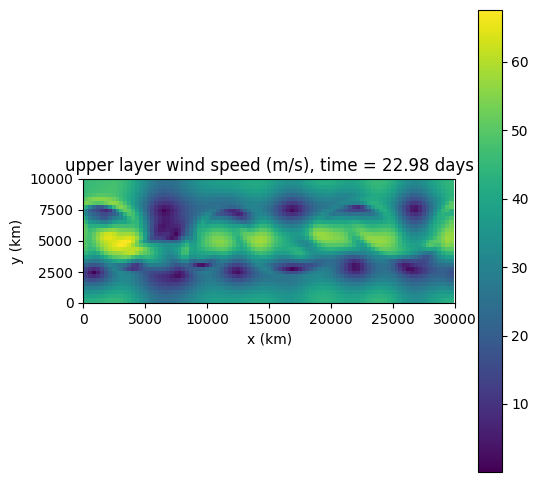

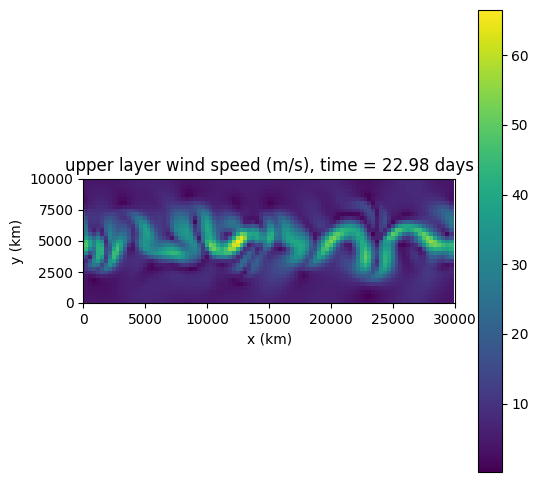

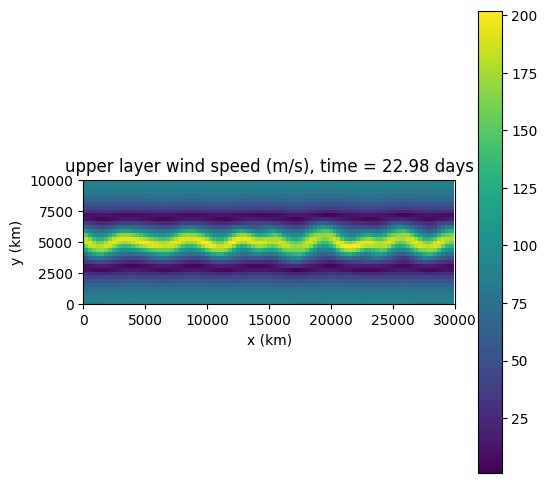

In [ ]:
# Code to solve the two-layer shallow water quasi-geostrophic equations

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = ((Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2)))/2    # q2_ic DIVIDED BY 2

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

# Set the non-dimensional parameters
Nx = 96 # Number of gridpoints in x
Ny = 32 # Number of gridpoints in y
Lx = 30e3 # Domain size in x in km
Ly = 10e3 # Domain size in y in km
Rd1 = 500 # Deformation radius in layer 1 in km
Rd2 = 500 # Deformation radius in layer 2 in km
U1 = 10/1000 # Background velocity in layer 1 in km/s
U2 = 0 # Background velocity in layer 2 in km/s
beta = 2e-11*1000 # beta = df/dy, the North/South gradient of the Coriolis parameter in 1/km/s
jet_width = 200
tau = 36 * 3600

#Set the hypervisocisty based on the grid spacing
delx = Lx/Nx
nu4 = 1e-6*delx**4

# Set the timestep based on the CFL criterion
timestep = 0.5*Lx/Nx/max(U1,U2)/20
stop_sim_time = 2e6
timestepper = dedalus.RK443

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=3/2)

# Define the coordinates
x, y = dist.local_grids(xbasis, ybasis)

# Define the fields
# Here psi is the streamfunction and q is the QG potential vorticity
# "1" corresponds to the upper layer and "2" corresponds to the lower layer
psi1 = dist.Field(name='psi1', bases=(xbasis, ybasis))
psi2 = dist.Field(name='psi2', bases=(xbasis, ybasis))
q1 = dist.Field(name='q1', bases=(xbasis, ybasis))
q2 = dist.Field(name='q2', bases=(xbasis, ybasis))
u1 = dist.Field(name='u1', bases=(xbasis, ybasis))
v1 = dist.Field(name='v1', bases=(xbasis, ybasis))
tau_psi1 = dist.Field(name='tau_psi1')

# Create functions to use for the initial conditions and forcing
# Here, q1_ic and q2_ic are departures from the basic state with a linear gradient
q1_ic = dist.Field(name='q1_ic', bases=(xbasis, ybasis))
q2_ic = dist.Field(name='q2_ic', bases=(xbasis, ybasis))
q1_ic['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2_ic['g'] = ((Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2)))*2      # q2_ic MULTIPLIED BY 2

# Set the initial conditions
q1['g'] = (Ly/2) * ((U1-U2)/Rd1**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
q2['g'] = (Ly/2) * ((U2-U1)/Rd2**2.0) * (np.tanh((y-Ly/2)/jet_width) - (y-Ly/2)/(Ly/2))
# Now, add some random noise
q1p = dist.Field(name='q1', bases=(xbasis, ybasis))
q2p = dist.Field(name='q2', bases=(xbasis, ybasis))
q1p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q2p.fill_random('g', seed=42, distribution='normal', scale=1e-6) # Random noise
q1['g'] += q1p['g']
q2['g'] += q2p['g']

# Define the operators that will be used to write the equations
dx = lambda A: dedalus.Differentiate(A, coords['x'])
dy = lambda A: dedalus.Differentiate(A, coords['y'])
lap = lambda A: dedalus.Laplacian(A)
J = lambda A, B: dx(A)*dy(B)-dy(A)*dx(B)
integ = lambda A: dedalus.Integrate(A, ('x', 'y'))
del4 = lambda A: lap(lap(A))

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, tau_psi1], namespace=locals())
# Define Laplacian and Jacobian operators (to make equations easier to read)

# Define problem
problem = dedalus.IVP([q1, q2, psi1, psi2, u1, v1, tau_psi1], namespace=locals())

# First, add the two equations for the evolution of the QG potential vorticity
problem.add_equation("dt(q1) + U1*dx(q1) + dx(psi1)*(beta+(U1-U2)/(Rd1**2.0)) + nu4*del4(q1) = - dx(psi1)*dy(q1) + dy(psi1)*dx(q1) - (1/tau)*(q1 - q1_ic)")
problem.add_equation("dt(q2) + U2*dx(q2) + dx(psi2)*(beta+(U2-U1)/(Rd2**2.0)) + nu4*del4(q2) = - dx(psi2)*dy(q2) + dy(psi2)*dx(q2) - (1/tau)*(q2 - q2_ic)")
problem.add_equation("lap(psi1)-(psi1-psi2)/(Rd1**2.0)+tau_psi1=q1")
problem.add_equation("lap(psi2)+(psi1-psi2)/(Rd2**2.0)=q2")

problem.add_equation("u1 = -dy(psi1)")
problem.add_equation("v1 = dx(psi1)")

problem.add_equation("integ(psi1) = 0")

# Now, set the solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

psi1.change_scales(1)
psi2.change_scales(1)
q1.change_scales(1)
q2.change_scales(1)
psi1_save = [np.copy(psi1['g'])];
psi2_save = [np.copy(psi2['g'])];
q1_save = [np.copy(q1['g'])];
q2_save = [np.copy(q2['g'])];

# Save the upper layer velocity for later plotting and analysis
u1.change_scales(1)
u1_save = [np.copy(u1['g'])]
v1.change_scales(1)
v1_save = [np.copy(v1['g'])]

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            psi1.change_scales(1)
            psi2.change_scales(1)
            psi1_save.append(np.copy(psi1['g']))
            psi2_save.append(np.copy(psi2['g']))
            q1.change_scales(1)
            q2.change_scales(1)
            q1_save.append(np.copy(q1['g']))
            q2_save.append(np.copy(q2['g']))

            u1.change_scales(1)
            u1_save.append(np.copy(u1['g']))
            v1.change_scales(1)
            v1_save.append(np.copy(v1['g']))

            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
psi1_save = np.array(psi1_save)
psi2_save = np.array(psi2_save)
q1_save = np.array(q1_save)
q2_save = np.array(q2_save)
u1_save = np.array(u1_save)
v1_save = np.array(v1_save)

# Create a movie of the results

# Create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))
(X_mesh, Y_mesh) = plot_tools.quad_mesh(np.squeeze(x[1:Nx]), np.squeeze(y[0,1:Ny]))

# Define an animation function
def drawframe(n):
    plt.clf()
    wind_speed = plt.pcolor(X, Y, np.sqrt(np.square(u1_save[n,:,:].T)+np.square(v1_save[n,:,:].T))*1000)#, vmin=0, vmax=100)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.xlim(0, Lx)
    plt.ylim(0, Ly)
    plt.colorbar()
    plt.title('upper layer wind speed (m/s), time = {0:.2f} days'.format(t_save[n]/3600/24))
    return (wind_speed,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

**plots above show a range of q2_ic - specifically baseline/2, baseline, baseline*2**

INSERT COMMENTS HERE (1-2 PARAGRAPHS)